- In order to use SKLearn's automation functionalities, you need to install `scikeras`
- The goal of scikeras is to make it possible to use Keras/TensorFlow with sklearn. This is achieved by providing a wrapper around Keras that has an Scikit-Learn interface.

> NOTE: Used Google Colab

In [2]:
pip install scikeras

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold

#deep llearning libraries
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from scikeras.wrappers import KerasClassifier, KerasRegressor #KerasRegressor (for regression)


## 1. Data Prep

- We'll be using the raisen dataset from Kaggle
- It has data for images of the Kecimen and Besni raisin varieties were obtained with CVS. A total of 900 raisins were used, including 450 from both varieties, and 7 morphological features were extracted.
- The targer is to predict the type of raisen (Kecimen and Besni)

In [4]:
df = pd.read_csv('/content/raisin_dataset.csv')
df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,Kecimen
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,Kecimen
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,Kecimen
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,Kecimen
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,Kecimen


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             900 non-null    int64  
 1   MajorAxisLength  900 non-null    float64
 2   MinorAxisLength  900 non-null    float64
 3   Eccentricity     900 non-null    float64
 4   ConvexArea       900 non-null    int64  
 5   Extent           900 non-null    float64
 6   Perimeter        900 non-null    float64
 7   Class            900 non-null    object 
dtypes: float64(5), int64(2), object(1)
memory usage: 56.4+ KB


In [6]:
# class balance
df['Class'].value_counts(normalize=True)

,proportion
Class,
Kecimen,0.5
Besni,0.5


Encode the class(target)

In [7]:
#method 1
#df['Class'] = df['Class'].map({'Kecimen': 0, 'Besni': 1})
#method 2
#df['Class'] = np.where(df['Class'] == 'Kecimen', 0, 1)
#method 3
df['Class'], class_labels = pd.factorize(df['Class'])
df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,0
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,0
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,0
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,0
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,0


In [8]:
X = df.drop('Class', axis=1)
y = df['Class']

In [9]:
mms = MinMaxScaler()
X = mms.fit_transform(X)
X[:5]

array([[0.29637031, 0.28071404, 0.314376  , 0.7678721 , 0.25550425,
        0.83142179, 0.27179088],
       [0.23742726, 0.23463777, 0.28494465, 0.73863618, 0.20886392,
        0.66785449, 0.24184205],
       [0.31226271, 0.2807413 , 0.35177845, 0.73300911, 0.26808369,
        0.56575414, 0.28359405],
       [0.09797291, 0.0789348 , 0.18662023, 0.54819437, 0.08408905,
        0.70180942, 0.10828416],
       [0.25766002, 0.16401114, 0.4220645 , 0.35096758, 0.21947175,
        0.90631526, 0.21849309]])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Since we did not use `Stratify`, let's make sure we still have a good target label balance between train and test

Text(0.5, 1.0, 'Test')

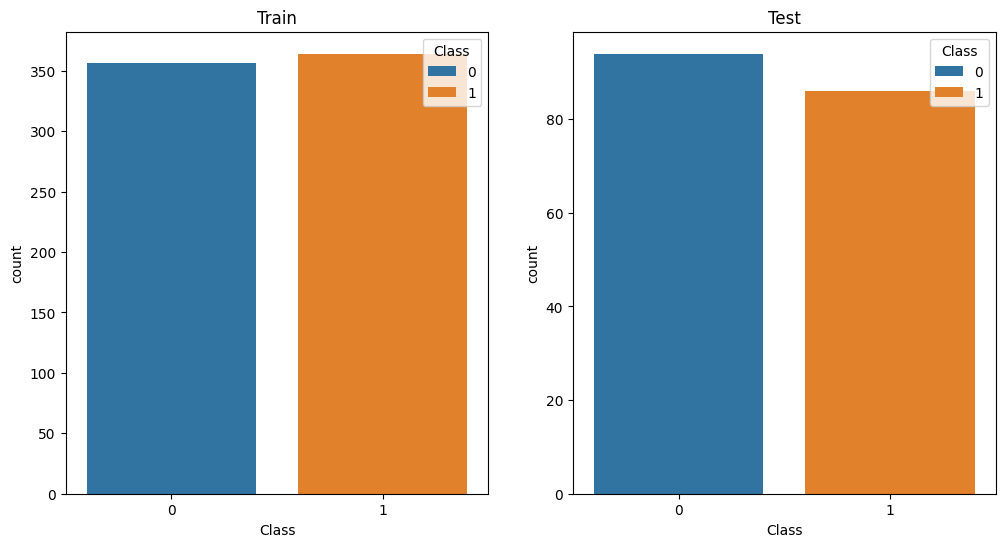

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sns.countplot(x=y_train, ax=axes[0], hue=y_train)
sns.countplot(x=y_test, ax=axes[1], hue=y_test)
axes[0].set_title('Train')
axes[1].set_title('Test')

## 2. Build A Model Function

In [12]:
def create_hyp_model(optimizer, activation, hiddent_units_1, hiddent_units_2):
  '''
  This function creates a Tensorflow and Keras model with:
  2 custom hidden layers, a sigmoid output layer, and 2 difernt optimizers
  '''

  model = Sequential()
  #first hidden layer with the number of neurons and activation function as hyperparameters
  model.add(Dense(hiddent_units_1, activation=activation, input_dim=X_train.shape[1]))
  #second hidden layer with the number of neurons and activation function as hyperparameters
  model.add(Dense(hiddent_units_2, activation=activation))
  #output layer
  model.add(Dense(1, activation='sigmoid'))
  # compile the model with the optimizer as a hyperparameter
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return model

## 3. Create `KerasClassifier`

In [13]:
#model = KerasRegressor(model=create_hyp_model, verbose=1)#
model = KerasClassifier(model=create_hyp_model, verbose=0)

## 4. Defining The Hyperparmeters Grid For Tuning

In [14]:
my_param_grid = {
    'model__optimizer': ['adam', 'rmsprop'],
    'model__activation': ['relu', 'tanh'],
    #number of neurons for hidden layer 1
    'model__hiddent_units_1': [32, 64, 128],
    #number of neurons for hidden layer 2
    'model__hiddent_units_2': [16, 32],
    'batch_size': [32, 64],
    'epochs': [10, 15]
}

## 5. Define and Fit The `GridSearchCV` Model

In [15]:
nn_grid_search = GridSearchCV(estimator=model
                              , param_grid=my_param_grid
                              , cv=StratifiedKFold(n_splits=4) # apply stratified kfold for proper lable balance with 4 folds
                              , scoring='accuracy')

In [16]:
nn_grid_search_training = nn_grid_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5229 - loss: 0.6749
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6163 - loss: 0.6509
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7480 - loss: 0.6307
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7651 - loss: 0.6090
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8002 - loss: 0.5806
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8161 - loss: 0.5510
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8202 - loss: 0.5236 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8490 - loss: 0.4940 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8529 - loss: 0.4650  
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8688 - loss: 0.4273
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8334 - loss: 0.6654
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8328 - loss: 0.6371 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8384 - loss: 0.6096
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8345 - loss: 0.5776 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8359 - loss: 0.5378
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8735 - loss: 0.4904
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8485 - loss: 0.4719
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8401 - loss: 0.4575
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8585 - loss: 0.4329
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8381 - loss: 0.4263  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6806 - loss: 0.6569
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8130 - loss: 0.6203 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8299 - loss: 0.5941 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8561 - loss: 0.5604 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8437 - loss: 0.5248
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8476 - loss: 0.4869 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8582 - loss: 0.4528  
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8683 - loss: 0.4257  
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8459 - loss: 0.4224
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8710 - loss: 0.3840


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6029 - loss: 0.6635
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8307 - loss: 0.6222
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8312 - loss: 0.5910
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8428 - loss: 0.5522  
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8513 - loss: 0.5209 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8351 - loss: 0.4918  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8450 - loss: 0.4701
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8762 - loss: 0.4319  
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8121 - loss: 0.4500
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8514 - loss: 0.4073 


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7231 - loss: 0.6598   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6223 - loss: 0.6241 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7579 - loss: 0.5969 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8058 - loss: 0.5590 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8374 - loss: 0.5425 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8358 - loss: 0.5143 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8671 - loss: 0.4972 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8199 - loss: 0.4857 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8870 - loss: 0.4429 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8477 - loss: 0.4451 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4744 - loss: 0.7010   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5242 - loss: 0.6477 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6752 - loss: 0.6173 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7384 - loss: 0.6036 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7816 - loss: 0.5632 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8146 - loss: 0.5391 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8626 - loss: 0.4878  
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8354 - loss: 0.4787 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8594 - loss: 0.4384 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8492 - loss: 0.4485 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5229 - loss: 0.6901   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6332 - loss: 0.6568 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7092 - loss: 0.6337 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7628 - loss: 0.6087 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8078 - loss: 0.5830 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7686 - loss: 0.5676 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8007 - loss: 0.5302 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8421 - loss: 0.5212 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8724 - loss: 0.4787 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8342 - loss: 0.4903 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5350 - loss: 0.6712   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6440 - loss: 0.6405 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7503 - loss: 0.6327 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7693 - loss: 0.6054 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7846 - loss: 0.5974
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8077 - loss: 0.5634 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8398 - loss: 0.5422 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8006 - loss: 0.5214 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8446 - loss: 0.5081 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8281 - loss: 0.4743 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5483 - loss: 0.6594
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6354 - loss: 0.6425 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7576 - loss: 0.6071 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8084 - loss: 0.5508  
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8650 - loss: 0.5188  
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8639 - loss: 0.4691  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8760 - loss: 0.4273
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8641 - loss: 0.4067 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8710 - loss: 0.3772 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8782 - loss: 0.3409 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6386 - loss: 0.6821
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5440 - loss: 0.6586 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6660 - loss: 0.6218 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7834 - loss: 0.5788 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7987 - loss: 0.5588 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7979 - loss: 0.5237 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8259 - loss: 0.4924 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8560 - loss: 0.4591 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8195 - loss: 0.4501 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8559 - loss: 0.4253 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4965 - loss: 0.6785
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5266 - loss: 0.6515 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6761 - loss: 0.6173 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7454 - loss: 0.5770 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7994 - loss: 0.5384 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8275 - loss: 0.5206 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8497 - loss: 0.4669 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8741 - loss: 0.4507 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8378 - loss: 0.4644  
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8700 - loss: 0.4139 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5144 - loss: 0.7081
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7883 - loss: 0.6651 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7692 - loss: 0.6340 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7741 - loss: 0.6164 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7791 - loss: 0.5857 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8334 - loss: 0.5430 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8186 - loss: 0.5220 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8502 - loss: 0.4693 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8403 - loss: 0.4456 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8328 - loss: 0.4251 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5548 - loss: 0.6578   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6651 - loss: 0.6234 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7658 - loss: 0.5900 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8087 - loss: 0.5599 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8133 - loss: 0.5375  
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8393 - loss: 0.4949  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8551 - loss: 0.4717 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8339 - loss: 0.4407 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8801 - loss: 0.4191 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8700 - loss: 0.4010 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4805 - loss: 0.6888
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6062 - loss: 0.6544 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6941 - loss: 0.6281 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7710 - loss: 0.5905 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7662 - loss: 0.5740 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8171 - loss: 0.5396 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7876 - loss: 0.5113  
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8304 - loss: 0.4734 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8120 - loss: 0.4619
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8234 - loss: 0.4291
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6501 - loss: 0.6756
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7320 - loss: 0.6287 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7941 - loss: 0.5998 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8103 - loss: 0.5490 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8210 - loss: 0.5083 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8340 - loss: 0.5025  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8423 - loss: 0.4505  
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8304 - loss: 0.4621  
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8372 - loss: 0.4167 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8546 - loss: 0.4128 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5268 - loss: 0.6836   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7372 - loss: 0.6314 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7584 - loss: 0.5952 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8020 - loss: 0.5329 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8367 - loss: 0.5196 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8424 - loss: 0.4685 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8427 - loss: 0.4534 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8715 - loss: 0.4189  
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8661 - loss: 0.4007 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8427 - loss: 0.4101 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5230 - loss: 0.6661
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5965 - loss: 0.6301 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7427 - loss: 0.5839 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8127 - loss: 0.5308 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8334 - loss: 0.4784  
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8379 - loss: 0.4577 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8507 - loss: 0.4092 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8539 - loss: 0.3924 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8517 - loss: 0.3701 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8574 - loss: 0.3924 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4984 - loss: 0.6706
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6101 - loss: 0.6286 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7275 - loss: 0.5832  
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7990 - loss: 0.5430 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7871 - loss: 0.5088 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8257 - loss: 0.4733 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8349 - loss: 0.4383 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8197 - loss: 0.4289  
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8178 - loss: 0.4346 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8069 - loss: 0.4340 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5099 - loss: 0.6781
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6400 - loss: 0.6391  
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7739 - loss: 0.6003 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8183 - loss: 0.5699 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8391 - loss: 0.4917 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8624 - loss: 0.4579  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8579 - loss: 0.4223  
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8750 - loss: 0.3815 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8834 - loss: 0.3724 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8603 - loss: 0.3496 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4987 - loss: 0.6872
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6045 - loss: 0.6605 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7620 - loss: 0.6246 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8568 - loss: 0.5684 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8268 - loss: 0.5351 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8405 - loss: 0.4703 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8492 - loss: 0.4303 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8460 - loss: 0.4180 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8740 - loss: 0.3707  
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8596 - loss: 0.3693 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6239 - loss: 0.6571   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6656 - loss: 0.6098  
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7963 - loss: 0.5758 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8518 - loss: 0.5481 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8357 - loss: 0.4890  
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8351 - loss: 0.4747  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8408 - loss: 0.4382 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8561 - loss: 0.4189  
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8529 - loss: 0.3981 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8526 - loss: 0.4049 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6770 - loss: 0.6550   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7729 - loss: 0.6036 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7949 - loss: 0.5681 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8104 - loss: 0.5023 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8055 - loss: 0.4957 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8308 - loss: 0.4618 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8445 - loss: 0.4397 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8449 - loss: 0.4230 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8396 - loss: 0.4194 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8571 - loss: 0.3944 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5490 - loss: 0.6675   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6829 - loss: 0.6165 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7747 - loss: 0.5823 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8393 - loss: 0.5240 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8769 - loss: 0.4914 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8779 - loss: 0.4448 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8729 - loss: 0.4483 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8577 - loss: 0.4201 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8725 - loss: 0.3977  
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8580 - loss: 0.4037 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5862 - loss: 0.6736   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7793 - loss: 0.6251 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8076 - loss: 0.5825 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8370 - loss: 0.5313  
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8357 - loss: 0.4979  
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8646 - loss: 0.4592  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8336 - loss: 0.4333 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8145 - loss: 0.4533 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8405 - loss: 0.4187  
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8555 - loss: 0.3849 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4744 - loss: 0.6937
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5319 - loss: 0.6506 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7126 - loss: 0.6064 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8057 - loss: 0.5662 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7861 - loss: 0.5424 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8658 - loss: 0.5009
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8327 - loss: 0.4839 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8252 - loss: 0.4400 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8304 - loss: 0.4362 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8748 - loss: 0.3905 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5111 - loss: 0.6709
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5287 - loss: 0.6467
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6543 - loss: 0.6110 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7388 - loss: 0.5876  
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7992 - loss: 0.5602  
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8431 - loss: 0.5248 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8195 - loss: 0.4922 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8530 - loss: 0.4491  
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8608 - loss: 0.4107 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8454 - loss: 0.4252 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4973 - loss: 0.7205
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6546 - loss: 0.6736 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7289 - loss: 0.6493 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8095 - loss: 0.6276 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8214 - loss: 0.6009 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8376 - loss: 0.5616  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8409 - loss: 0.5400 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8330 - loss: 0.5018 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8410 - loss: 0.4630  
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8483 - loss: 0.4455 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5426 - loss: 0.6383
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7061 - loss: 0.5985 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7548 - loss: 0.5766 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7988 - loss: 0.5377 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8180 - loss: 0.5044 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8181 - loss: 0.4851 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8493 - loss: 0.4551 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8626 - loss: 0.4261 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8465 - loss: 0.4294 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8249 - loss: 0.4121 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5331 - loss: 0.6689   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5420 - loss: 0.6373 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6573 - loss: 0.6049 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7854 - loss: 0.5600 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8010 - loss: 0.5323  
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8253 - loss: 0.4995  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8140 - loss: 0.4717 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8748 - loss: 0.4329 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8288 - loss: 0.4397 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8821 - loss: 0.3813  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5750 - loss: 0.6933   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8025 - loss: 0.6427 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8594 - loss: 0.6107  
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8604 - loss: 0.5857 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8709 - loss: 0.5624 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8533 - loss: 0.5290 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8612 - loss: 0.4865  
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8666 - loss: 0.4589  
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8839 - loss: 0.4282 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8587 - loss: 0.4376 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5708 - loss: 0.6916
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8246 - loss: 0.6450 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8256 - loss: 0.6051
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8362 - loss: 0.5722  
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8088 - loss: 0.5322 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8598 - loss: 0.4880 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8487 - loss: 0.4589
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8570 - loss: 0.4446
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8674 - loss: 0.4069
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8703 - loss: 0.3960 
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5850 - loss: 0.6825
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8609 - loss: 0.6284
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8243 - loss: 0.5937 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8635 - loss: 0.5500 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8435 - loss: 0.5166 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8324 - loss: 0.4831 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8286 - loss: 0.4688  
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8454 - loss: 0.4544
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8512 - loss: 0.4146
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8544 - loss: 0.4004  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6536 - loss: 0.6760
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7370 - loss: 0.6294 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7910 - loss: 0.5834  
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8291 - loss: 0.5380 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8473 - loss: 0.4712 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8598 - loss: 0.4528 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8351 - loss: 0.4345 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8607 - loss: 0.3992 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8467 - loss: 0.3927 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8759 - loss: 0.3442 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5965 - loss: 0.6713
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6383 - loss: 0.6210 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7679 - loss: 0.5663 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8247 - loss: 0.5242  
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8360 - loss: 0.4746 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8383 - loss: 0.4449 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8180 - loss: 0.4248 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8261 - loss: 0.4336 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8507 - loss: 0.3834 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8466 - loss: 0.3961 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5116 - loss: 0.6711
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6195 - loss: 0.6372 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6932 - loss: 0.5941 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7858 - loss: 0.5582 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8058 - loss: 0.5185 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8510 - loss: 0.4825 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8640 - loss: 0.4385 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8639 - loss: 0.4174 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8801 - loss: 0.4040 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8954 - loss: 0.3602 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4795 - loss: 0.7289
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6048 - loss: 0.6861 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8476 - loss: 0.6654
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8361 - loss: 0.6354 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8476 - loss: 0.6028 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8432 - loss: 0.5556 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8561 - loss: 0.5128 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8620 - loss: 0.4615 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8155 - loss: 0.4610 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8426 - loss: 0.4397 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6873 - loss: 0.6624   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8480 - loss: 0.5853 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8619 - loss: 0.5313 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8342 - loss: 0.4912 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8291 - loss: 0.4680 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8540 - loss: 0.4122 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8216 - loss: 0.4128 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8659 - loss: 0.4052 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8408 - loss: 0.3774 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8528 - loss: 0.3791  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5935 - loss: 0.6769   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7465 - loss: 0.6357 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8022 - loss: 0.5834 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8313 - loss: 0.5484 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8298 - loss: 0.5093 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8365 - loss: 0.4729 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8147 - loss: 0.4438 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8543 - loss: 0.4080 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8291 - loss: 0.4053  
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8469 - loss: 0.4078 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5679 - loss: 0.6697   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7630 - loss: 0.6256 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7644 - loss: 0.5929 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8146 - loss: 0.5547 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8120 - loss: 0.5072 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8330 - loss: 0.4781  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8786 - loss: 0.4491  
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8751 - loss: 0.4235  
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8831 - loss: 0.4052 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8578 - loss: 0.3976  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6458 - loss: 0.6594   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7542 - loss: 0.6087 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7832 - loss: 0.5685 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8387 - loss: 0.5110 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8491 - loss: 0.4798 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8476 - loss: 0.4506 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8711 - loss: 0.4036 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8512 - loss: 0.4467 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8315 - loss: 0.4277 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8528 - loss: 0.3783 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5326 - loss: 0.6819
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7308 - loss: 0.6220 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8114 - loss: 0.5638 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8649 - loss: 0.4724
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8658 - loss: 0.4047 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8517 - loss: 0.4034 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8611 - loss: 0.3839
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8585 - loss: 0.3638
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8699 - loss: 0.3755
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8500 - loss: 0.3642
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5529 - loss: 0.6726
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6814 - loss: 0.6332
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7632 - loss: 0.5824
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8559 - loss: 0.5156
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8577 - loss: 0.4615 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8597 - loss: 0.4111 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8461 - loss: 0.4015 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8534 - loss: 0.3743 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8461 - loss: 0.3711  
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8605 - loss: 0.3643  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3574 - loss: 0.6973
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6621 - loss: 0.6560 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7450 - loss: 0.6140 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8450 - loss: 0.5657 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8308 - loss: 0.5153 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8776 - loss: 0.4462  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8915 - loss: 0.3967  
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8539 - loss: 0.4007  
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8642 - loss: 0.3675 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8720 - loss: 0.3517 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4613 - loss: 0.7042
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5133 - loss: 0.6537 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6874 - loss: 0.6087 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8756 - loss: 0.5434 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8539 - loss: 0.4919 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8661 - loss: 0.4191 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8450 - loss: 0.4063 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8599 - loss: 0.3997 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8542 - loss: 0.3777 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8513 - loss: 0.4001  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5776 - loss: 0.6615   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7570 - loss: 0.5938 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8006 - loss: 0.5240 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8685 - loss: 0.4720 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8791 - loss: 0.4099 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8697 - loss: 0.3878 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8607 - loss: 0.3811 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8410 - loss: 0.3994 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8747 - loss: 0.3697  
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8402 - loss: 0.3855 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5632 - loss: 0.6595
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7413 - loss: 0.6002 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8621 - loss: 0.5430 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8584 - loss: 0.4781  
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8712 - loss: 0.4361 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8355 - loss: 0.4328 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8437 - loss: 0.4054 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8625 - loss: 0.3799 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8676 - loss: 0.3710 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8478 - loss: 0.3889 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5709 - loss: 0.6704
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7577 - loss: 0.6145 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7782 - loss: 0.5583 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8405 - loss: 0.5104 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8443 - loss: 0.4689 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8471 - loss: 0.4528
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8551 - loss: 0.4150 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8683 - loss: 0.3740
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8482 - loss: 0.3943
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8633 - loss: 0.3619 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5998 - loss: 0.6918   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8151 - loss: 0.6044 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8495 - loss: 0.5389 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8492 - loss: 0.4822 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8712 - loss: 0.4367 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8513 - loss: 0.3994 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8420 - loss: 0.4013 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8696 - loss: 0.3693 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8604 - loss: 0.3774 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8459 - loss: 0.4127 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5474 - loss: 0.6702
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6954 - loss: 0.6071 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7739 - loss: 0.5597 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8026 - loss: 0.5001 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8495 - loss: 0.4517 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8641 - loss: 0.4254  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8398 - loss: 0.4015 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8382 - loss: 0.3881  
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8745 - loss: 0.3579 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8502 - loss: 0.3731 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5174 - loss: 0.6811
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5173 - loss: 0.6476 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6669 - loss: 0.6166 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7374 - loss: 0.5736 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8016 - loss: 0.5354 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8125 - loss: 0.4857 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8541 - loss: 0.4637 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8445 - loss: 0.4324 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8213 - loss: 0.4234 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8561 - loss: 0.3694 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4823 - loss: 0.6911
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6421 - loss: 0.6175 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8120 - loss: 0.5658 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8124 - loss: 0.5126 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8667 - loss: 0.4430 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8571 - loss: 0.4335 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8492 - loss: 0.4018  
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8502 - loss: 0.4294 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8941 - loss: 0.3595 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8892 - loss: 0.3368  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5021 - loss: 0.6734
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6287 - loss: 0.6211 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7269 - loss: 0.5903 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7612 - loss: 0.5398
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8348 - loss: 0.4953 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8351 - loss: 0.4730 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8331 - loss: 0.4528 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8692 - loss: 0.4133 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8451 - loss: 0.3962 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8612 - loss: 0.3773 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5421 - loss: 0.6722
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7177 - loss: 0.6195 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8287 - loss: 0.5602 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8283 - loss: 0.5187  
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8584 - loss: 0.4623  
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8499 - loss: 0.4349 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8625 - loss: 0.4048  
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8604 - loss: 0.4202  
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8431 - loss: 0.4008 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8746 - loss: 0.3530  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6942 - loss: 0.6596   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7996 - loss: 0.5945 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8347 - loss: 0.5491 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8484 - loss: 0.4934  
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8409 - loss: 0.4629 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8613 - loss: 0.4292 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8582 - loss: 0.3939 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8573 - loss: 0.3855 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8682 - loss: 0.3783  
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8287 - loss: 0.3897 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5582 - loss: 0.7011   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7519 - loss: 0.6429 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8189 - loss: 0.5924 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8478 - loss: 0.5535 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8431 - loss: 0.5279 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8611 - loss: 0.4884  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8427 - loss: 0.4599  
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8617 - loss: 0.4377 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8689 - loss: 0.4194 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8804 - loss: 0.4027  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5619 - loss: 0.6633   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7703 - loss: 0.6048 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8110 - loss: 0.5556 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8004 - loss: 0.5231 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8338 - loss: 0.4774 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8331 - loss: 0.4424 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8494 - loss: 0.4281 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8515 - loss: 0.4105 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8591 - loss: 0.3841  
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8731 - loss: 0.3717  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7557 - loss: 0.6683
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7865 - loss: 0.6008  
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8564 - loss: 0.5337 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8514 - loss: 0.4647 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8866 - loss: 0.3922 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8591 - loss: 0.3831  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8691 - loss: 0.3668 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8569 - loss: 0.3688  
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8833 - loss: 0.3335 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8733 - loss: 0.3525 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6999 - loss: 0.6592
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7544 - loss: 0.5911  
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8236 - loss: 0.5470 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8362 - loss: 0.4855  
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8407 - loss: 0.4267 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8340 - loss: 0.4128
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8545 - loss: 0.3688  
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8256 - loss: 0.4029 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8303 - loss: 0.3782  
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8669 - loss: 0.3421 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6846 - loss: 0.6676
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8369 - loss: 0.6109 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8817 - loss: 0.5379 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8536 - loss: 0.4802 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8403 - loss: 0.4391 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8655 - loss: 0.3996  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8513 - loss: 0.3823  
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8719 - loss: 0.3604  
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8649 - loss: 0.3604 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8646 - loss: 0.3711 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6194 - loss: 0.6713
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8029 - loss: 0.6196 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8309 - loss: 0.5604  
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8535 - loss: 0.4923 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8499 - loss: 0.4413 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8249 - loss: 0.3984 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8686 - loss: 0.3797 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8478 - loss: 0.3631  
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8609 - loss: 0.3455 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8746 - loss: 0.3518  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6238 - loss: 0.6666   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7807 - loss: 0.5874 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8522 - loss: 0.5196 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8140 - loss: 0.4885  
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8366 - loss: 0.4482 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8537 - loss: 0.4080  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8886 - loss: 0.3581 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8418 - loss: 0.3925 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8741 - loss: 0.3542 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8491 - loss: 0.3591 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5645 - loss: 0.6736   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8281 - loss: 0.5941  
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8422 - loss: 0.5260  
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8524 - loss: 0.4764 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8346 - loss: 0.4463 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8555 - loss: 0.4040  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8259 - loss: 0.4080 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8297 - loss: 0.4085  
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8431 - loss: 0.3880 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8650 - loss: 0.3642 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5162 - loss: 0.6800   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7162 - loss: 0.6203 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8048 - loss: 0.5592 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8470 - loss: 0.5158 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8489 - loss: 0.4548 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8307 - loss: 0.4545 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8485 - loss: 0.4138  
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8689 - loss: 0.3894  
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8820 - loss: 0.3601 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8481 - loss: 0.3867 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6513 - loss: 0.6658
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7963 - loss: 0.5954 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8120 - loss: 0.5269 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8172 - loss: 0.4790 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8356 - loss: 0.4320  
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8453 - loss: 0.4149 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8200 - loss: 0.4073  
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8342 - loss: 0.3922 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8446 - loss: 0.3954 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8323 - loss: 0.3943 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5315 - loss: 0.6694
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6584 - loss: 0.5961 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8341 - loss: 0.5076 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8018 - loss: 0.4603 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8336 - loss: 0.4364  
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8811 - loss: 0.3542
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8667 - loss: 0.3532 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8601 - loss: 0.3503 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8835 - loss: 0.3125  
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8709 - loss: 0.3334  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5267 - loss: 0.6669
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7265 - loss: 0.5868 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8189 - loss: 0.5157 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8431 - loss: 0.4273  
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8674 - loss: 0.3937 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8669 - loss: 0.3620 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8519 - loss: 0.3790 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8471 - loss: 0.3926 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8528 - loss: 0.3766 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8574 - loss: 0.3749 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7445 - loss: 0.6597
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7563 - loss: 0.5905 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8582 - loss: 0.5156  
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8552 - loss: 0.4453 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8802 - loss: 0.3775  
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8502 - loss: 0.3690  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8639 - loss: 0.3643  
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8967 - loss: 0.3281 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8441 - loss: 0.3439 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8590 - loss: 0.3642 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5209 - loss: 0.6789
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6705 - loss: 0.6161
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8092 - loss: 0.5408
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8281 - loss: 0.4829
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8197 - loss: 0.4439
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8341 - loss: 0.4071
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8662 - loss: 0.3755 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8531 - loss: 0.3711
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8428 - loss: 0.4067
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8700 - loss: 0.3757 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6613 - loss: 0.6735
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8271 - loss: 0.5897 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8451 - loss: 0.5349 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8386 - loss: 0.4755  
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8427 - loss: 0.4317 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8658 - loss: 0.4052 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8714 - loss: 0.3604 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8547 - loss: 0.3907 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8529 - loss: 0.3823 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8665 - loss: 0.3338 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6321 - loss: 0.6324   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8465 - loss: 0.5331 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8276 - loss: 0.4944 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8311 - loss: 0.4351  
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8223 - loss: 0.4129 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8480 - loss: 0.3839 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8503 - loss: 0.3569  
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8405 - loss: 0.3731  
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8197 - loss: 0.3824 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8430 - loss: 0.3647  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6813 - loss: 0.6539   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8110 - loss: 0.5596 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8345 - loss: 0.5083 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8653 - loss: 0.4317 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8599 - loss: 0.4252  
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8701 - loss: 0.3906 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8607 - loss: 0.3650 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8793 - loss: 0.3515 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8850 - loss: 0.3403 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8584 - loss: 0.3674  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5890 - loss: 0.6618   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7792 - loss: 0.5780 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8363 - loss: 0.5128 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8662 - loss: 0.4600 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8283 - loss: 0.4406 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8393 - loss: 0.4258 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8477 - loss: 0.3618  
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8520 - loss: 0.3841 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8431 - loss: 0.4072 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8458 - loss: 0.3790  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3932 - loss: 0.7425
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5529 - loss: 0.6693 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7064 - loss: 0.6329 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7829 - loss: 0.5811 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8186 - loss: 0.5351 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8069 - loss: 0.5047 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8008 - loss: 0.4831  
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8404 - loss: 0.4581 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8483 - loss: 0.4074  
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8446 - loss: 0.3770  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4564 - loss: 0.7292
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4852 - loss: 0.6871 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5916 - loss: 0.6435 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7675 - loss: 0.6058 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8473 - loss: 0.5686  
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8489 - loss: 0.5306
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8421 - loss: 0.4986 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8574 - loss: 0.4467
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8376 - loss: 0.4391  
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8346 - loss: 0.4196
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3948 - loss: 0.6959
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5492 - loss: 0.6445  
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7481 - loss: 0.6115 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8301 - loss: 0.5832 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8375 - loss: 0.5381 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8705 - loss: 0.4884  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8423 - loss: 0.4664 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8569 - loss: 0.4414  
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8672 - loss: 0.4115 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8851 - loss: 0.3890  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5820 - loss: 0.6774
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6885 - loss: 0.6340  
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7883 - loss: 0.5967  
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8047 - loss: 0.5684  
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8402 - loss: 0.5201 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8181 - loss: 0.5075 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8540 - loss: 0.4757 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8514 - loss: 0.4292 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8408 - loss: 0.4373 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8507 - loss: 0.4027 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6451 - loss: 0.6663   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7697 - loss: 0.6042 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7958 - loss: 0.5707 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8566 - loss: 0.5015 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8479 - loss: 0.4825 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8505 - loss: 0.4560  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8727 - loss: 0.4252 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8913 - loss: 0.3721 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8543 - loss: 0.3906 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8610 - loss: 0.3714 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5784 - loss: 0.6579   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7509 - loss: 0.5943 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7925 - loss: 0.5584 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8168 - loss: 0.5089  
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8228 - loss: 0.4861 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8144 - loss: 0.4417  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8078 - loss: 0.4524 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8490 - loss: 0.4070  
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8700 - loss: 0.3821  
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8280 - loss: 0.3944 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5838 - loss: 0.6579   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7929 - loss: 0.5959 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7854 - loss: 0.5534 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8628 - loss: 0.5136 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8649 - loss: 0.4811
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8581 - loss: 0.4436 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8603 - loss: 0.4142 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8927 - loss: 0.3756 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8590 - loss: 0.3917 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8767 - loss: 0.3694 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5233 - loss: 0.7048
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6861 - loss: 0.6336 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7509 - loss: 0.5749
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8252 - loss: 0.5206 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8568 - loss: 0.4822 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8576 - loss: 0.4435 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8445 - loss: 0.4299 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8463 - loss: 0.4075 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8205 - loss: 0.4214  
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8417 - loss: 0.3788 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6239 - loss: 0.6651
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7507 - loss: 0.5804  
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8678 - loss: 0.5286 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8658 - loss: 0.4619 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8810 - loss: 0.4097 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8622 - loss: 0.4141  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8645 - loss: 0.3868 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8510 - loss: 0.3719 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8604 - loss: 0.3529 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8597 - loss: 0.3744 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5045 - loss: 0.6887
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6119 - loss: 0.6365 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7482 - loss: 0.5889 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7965 - loss: 0.5412 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8131 - loss: 0.5023 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8251 - loss: 0.4636 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8327 - loss: 0.4364  
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8360 - loss: 0.4156  
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8494 - loss: 0.3808  
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8551 - loss: 0.3724 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5218 - loss: 0.6793
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6947 - loss: 0.6198  
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8017 - loss: 0.5803  
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8486 - loss: 0.5137 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8552 - loss: 0.4718  
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8371 - loss: 0.4662  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8279 - loss: 0.4406
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8610 - loss: 0.3811 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8643 - loss: 0.3886 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8618 - loss: 0.3836 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5118 - loss: 0.6896
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6972 - loss: 0.6426 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7521 - loss: 0.5896 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7945 - loss: 0.5410
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8031 - loss: 0.4918 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8124 - loss: 0.4599 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8426 - loss: 0.4294 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8320 - loss: 0.4077 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8456 - loss: 0.3914
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8658 - loss: 0.3731 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6235 - loss: 0.6599
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7579 - loss: 0.5965 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8546 - loss: 0.5327 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8238 - loss: 0.4981 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8483 - loss: 0.4583 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8906 - loss: 0.3910 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8703 - loss: 0.3833  
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8502 - loss: 0.4170 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8480 - loss: 0.3916 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8655 - loss: 0.3682  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6638 - loss: 0.6665   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7189 - loss: 0.6067 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8453 - loss: 0.5412  
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8383 - loss: 0.5173 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8484 - loss: 0.4727 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8434 - loss: 0.4301 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8107 - loss: 0.4524  
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8485 - loss: 0.3884 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8579 - loss: 0.3956 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8551 - loss: 0.3878 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5855 - loss: 0.6639   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7898 - loss: 0.6001 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8216 - loss: 0.5550 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8185 - loss: 0.5162 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8615 - loss: 0.4576  
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8403 - loss: 0.4422 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8688 - loss: 0.4201 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8601 - loss: 0.4289 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8706 - loss: 0.3690  
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8617 - loss: 0.3958 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5953 - loss: 0.6688   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7497 - loss: 0.6033 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8030 - loss: 0.5620 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7750 - loss: 0.5233  
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8258 - loss: 0.4617  
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8351 - loss: 0.4445 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8293 - loss: 0.4368 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8264 - loss: 0.4516 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8323 - loss: 0.4096 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8388 - loss: 0.4103 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4342 - loss: 0.6931
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5774 - loss: 0.6292 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8103 - loss: 0.5760 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8383 - loss: 0.5017 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8821 - loss: 0.4391  
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8740 - loss: 0.4082  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8483 - loss: 0.3971  
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8655 - loss: 0.3964  
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8751 - loss: 0.3646
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8541 - loss: 0.3736
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5224 - loss: 0.6884
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5657 - loss: 0.6259 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7639 - loss: 0.5764
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8640 - loss: 0.5101
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8285 - loss: 0.4717 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8690 - loss: 0.4245
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8605 - loss: 0.3931 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8246 - loss: 0.4252 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8469 - loss: 0.4185  
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8568 - loss: 0.3643  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5523 - loss: 0.6875
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6861 - loss: 0.6005 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8359 - loss: 0.5353  
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8273 - loss: 0.4663 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8669 - loss: 0.4284 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8812 - loss: 0.3791  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8764 - loss: 0.3924  
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8520 - loss: 0.3824 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8795 - loss: 0.3613 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8809 - loss: 0.3531 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5385 - loss: 0.6692
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8048 - loss: 0.5801 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8102 - loss: 0.5093 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8615 - loss: 0.4505 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8552 - loss: 0.4010  
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8393 - loss: 0.4120 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8407 - loss: 0.3859 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8408 - loss: 0.3780 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8656 - loss: 0.3595 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8707 - loss: 0.3793  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5755 - loss: 0.6870   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7262 - loss: 0.5981 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8213 - loss: 0.5389 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8139 - loss: 0.4838 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8064 - loss: 0.4513 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8334 - loss: 0.4070 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8499 - loss: 0.3869 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8466 - loss: 0.3843  
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8658 - loss: 0.3485 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8611 - loss: 0.3886 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5519 - loss: 0.6691   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8394 - loss: 0.5678 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8423 - loss: 0.5058 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8656 - loss: 0.4273  
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8212 - loss: 0.4382 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8512 - loss: 0.3973 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8509 - loss: 0.4112 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8633 - loss: 0.3682 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8470 - loss: 0.3920 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8444 - loss: 0.4074 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4434 - loss: 0.6980
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7496 - loss: 0.6171
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8290 - loss: 0.5541
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8561 - loss: 0.4994 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8711 - loss: 0.4446 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8984 - loss: 0.3738 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8531 - loss: 0.4280 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8593 - loss: 0.4092 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8782 - loss: 0.3611
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8783 - loss: 0.3347 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5336 - loss: 0.6771
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7854 - loss: 0.5993 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8389 - loss: 0.5333  
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8205 - loss: 0.4955 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8516 - loss: 0.4361 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8497 - loss: 0.4060 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8664 - loss: 0.3763 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8439 - loss: 0.3909 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8504 - loss: 0.3698 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8324 - loss: 0.4070 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5904 - loss: 0.6812
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6846 - loss: 0.6223  
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8287 - loss: 0.5609 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8481 - loss: 0.5099 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8414 - loss: 0.4921 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8570 - loss: 0.4313 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8820 - loss: 0.3926  
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8688 - loss: 0.3745 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8748 - loss: 0.3666 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8845 - loss: 0.3694 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5548 - loss: 0.6485
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8121 - loss: 0.5934  
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8634 - loss: 0.5390 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8566 - loss: 0.4986  
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8524 - loss: 0.4498 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8534 - loss: 0.4145 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8554 - loss: 0.3898 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8439 - loss: 0.3977 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8297 - loss: 0.4286 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8561 - loss: 0.3978 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5333 - loss: 0.6869
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8206 - loss: 0.6158 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8020 - loss: 0.5633 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8870 - loss: 0.5004 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8564 - loss: 0.4709  
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8841 - loss: 0.4289 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8843 - loss: 0.4044 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8842 - loss: 0.3619 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8748 - loss: 0.4057 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8712 - loss: 0.3657 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7120 - loss: 0.6560
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7903 - loss: 0.5785 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8339 - loss: 0.5280 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8346 - loss: 0.4827  
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8328 - loss: 0.4501 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8491 - loss: 0.4289  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8632 - loss: 0.3788 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8453 - loss: 0.4086 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8701 - loss: 0.3622 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8444 - loss: 0.3703
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5345 - loss: 0.6918
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7243 - loss: 0.6414 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8014 - loss: 0.5898 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8197 - loss: 0.5295  
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8384 - loss: 0.4962 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8438 - loss: 0.4463
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8658 - loss: 0.4290 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8633 - loss: 0.4026
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8577 - loss: 0.3942
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8599 - loss: 0.3562
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4287 - loss: 0.7168   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7069 - loss: 0.6341  
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8076 - loss: 0.5839 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8425 - loss: 0.5218 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8237 - loss: 0.4802  
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8091 - loss: 0.4507  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8484 - loss: 0.4132 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8158 - loss: 0.4251 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8351 - loss: 0.4152  
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8589 - loss: 0.3600  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7390 - loss: 0.6297   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8135 - loss: 0.5594  
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8038 - loss: 0.5022 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8630 - loss: 0.4661 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8712 - loss: 0.4308 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8533 - loss: 0.4139 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8628 - loss: 0.3754  
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8586 - loss: 0.3676 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8778 - loss: 0.3542  
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8659 - loss: 0.3614  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4588 - loss: 0.7195   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6690 - loss: 0.6275 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7275 - loss: 0.5708 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8262 - loss: 0.5149 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8407 - loss: 0.4760  
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8290 - loss: 0.4593 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8437 - loss: 0.4234 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8448 - loss: 0.3957 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8575 - loss: 0.3831 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8540 - loss: 0.3848 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6906 - loss: 0.6562
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7075 - loss: 0.5814  
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8225 - loss: 0.5287  
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8166 - loss: 0.4703 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8189 - loss: 0.4370 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8487 - loss: 0.4189 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8545 - loss: 0.3845 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8707 - loss: 0.3502  
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8613 - loss: 0.3541 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8670 - loss: 0.3483 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7076 - loss: 0.6571
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7773 - loss: 0.5747
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8439 - loss: 0.5173
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8335 - loss: 0.4639 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8407 - loss: 0.4075
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8596 - loss: 0.3778
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8662 - loss: 0.3546 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8608 - loss: 0.3920 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8690 - loss: 0.3528 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8574 - loss: 0.3668 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5869 - loss: 0.6849
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6670 - loss: 0.6108 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8208 - loss: 0.5403
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8694 - loss: 0.4720 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8813 - loss: 0.4080  
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8934 - loss: 0.3799 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8648 - loss: 0.4022  
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8469 - loss: 0.4143 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8726 - loss: 0.3947 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8381 - loss: 0.3888 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5656 - loss: 0.6531
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7643 - loss: 0.5617 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8028 - loss: 0.5137  
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8131 - loss: 0.4500 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8271 - loss: 0.4219 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8661 - loss: 0.3790  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8539 - loss: 0.3788  
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8772 - loss: 0.3693  
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8451 - loss: 0.3698 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8502 - loss: 0.3474
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6734 - loss: 0.6645   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7776 - loss: 0.5647  
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8238 - loss: 0.5116  
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8316 - loss: 0.4460  
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8525 - loss: 0.4120  
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8562 - loss: 0.3748 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8527 - loss: 0.3710 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8391 - loss: 0.3717 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8640 - loss: 0.3534 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8662 - loss: 0.3628 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6000 - loss: 0.6738   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8454 - loss: 0.5720  
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8305 - loss: 0.4985 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8566 - loss: 0.4366 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8382 - loss: 0.4325 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8420 - loss: 0.4184 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8235 - loss: 0.4005 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8663 - loss: 0.3564 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8426 - loss: 0.3793 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8399 - loss: 0.3756 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6258 - loss: 0.6603
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7984 - loss: 0.5686 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8615 - loss: 0.4856 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8432 - loss: 0.4440 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8458 - loss: 0.4027 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8531 - loss: 0.4118 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8854 - loss: 0.3674
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8418 - loss: 0.4186
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8942 - loss: 0.3431
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8662 - loss: 0.3821
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5662 - loss: 0.6859
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7579 - loss: 0.5927  
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8221 - loss: 0.5193  
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8303 - loss: 0.4748 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8482 - loss: 0.4183 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8734 - loss: 0.3891  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8413 - loss: 0.4005 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8463 - loss: 0.3932 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8732 - loss: 0.3383 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8271 - loss: 0.3940 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6050 - loss: 0.6618
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7925 - loss: 0.5546 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8491 - loss: 0.4916 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8378 - loss: 0.4178  
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8713 - loss: 0.3805 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8480 - loss: 0.3770 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8623 - loss: 0.3775 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8684 - loss: 0.3638  
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8561 - loss: 0.3683 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8908 - loss: 0.3100 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5575 - loss: 0.6554
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8297 - loss: 0.5678 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8318 - loss: 0.4862  
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8387 - loss: 0.4428 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8342 - loss: 0.4078  
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8484 - loss: 0.4000 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8283 - loss: 0.4284  
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8699 - loss: 0.3590 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8606 - loss: 0.3460  
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8828 - loss: 0.3489 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5544 - loss: 0.6761
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8011 - loss: 0.5878 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8152 - loss: 0.5161 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8524 - loss: 0.4571  
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8846 - loss: 0.4081 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8505 - loss: 0.3936  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8449 - loss: 0.3705 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8672 - loss: 0.4247 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8873 - loss: 0.3420 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8562 - loss: 0.3684 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6227 - loss: 0.6633
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7311 - loss: 0.5624 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8655 - loss: 0.4735
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8658 - loss: 0.4135
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8325 - loss: 0.4006
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8761 - loss: 0.3554
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8841 - loss: 0.3455 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8649 - loss: 0.3672  
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8704 - loss: 0.3483 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8752 - loss: 0.3502 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6400 - loss: 0.6432
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8115 - loss: 0.5204 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8193 - loss: 0.4536 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8222 - loss: 0.4123 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8797 - loss: 0.3492 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8283 - loss: 0.3750 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8722 - loss: 0.3744 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8612 - loss: 0.3494  
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8740 - loss: 0.3246  
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8618 - loss: 0.3432  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7103 - loss: 0.6344   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8051 - loss: 0.5135 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8360 - loss: 0.4676 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8498 - loss: 0.4135 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8422 - loss: 0.4158  
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8478 - loss: 0.3494 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8651 - loss: 0.3534 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8591 - loss: 0.3940 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8294 - loss: 0.3797 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8534 - loss: 0.3811 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6139 - loss: 0.6587   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8429 - loss: 0.5198 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8700 - loss: 0.4285  
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8810 - loss: 0.3970 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8746 - loss: 0.3813 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8658 - loss: 0.3542 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8638 - loss: 0.3233 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8725 - loss: 0.3894 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8500 - loss: 0.3807 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8644 - loss: 0.3412 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6161 - loss: 0.6583   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8299 - loss: 0.5404 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8588 - loss: 0.4543  
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8538 - loss: 0.4163 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8509 - loss: 0.4006  
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8408 - loss: 0.3829  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8432 - loss: 0.4075 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8541 - loss: 0.3462 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8562 - loss: 0.3861  
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8514 - loss: 0.3894 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5768 - loss: 0.6683
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8429 - loss: 0.5615  
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8536 - loss: 0.4671 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8659 - loss: 0.4053  
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8598 - loss: 0.3717 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8502 - loss: 0.3647 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8317 - loss: 0.3994 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8574 - loss: 0.3719  
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8784 - loss: 0.3419 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8788 - loss: 0.3111 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4891 - loss: 0.6835
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7487 - loss: 0.5795 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7908 - loss: 0.5114 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8391 - loss: 0.4442
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8360 - loss: 0.4061 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8361 - loss: 0.4037 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8674 - loss: 0.3762
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8414 - loss: 0.3872 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8357 - loss: 0.3614
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8320 - loss: 0.3779 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5731 - loss: 0.6665
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7964 - loss: 0.5720 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8610 - loss: 0.4918 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8283 - loss: 0.4554  
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8733 - loss: 0.3862 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8503 - loss: 0.3913 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8755 - loss: 0.3535  
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8412 - loss: 0.4051 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8968 - loss: 0.3179 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8348 - loss: 0.4150 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5060 - loss: 0.6907
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7574 - loss: 0.5772  
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8311 - loss: 0.5041  
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8646 - loss: 0.4358  
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8511 - loss: 0.4141  
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8743 - loss: 0.3868  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8309 - loss: 0.4002 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8458 - loss: 0.3657 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8411 - loss: 0.3879 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8459 - loss: 0.3696  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7069 - loss: 0.6161   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8580 - loss: 0.4923 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8137 - loss: 0.4458 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8429 - loss: 0.4158 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8584 - loss: 0.3646  
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8648 - loss: 0.3667  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8429 - loss: 0.3865 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8495 - loss: 0.3505  
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8699 - loss: 0.3428  
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8647 - loss: 0.3473  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6156 - loss: 0.6514   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7909 - loss: 0.5549 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8499 - loss: 0.4715 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8326 - loss: 0.4398 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8189 - loss: 0.4176  
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8496 - loss: 0.4000 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8195 - loss: 0.4071 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8535 - loss: 0.3452 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8573 - loss: 0.3895 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8455 - loss: 0.3800 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5427 - loss: 0.6728   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7517 - loss: 0.5797  
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8332 - loss: 0.5094  
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8280 - loss: 0.4638  
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8559 - loss: 0.3989 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8541 - loss: 0.3873 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8496 - loss: 0.3943  
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8677 - loss: 0.3662 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8668 - loss: 0.3436 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8861 - loss: 0.3369  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6348 - loss: 0.6457
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8009 - loss: 0.5262  
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8460 - loss: 0.4450
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8519 - loss: 0.4067 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8540 - loss: 0.3952 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8461 - loss: 0.3942  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8619 - loss: 0.3616
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8422 - loss: 0.3880
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8699 - loss: 0.3328 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8512 - loss: 0.3639 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6461 - loss: 0.6414
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8502 - loss: 0.5053  
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8395 - loss: 0.4231  
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8506 - loss: 0.4037 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8792 - loss: 0.3289  
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8482 - loss: 0.3589 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8442 - loss: 0.3945 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8644 - loss: 0.3797  
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8554 - loss: 0.3341 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8912 - loss: 0.3534
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5305 - loss: 0.7044
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7731 - loss: 0.5624 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8208 - loss: 0.4974 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8525 - loss: 0.4441  
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8372 - loss: 0.3890 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8589 - loss: 0.3652  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8666 - loss: 0.3509  
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8567 - loss: 0.3610 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8393 - loss: 0.3906  
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8701 - loss: 0.3235 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4924 - loss: 0.7000
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8149 - loss: 0.5650  
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8290 - loss: 0.4892 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8443 - loss: 0.4234  
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8500 - loss: 0.4058 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8613 - loss: 0.3641 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8804 - loss: 0.3521 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8415 - loss: 0.4149 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8770 - loss: 0.3856  
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8766 - loss: 0.3624  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5477 - loss: 0.6491
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8393 - loss: 0.5504 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8422 - loss: 0.4675  
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8790 - loss: 0.4013 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8713 - loss: 0.3593 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8578 - loss: 0.3870 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8679 - loss: 0.3574 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8598 - loss: 0.3542 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8620 - loss: 0.3615 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8541 - loss: 0.3844 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6200 - loss: 0.6517
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8177 - loss: 0.5199 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8556 - loss: 0.4481 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8560 - loss: 0.3969 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8759 - loss: 0.3596 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8503 - loss: 0.3837 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8788 - loss: 0.3450
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8598 - loss: 0.3637
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8666 - loss: 0.3665
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8781 - loss: 0.3532 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6831 - loss: 0.6219
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8109 - loss: 0.5028 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8383 - loss: 0.4694 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8452 - loss: 0.4112 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8546 - loss: 0.3595  
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8611 - loss: 0.4251 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8646 - loss: 0.3425  
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8697 - loss: 0.3612 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8626 - loss: 0.3695 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8263 - loss: 0.3938  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7048 - loss: 0.6140   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8327 - loss: 0.5080  
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8397 - loss: 0.4459 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8484 - loss: 0.4111  
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8491 - loss: 0.3915  
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8930 - loss: 0.3319 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8875 - loss: 0.3309 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8400 - loss: 0.3886 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8803 - loss: 0.3550  
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8545 - loss: 0.3755 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6592 - loss: 0.6411   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8312 - loss: 0.5148 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8343 - loss: 0.4489  
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8478 - loss: 0.3850 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8444 - loss: 0.3885 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8549 - loss: 0.3710 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8584 - loss: 0.3765 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8654 - loss: 0.3580 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8663 - loss: 0.3566  
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8309 - loss: 0.4183  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4507 - loss: 0.6898
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8316 - loss: 0.5355 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8405 - loss: 0.4333
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8407 - loss: 0.4217
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8288 - loss: 0.3984
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8536 - loss: 0.3397
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8587 - loss: 0.3986 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8748 - loss: 0.3818 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8730 - loss: 0.3637 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8442 - loss: 0.4139  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4866 - loss: 0.6739
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8567 - loss: 0.5324  
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8505 - loss: 0.4436 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8304 - loss: 0.4093  
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8662 - loss: 0.3752  
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8501 - loss: 0.3946 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8909 - loss: 0.3305 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8487 - loss: 0.3681
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8459 - loss: 0.3674 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8432 - loss: 0.3736  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6582 - loss: 0.6459
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8694 - loss: 0.4956 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8469 - loss: 0.4231 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8630 - loss: 0.3772  
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8622 - loss: 0.3720  
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8642 - loss: 0.3478  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8792 - loss: 0.3410 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8878 - loss: 0.3448  
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8732 - loss: 0.3359  
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8668 - loss: 0.3712 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5062 - loss: 0.6926
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8187 - loss: 0.5442  
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8572 - loss: 0.4738  
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8475 - loss: 0.3934 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7876 - loss: 0.4226 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8361 - loss: 0.3829 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8416 - loss: 0.3773  
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8796 - loss: 0.3344 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8618 - loss: 0.3460  
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8760 - loss: 0.3483  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7360 - loss: 0.5971   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8366 - loss: 0.4538  
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8699 - loss: 0.3754  
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8621 - loss: 0.3871  
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8593 - loss: 0.3496 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8470 - loss: 0.3630  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8697 - loss: 0.3416  
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8619 - loss: 0.3369  
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8611 - loss: 0.3637  
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8645 - loss: 0.3425  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5582 - loss: 0.6436
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8356 - loss: 0.5223 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8435 - loss: 0.4533
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8253 - loss: 0.4386 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8446 - loss: 0.3889
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8400 - loss: 0.3674 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8590 - loss: 0.3686 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8501 - loss: 0.3687
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8509 - loss: 0.3670 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8487 - loss: 0.4110 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6673 - loss: 0.6356   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8232 - loss: 0.4923 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8542 - loss: 0.4420 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8725 - loss: 0.3871  
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8765 - loss: 0.3676 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8794 - loss: 0.3619 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8775 - loss: 0.3635 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8749 - loss: 0.3443 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8819 - loss: 0.3404  
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8892 - loss: 0.3004 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6120 - loss: 0.6494   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8225 - loss: 0.5080 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8698 - loss: 0.4306 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8621 - loss: 0.4029 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8633 - loss: 0.3735 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8462 - loss: 0.3787  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8671 - loss: 0.3428 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8618 - loss: 0.3762  
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8715 - loss: 0.3540  
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8414 - loss: 0.3901 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4787 - loss: 0.6842
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5188 - loss: 0.6587 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6081 - loss: 0.6434  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7458 - loss: 0.6097 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7864 - loss: 0.5848 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8014 - loss: 0.5565  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8502 - loss: 0.5215 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8626 - loss: 0.4929  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8501 - loss: 0.4782  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8700 - loss: 0.4333  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8618 - loss: 0.4152 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8780 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4843 - loss: 0.7223
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5433 - loss: 0.6975 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7591 - loss: 0.6801 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6986 - loss: 0.6655 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7772 - loss: 0.6518  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8095 - loss: 0.6321  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8434 - loss: 0.5968 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8403 - loss: 0.5682  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8424 - loss: 0.5315 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8549 - loss: 0.5019 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8463 - loss: 0.4762 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8445 - 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4796 - loss: 0.6696
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5014 - loss: 0.6446 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6158 - loss: 0.6214 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7201 - loss: 0.6023
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7347 - loss: 0.5772
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7928 - loss: 0.5592 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8275 - loss: 0.5273 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8442 - loss: 0.5061 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8507 - loss: 0.4752  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8781 - loss: 0.4547  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8522 - loss: 0.4249 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8726 - los

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5188 - loss: 0.7009
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4917 - loss: 0.6858 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5866 - loss: 0.6629 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6855 - loss: 0.6407  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7395 - loss: 0.6042 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7773 - loss: 0.5846 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7883 - loss: 0.5589 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8650 - loss: 0.5064  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8571 - loss: 0.4798  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8709 - loss: 0.4415 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8600 - loss: 0.4258  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8396 -

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5416 - loss: 0.7193   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5296 - loss: 0.6732 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7552 - loss: 0.6472 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7819 - loss: 0.6253 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8383 - loss: 0.5942 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8505 - loss: 0.5773 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8425 - loss: 0.5412 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8477 - loss: 0.5217 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8563 - loss: 0.5079  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8613 - loss: 0.4703 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8778 - loss: 0.4678  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8641 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5142 - loss: 0.7202   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7335 - loss: 0.6711 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5891 - loss: 0.6476  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7237 - loss: 0.6249 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7612 - loss: 0.6048  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7779 - loss: 0.5834 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8144 - loss: 0.5524  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8161 - loss: 0.5315 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8200 - loss: 0.5248  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8261 - loss: 0.5091
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8458 - loss: 0.4772 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8455

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5098 - loss: 0.6862
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5169 - loss: 0.6523 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5084 - loss: 0.6383 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6397 - loss: 0.6063 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7245 - loss: 0.5801  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7897 - loss: 0.5548 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7846 - loss: 0.5323  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8164 - loss: 0.5134 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8369 - loss: 0.5087  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8244 - loss: 0.4744  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8624 - loss: 0.4510 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8612 -

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6148 - loss: 0.6716   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8134 - loss: 0.6311  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8234 - loss: 0.6082 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8506 - loss: 0.5837 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8295 - loss: 0.5604 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8236 - loss: 0.5263  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8547 - loss: 0.5062  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8392 - loss: 0.4816  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8734 - loss: 0.4481 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8545 - loss: 0.4393 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8735 - loss: 0.4064  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.86

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4981 - loss: 0.6825
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5062 - loss: 0.6564 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5574 - loss: 0.6362 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6925 - loss: 0.6012  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7821 - loss: 0.5528  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8183 - loss: 0.5161  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8556 - loss: 0.4796  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8527 - loss: 0.4353  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8800 - loss: 0.4258
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8539 - loss: 0.3898 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8552 - loss: 0.3971  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8536 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7220 - loss: 0.6834
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8100 - loss: 0.6583 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8081 - loss: 0.6389  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8490 - loss: 0.6100 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8517 - loss: 0.5832 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8726 - loss: 0.5507 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8707 - loss: 0.5201  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8836 - loss: 0.4541
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8687 - loss: 0.4396 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8562 - loss: 0.4213
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8368 - loss: 0.4237
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8678 - loss

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5133 - loss: 0.6870
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5091 - loss: 0.6651 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6713 - loss: 0.6350 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7363 - loss: 0.6175 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8290 - loss: 0.5882  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8556 - loss: 0.5409  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8604 - loss: 0.5123 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8731 - loss: 0.4780 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8427 - loss: 0.4615 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8479 - loss: 0.4292  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8648 - loss: 0.4036 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8850 - 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5030 - loss: 0.6955
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7308 - loss: 0.6556 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7514 - loss: 0.6224 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7895 - loss: 0.5757 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8081 - loss: 0.5507 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8272 - loss: 0.4986  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8129 - loss: 0.4756 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8358 - loss: 0.4492 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8311 - loss: 0.4404  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8454 - loss: 0.4152  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8409 - loss: 0.3989  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8561 -

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4740 - loss: 0.7067   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7241 - loss: 0.6590
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8409 - loss: 0.6292 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8472 - loss: 0.6013 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8596 - loss: 0.5596  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8467 - loss: 0.5170 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8528 - loss: 0.4893 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8753 - loss: 0.4585 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8640 - loss: 0.4403  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8507 - loss: 0.4207  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8546 - loss: 0.4010 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8768 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7744 - loss: 0.6555
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7490 - loss: 0.6074  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7994 - loss: 0.5782
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8228 - loss: 0.5379
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8049 - loss: 0.5153
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8363 - loss: 0.4777
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8049 - loss: 0.4783 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8491 - loss: 0.4278
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8523 - loss: 0.4120
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8490 - loss: 0.3846
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8429 - loss: 0.3962  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8237 - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6099 - loss: 0.6745   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8701 - loss: 0.6129  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8491 - loss: 0.5849 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8382 - loss: 0.5572 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8533 - loss: 0.5231  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8735 - loss: 0.4948  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8625 - loss: 0.4650 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8613 - loss: 0.4544  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8727 - loss: 0.4301 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8826 - loss: 0.4100 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8782 - loss: 0.3906  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.86

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6774 - loss: 0.6736   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7597 - loss: 0.6180  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8738 - loss: 0.5602 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8471 - loss: 0.5292 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8445 - loss: 0.4975  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8361 - loss: 0.4605 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8257 - loss: 0.4674  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8505 - loss: 0.4306 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8536 - loss: 0.4231  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8315 - loss: 0.4154 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8667 - loss: 0.3727  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.86

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5496 - loss: 0.6901
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7558 - loss: 0.6541 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8033 - loss: 0.6265  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8430 - loss: 0.5740
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8570 - loss: 0.5189
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8424 - loss: 0.4850 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8493 - loss: 0.4345
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8819 - loss: 0.3818
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8697 - loss: 0.3725  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8592 - loss: 0.3782 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8655 - loss: 0.3706 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8530 - loss:

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5077 - loss: 0.6789
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6766 - loss: 0.6490  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7734 - loss: 0.6092  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8490 - loss: 0.5528 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8404 - loss: 0.5035  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8491 - loss: 0.4549 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8576 - loss: 0.4198 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8588 - loss: 0.3934  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8461 - loss: 0.3826  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8542 - loss: 0.3851 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8457 - loss: 0.3620  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8338

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5154 - loss: 0.6781
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6848 - loss: 0.6443 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7669 - loss: 0.5929 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8304 - loss: 0.5365 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8269 - loss: 0.4950  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8341 - loss: 0.4460  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8417 - loss: 0.4073 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8470 - loss: 0.3945  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8706 - loss: 0.3740  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8570 - loss: 0.3746  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8760 - loss: 0.3632 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8803 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5302 - loss: 0.6821
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5771 - loss: 0.6466 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7696 - loss: 0.5984 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8238 - loss: 0.5524 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8243 - loss: 0.5005 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8598 - loss: 0.4333 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8568 - loss: 0.4234  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8450 - loss: 0.4216  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8597 - loss: 0.3801  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8390 - loss: 0.4025  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8552 - loss: 0.3737  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8560 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6298 - loss: 0.6844
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6315 - loss: 0.6472  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7910 - loss: 0.5983 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7950 - loss: 0.5746 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8140 - loss: 0.5386  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8576 - loss: 0.4959  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8553 - loss: 0.4594  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8626 - loss: 0.4272 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8807 - loss: 0.4233 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8869 - loss: 0.3753 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8613 - loss: 0.4047 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8901 -

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6227 - loss: 0.6727   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7135 - loss: 0.6103
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7945 - loss: 0.5735 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8204 - loss: 0.5256  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7827 - loss: 0.5203 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8418 - loss: 0.4670  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8653 - loss: 0.4344  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8168 - loss: 0.4476  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8653 - loss: 0.3707  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8562 - loss: 0.3753 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8336 - loss: 0.3994 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.830

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6539 - loss: 0.6615   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8069 - loss: 0.6111 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8248 - loss: 0.5569 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8539 - loss: 0.5084 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8635 - loss: 0.4628  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8605 - loss: 0.4493 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8528 - loss: 0.4160 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8702 - loss: 0.3975  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8719 - loss: 0.3773 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8780 - loss: 0.3733 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8759 - loss: 0.3493
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8842 -

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5423 - loss: 0.6934
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6158 - loss: 0.6474 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7577 - loss: 0.6020
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8373 - loss: 0.5595  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8143 - loss: 0.5247  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8371 - loss: 0.4965 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8508 - loss: 0.4601 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8400 - loss: 0.4414  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8590 - loss: 0.3991 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8516 - loss: 0.4033  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8485 - loss: 0.3969 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8548 - 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6699 - loss: 0.6800
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8301 - loss: 0.6429 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8119 - loss: 0.6153  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8253 - loss: 0.5777 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8175 - loss: 0.5501 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8199 - loss: 0.5180 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8295 - loss: 0.4752  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8288 - loss: 0.4464 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8415 - loss: 0.4405  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8647 - loss: 0.4004 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8344 - loss: 0.4253  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8772 -

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5116 - loss: 0.7042
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8347 - loss: 0.6717  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7815 - loss: 0.6443 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8292 - loss: 0.6125 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8498 - loss: 0.5761 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8546 - loss: 0.5440 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8321 - loss: 0.5135 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8403 - loss: 0.4848
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8611 - loss: 0.4469 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8672 - loss: 0.4220  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8637 - loss: 0.3906  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8462 - l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5585 - loss: 0.6913
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8243 - loss: 0.6523
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8143 - loss: 0.6225
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8631 - loss: 0.5897
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8441 - loss: 0.5545
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8819 - loss: 0.5065
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8601 - loss: 0.4803
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8936 - loss: 0.4364
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8516 - loss: 0.4271
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9032 - loss: 0.3678 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8748 - loss: 0.3679 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8812 - loss: 0.376

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4860 - loss: 0.6883
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4914 - loss: 0.6608  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6278 - loss: 0.6340 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7087 - loss: 0.5914 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7781 - loss: 0.5401  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8041 - loss: 0.5213  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8290 - loss: 0.4807  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8454 - loss: 0.4454  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8546 - loss: 0.4242 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8138 - loss: 0.4349 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8369 - loss: 0.4111 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8522 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5278 - loss: 0.6788   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6452 - loss: 0.6420  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7569 - loss: 0.6068  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7731 - loss: 0.5788  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8075 - loss: 0.5530  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8166 - loss: 0.5237 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8239 - loss: 0.4815  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8482 - loss: 0.4733 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8430 - loss: 0.4408 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8755 - loss: 0.4079  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8685 - loss: 0.4083  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6371 - loss: 0.6751   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7211 - loss: 0.6184 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8235 - loss: 0.5940
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8441 - loss: 0.5481
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8371 - loss: 0.5232
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8569 - loss: 0.4700
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8276 - loss: 0.4690
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8490 - loss: 0.4485 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8191 - loss: 0.4294
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8473 - loss: 0.4006
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8700 - loss: 0.3772  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8638 - loss: 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5254 - loss: 0.6788
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7315 - loss: 0.6427 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8105 - loss: 0.6066 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8026 - loss: 0.5841 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8242 - loss: 0.5553  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8347 - loss: 0.5241  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8310 - loss: 0.4923  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8446 - loss: 0.4700 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8351 - loss: 0.4606  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8594 - loss: 0.4140  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8498 - loss: 0.4072  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8638

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5254 - loss: 0.6919   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7477 - loss: 0.6239 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8165 - loss: 0.5698 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7770 - loss: 0.5437  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8067 - loss: 0.4986 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8280 - loss: 0.4638  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8279 - loss: 0.4520  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8350 - loss: 0.4275 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8225 - loss: 0.4325  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8378 - loss: 0.4034 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8662 - loss: 0.3852  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.84

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4911 - loss: 0.6917
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5789 - loss: 0.6521 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7626 - loss: 0.6019 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8480 - loss: 0.5518 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8565 - loss: 0.4976 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8665 - loss: 0.4423  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8711 - loss: 0.3913 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8773 - loss: 0.3920 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8805 - loss: 0.3526  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8720 - loss: 0.3626  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8659 - loss: 0.3563 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8792 - 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5559 - loss: 0.7084
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6153 - loss: 0.6443 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7438 - loss: 0.5998 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8274 - loss: 0.5511
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8607 - loss: 0.4772
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8568 - loss: 0.4542
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8628 - loss: 0.4159  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8292 - loss: 0.4196
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8619 - loss: 0.3838
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8736 - loss: 0.3525 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8349 - loss: 0.3745 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8505 - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7071 - loss: 0.6783
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8227 - loss: 0.6283 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8527 - loss: 0.5871  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8813 - loss: 0.5247 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8931 - loss: 0.4607  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8909 - loss: 0.4217 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8628 - loss: 0.4012  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8697 - loss: 0.3863  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8865 - loss: 0.3406 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8591 - loss: 0.3755  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8723 - loss: 0.3460  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8734

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7080 - loss: 0.6692
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7339 - loss: 0.6315  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8037 - loss: 0.5830 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8268 - loss: 0.5335 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8296 - loss: 0.5027 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8245 - loss: 0.4553 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8080 - loss: 0.4595  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8733 - loss: 0.3729 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8460 - loss: 0.3885  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8328 - loss: 0.3968 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8368 - loss: 0.3900 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8428 - 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6035 - loss: 0.6735
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7261 - loss: 0.6146 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7709 - loss: 0.5862
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7878 - loss: 0.5355
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8741 - loss: 0.4921
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8510 - loss: 0.4551
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8567 - loss: 0.4248
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8534 - loss: 0.4330
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8705 - loss: 0.3790
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8440 - loss: 0.4092
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8586 - loss: 0.3849
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8395 - loss: 0.4042

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4926 - loss: 0.6884
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7649 - loss: 0.6359
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7856 - loss: 0.5828
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8613 - loss: 0.5367 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8234 - loss: 0.4918 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8580 - loss: 0.4428
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8506 - loss: 0.4426
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8340 - loss: 0.4474
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8546 - loss: 0.3889  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8620 - loss: 0.3627 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8680 - loss: 0.3682
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8520 - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5219 - loss: 0.7009   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7714 - loss: 0.6461  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8267 - loss: 0.6039 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8400 - loss: 0.5623  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8718 - loss: 0.5217  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8728 - loss: 0.4816  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8727 - loss: 0.4511 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8524 - loss: 0.4189  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8555 - loss: 0.4050  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8712 - loss: 0.3813 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8667 - loss: 0.3802  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5326 - loss: 0.6722   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7862 - loss: 0.6365 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7614 - loss: 0.5957 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7921 - loss: 0.5631 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8160 - loss: 0.5338 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8335 - loss: 0.4871  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8451 - loss: 0.4589 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8323 - loss: 0.4440  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8590 - loss: 0.4054 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8480 - loss: 0.4198 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8441 - loss: 0.3916  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8474

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5480 - loss: 0.6652
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7185 - loss: 0.6103
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8060 - loss: 0.5383
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8252 - loss: 0.4801 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8629 - loss: 0.4223
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8699 - loss: 0.3981
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8612 - loss: 0.3481 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8401 - loss: 0.3931
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8704 - loss: 0.3483 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8439 - loss: 0.3649 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8764 - loss: 0.3144 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8757 - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7032 - loss: 0.6775
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7524 - loss: 0.6240  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8177 - loss: 0.5635 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8455 - loss: 0.5158  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8470 - loss: 0.4493 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8773 - loss: 0.4000 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8778 - loss: 0.3677  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8502 - loss: 0.3618 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8197 - loss: 0.4391 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8525 - loss: 0.4061 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8675 - loss: 0.3555  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8411 -

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5518 - loss: 0.6779
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6602 - loss: 0.6339 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7563 - loss: 0.5766 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8502 - loss: 0.5094 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8853 - loss: 0.4575  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8679 - loss: 0.4201 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8590 - loss: 0.3840  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8816 - loss: 0.3572 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8869 - loss: 0.3666  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8715 - loss: 0.3646
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8534 - loss: 0.3650 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8753 - l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5923 - loss: 0.6762
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6492 - loss: 0.6285  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8485 - loss: 0.5728  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8512 - loss: 0.5200  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8509 - loss: 0.4770  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8336 - loss: 0.4256  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8618 - loss: 0.3834  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8463 - loss: 0.3960  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8287 - loss: 0.3909  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8704 - loss: 0.3343  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8328 - loss: 0.3888  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6833 - loss: 0.6685
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8579 - loss: 0.5975 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8401 - loss: 0.5354 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8400 - loss: 0.4967
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8671 - loss: 0.4451 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8460 - loss: 0.4183 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8750 - loss: 0.3806
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8746 - loss: 0.3732
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8636 - loss: 0.3771 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8681 - loss: 0.3742 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8576 - loss: 0.3616 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8666 - loss: 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5289 - loss: 0.6709   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7385 - loss: 0.5994  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8161 - loss: 0.5577 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8147 - loss: 0.5042  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8290 - loss: 0.4770  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8504 - loss: 0.4283 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8570 - loss: 0.4122 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8470 - loss: 0.4032 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8464 - loss: 0.3832 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8698 - loss: 0.3661  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8663 - loss: 0.3692 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.851

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5481 - loss: 0.6684   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7282 - loss: 0.6079  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8641 - loss: 0.5610 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8680 - loss: 0.4912  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8575 - loss: 0.4531  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8723 - loss: 0.4140  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8726 - loss: 0.3890  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8591 - loss: 0.4055 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8632 - loss: 0.3623 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8709 - loss: 0.3467  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8700 - loss: 0.3679 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5043 - loss: 0.6921   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6336 - loss: 0.6458 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7840 - loss: 0.5970  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8346 - loss: 0.5520  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8514 - loss: 0.5074
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8362 - loss: 0.4668 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8882 - loss: 0.4218 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8443 - loss: 0.4208
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8725 - loss: 0.3861
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8706 - loss: 0.3769  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8352 - loss: 0.3813
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8548 - l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7595 - loss: 0.6708
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6608 - loss: 0.6340  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8017 - loss: 0.5942 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8039 - loss: 0.5516 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8229 - loss: 0.5070  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8672 - loss: 0.4518  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8458 - loss: 0.4280  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8343 - loss: 0.4176 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8424 - loss: 0.3871  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8434 - loss: 0.3762  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8668 - loss: 0.3578  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.852

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5117 - loss: 0.6971
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5846 - loss: 0.6472 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7771 - loss: 0.6010  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8328 - loss: 0.5612  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8468 - loss: 0.5186  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8442 - loss: 0.4762  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8266 - loss: 0.4626 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8224 - loss: 0.4459 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8546 - loss: 0.3899  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8448 - loss: 0.3948  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8540 - loss: 0.3639  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.849

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6042 - loss: 0.6875
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7571 - loss: 0.6648  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8296 - loss: 0.6373  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8839 - loss: 0.6003  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8589 - loss: 0.5664 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8722 - loss: 0.5224  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8718 - loss: 0.4653 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8710 - loss: 0.4420 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8834 - loss: 0.4042  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8618 - loss: 0.3970  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8638 - loss: 0.3849 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8778

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5999 - loss: 0.6858
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5629 - loss: 0.6554
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6823 - loss: 0.6318  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7404 - loss: 0.6060
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7992 - loss: 0.5605
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8602 - loss: 0.5057
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8452 - loss: 0.4671 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8780 - loss: 0.4272 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8476 - loss: 0.4238 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8529 - loss: 0.3921  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8379 - loss: 0.4074 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8581 - loss:

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5498 - loss: 0.6610   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7773 - loss: 0.6041  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7899 - loss: 0.5585 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8406 - loss: 0.4961  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8375 - loss: 0.4755 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8583 - loss: 0.4374 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8572 - loss: 0.4143 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8635 - loss: 0.4107 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8507 - loss: 0.3973  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8581 - loss: 0.3924 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8721 - loss: 0.3653  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.848

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4549 - loss: 0.6807   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7902 - loss: 0.6104 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8229 - loss: 0.5634 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8090 - loss: 0.5255  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8714 - loss: 0.4767  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8460 - loss: 0.4529 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8310 - loss: 0.4303 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8668 - loss: 0.3894  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8345 - loss: 0.3955 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8391 - loss: 0.3821  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8471 - loss: 0.4085  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.86

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5680 - loss: 0.6696   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8283 - loss: 0.5968 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8196 - loss: 0.5265 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8413 - loss: 0.5190 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8603 - loss: 0.4560  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8775 - loss: 0.4276 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8663 - loss: 0.4034  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8837 - loss: 0.3709 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8802 - loss: 0.3446 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8847 - loss: 0.3486 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8657 - loss: 0.3622  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8737

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6203 - loss: 0.6648
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8145 - loss: 0.5969  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8394 - loss: 0.5494 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8367 - loss: 0.4948 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8420 - loss: 0.4703 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8573 - loss: 0.4459 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8429 - loss: 0.4220  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8384 - loss: 0.4158  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8840 - loss: 0.3685  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8501 - loss: 0.3706  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8644 - loss: 0.3613 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8758 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7013 - loss: 0.6737
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6744 - loss: 0.6207 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7866 - loss: 0.5631  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8465 - loss: 0.5060 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8061 - loss: 0.4458 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8875 - loss: 0.3696  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8542 - loss: 0.3854  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8470 - loss: 0.3857  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8751 - loss: 0.3618 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8412 - loss: 0.3786 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8634 - loss: 0.3326 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8639 -

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5157 - loss: 0.6795
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6648 - loss: 0.6224
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8317 - loss: 0.5675
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8387 - loss: 0.5022
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8563 - loss: 0.4374
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8105 - loss: 0.4316
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8494 - loss: 0.4058
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8422 - loss: 0.3818
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8451 - loss: 0.3939 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8565 - loss: 0.3696
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8664 - loss: 0.3563
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8549 - loss: 0.3829

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6983 - loss: 0.6635
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8129 - loss: 0.5889  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8598 - loss: 0.5197 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8442 - loss: 0.4633  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8683 - loss: 0.3887  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8689 - loss: 0.3803 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8742 - loss: 0.3697 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8462 - loss: 0.3758 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8663 - loss: 0.3527 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8523 - loss: 0.3691 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8679 - loss: 0.3352 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8747 - 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5162 - loss: 0.6783
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6442 - loss: 0.6085 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8173 - loss: 0.5635 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8056 - loss: 0.5044
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8427 - loss: 0.4417 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8563 - loss: 0.4068 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8269 - loss: 0.4057 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8612 - loss: 0.3728  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8639 - loss: 0.3290  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8533 - loss: 0.3555 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8467 - loss: 0.3972 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8499 - lo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5016 - loss: 0.6608   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8223 - loss: 0.5775  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8489 - loss: 0.5092  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8387 - loss: 0.4579 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8363 - loss: 0.4380 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8413 - loss: 0.3991  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8620 - loss: 0.3880 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8633 - loss: 0.3788  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8794 - loss: 0.3414 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8846 - loss: 0.3146
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8687 - loss: 0.3507
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8747 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6955 - loss: 0.6589
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7365 - loss: 0.5841 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8389 - loss: 0.5134 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8462 - loss: 0.4612 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8429 - loss: 0.4307  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8527 - loss: 0.4095  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8497 - loss: 0.3810 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8430 - loss: 0.3999
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8380 - loss: 0.3681 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8388 - loss: 0.3839 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8324 - loss: 0.3811
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8726 - los

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6107 - loss: 0.6592   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8691 - loss: 0.5561 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8562 - loss: 0.4966  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8590 - loss: 0.4307
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8750 - loss: 0.4093 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8868 - loss: 0.3884  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8615 - loss: 0.3651 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8772 - loss: 0.3527  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8660 - loss: 0.3638 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8624 - loss: 0.3679  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8508 - loss: 0.3556 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8711

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5747 - loss: 0.6526   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7632 - loss: 0.6016 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7864 - loss: 0.5271  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8393 - loss: 0.4705 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8462 - loss: 0.4270  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8445 - loss: 0.3935
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8436 - loss: 0.3808 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8598 - loss: 0.3628  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8253 - loss: 0.3988  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8539 - loss: 0.3644  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8429 - loss: 0.3795  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.85

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5369 - loss: 0.6668
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7266 - loss: 0.6060
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7849 - loss: 0.5358  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8438 - loss: 0.4516  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8655 - loss: 0.3898 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8725 - loss: 0.3685  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8853 - loss: 0.3454  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8713 - loss: 0.3397  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8725 - loss: 0.3423
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8362 - loss: 0.3600
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8636 - loss: 0.3423 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8568 - l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6584 - loss: 0.6694
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7031 - loss: 0.6090 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8210 - loss: 0.5376  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8544 - loss: 0.4678  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8249 - loss: 0.4254 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8283 - loss: 0.4067 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8165 - loss: 0.4125  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8556 - loss: 0.3754  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8299 - loss: 0.3814
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8361 - loss: 0.4177 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8550 - loss: 0.3760 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8616 - 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5402 - loss: 0.6605
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7784 - loss: 0.5939 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8434 - loss: 0.5147  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8865 - loss: 0.4328  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8721 - loss: 0.3994  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8710 - loss: 0.3744 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8738 - loss: 0.3437 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8686 - loss: 0.3597
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8541 - loss: 0.3704 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8647 - loss: 0.3453 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8712 - loss: 0.3397  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8667 - 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5286 - loss: 0.6668
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7821 - loss: 0.5850
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8399 - loss: 0.5083
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8387 - loss: 0.4396 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8442 - loss: 0.4184
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8582 - loss: 0.3797
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8267 - loss: 0.3837 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8659 - loss: 0.3607  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8557 - loss: 0.3715  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8660 - loss: 0.3608  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8560 - loss: 0.3720
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8583 - loss:

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6855 - loss: 0.6368   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8265 - loss: 0.5468 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8479 - loss: 0.4707 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8181 - loss: 0.4361  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8569 - loss: 0.3873 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8295 - loss: 0.3957 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8519 - loss: 0.3607  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8524 - loss: 0.3852 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8433 - loss: 0.3605  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8641 - loss: 0.3677 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8688 - loss: 0.3603 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8737

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6229 - loss: 0.6539   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8172 - loss: 0.5584 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8431 - loss: 0.4741  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8346 - loss: 0.4483  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8464 - loss: 0.4023  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8528 - loss: 0.3987  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8615 - loss: 0.3692  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8710 - loss: 0.3586 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8395 - loss: 0.4061 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8464 - loss: 0.4094
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8398 - loss: 0.3796 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.864

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6071 - loss: 0.6680
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8093 - loss: 0.5763
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8609 - loss: 0.4953
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8477 - loss: 0.4523
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8616 - loss: 0.4162  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8434 - loss: 0.4056
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8566 - loss: 0.3709
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8525 - loss: 0.3934 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8495 - loss: 0.3667 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8648 - loss: 0.3631 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8886 - loss: 0.3358
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8591 - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5822 - loss: 0.6770   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7349 - loss: 0.6118 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8119 - loss: 0.5454 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8161 - loss: 0.4981 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8600 - loss: 0.4334  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8585 - loss: 0.4122  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8196 - loss: 0.4304  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8307 - loss: 0.3974 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8598 - loss: 0.3546  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8168 - loss: 0.4056  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8499 - loss: 0.3706 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.86

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4937 - loss: 0.8186
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5828 - loss: 0.6777  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5552 - loss: 0.6371  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7390 - loss: 0.6097  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7773 - loss: 0.5808 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8010 - loss: 0.5405  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8252 - loss: 0.5081 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8383 - loss: 0.4805  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8161 - loss: 0.4529 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8425 - loss: 0.4235 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8365 - loss: 0.4104  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8368

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5275 - loss: 0.6853
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7701 - loss: 0.6315 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8322 - loss: 0.5790 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8162 - loss: 0.5394  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8512 - loss: 0.5067 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8693 - loss: 0.4485  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8531 - loss: 0.4366
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8620 - loss: 0.4186  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8587 - loss: 0.4023
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8576 - loss: 0.3964
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8658 - loss: 0.3889
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8593 - loss

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5510 - loss: 0.7002
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5560 - loss: 0.6525 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7179 - loss: 0.6259  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7880 - loss: 0.5885 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8327 - loss: 0.5406 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8816 - loss: 0.4952  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8637 - loss: 0.4568  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8604 - loss: 0.4438  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8564 - loss: 0.4111 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8854 - loss: 0.3791  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8719 - loss: 0.3854 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8599 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4743 - loss: 0.7117
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5066 - loss: 0.6748  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6447 - loss: 0.6396 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7732 - loss: 0.6108  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8362 - loss: 0.5658 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8477 - loss: 0.5323 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8264 - loss: 0.5030 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8451 - loss: 0.4540 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8601 - loss: 0.4311 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8297 - loss: 0.4311 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8318 - loss: 0.4112 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8592 - l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4717 - loss: 0.7214   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7182 - loss: 0.6454 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7286 - loss: 0.6031  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8291 - loss: 0.5639  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8428 - loss: 0.5061  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8645 - loss: 0.4704  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8540 - loss: 0.4565 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8385 - loss: 0.4284 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8382 - loss: 0.4001 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8536 - loss: 0.3895  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8608 - loss: 0.3829  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4336 - loss: 0.7234
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8107 - loss: 0.6580
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7435 - loss: 0.5961
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8256 - loss: 0.5638
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8568 - loss: 0.5244
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8335 - loss: 0.4842
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8528 - loss: 0.4594  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8341 - loss: 0.4298 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8370 - loss: 0.4389 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8287 - loss: 0.4040  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8351 - loss: 0.4005 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8529 - loss: 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6293 - loss: 0.6606   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7902 - loss: 0.6192 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7738 - loss: 0.5797  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8233 - loss: 0.5445  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8380 - loss: 0.5059 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8468 - loss: 0.4651  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8379 - loss: 0.4473 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8522 - loss: 0.4398 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8554 - loss: 0.3806  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8595 - loss: 0.3844  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8629 - loss: 0.3693 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.86

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4717 - loss: 0.7358   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6272 - loss: 0.6511  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7283 - loss: 0.5970  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8193 - loss: 0.5440  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7886 - loss: 0.5118  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8410 - loss: 0.4756  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8291 - loss: 0.4560  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8372 - loss: 0.4022 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8450 - loss: 0.4143  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8224 - loss: 0.4137
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8333 - loss: 0.3944 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5150 - loss: 0.7105
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7700 - loss: 0.6365
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7948 - loss: 0.5878
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8813 - loss: 0.5319
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8734 - loss: 0.4720
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8687 - loss: 0.4263  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8644 - loss: 0.4139
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8804 - loss: 0.3712
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8404 - loss: 0.3998
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8564 - loss: 0.3832
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8683 - loss: 0.3529  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8592 - loss: 0.3

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5282 - loss: 0.6993
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7502 - loss: 0.6182 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7852 - loss: 0.5650 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8073 - loss: 0.5214  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8283 - loss: 0.4859 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8173 - loss: 0.4543 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8541 - loss: 0.4338  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8234 - loss: 0.4441  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8395 - loss: 0.4207 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8167 - loss: 0.4008  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8446 - loss: 0.3731  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8443 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5498 - loss: 0.6889
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6486 - loss: 0.6366  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8337 - loss: 0.6004 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8680 - loss: 0.5425 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8885 - loss: 0.4822  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8761 - loss: 0.4494 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8859 - loss: 0.4187  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8712 - loss: 0.4074 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8810 - loss: 0.3659 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8711 - loss: 0.3630 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8780 - loss: 0.3457 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8984 - 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5378 - loss: 0.7051
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5279 - loss: 0.6504
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6833 - loss: 0.6160
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8132 - loss: 0.5668
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8549 - loss: 0.5298
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8325 - loss: 0.4899
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8400 - loss: 0.4429
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8624 - loss: 0.4269
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8556 - loss: 0.4028
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8505 - loss: 0.3822
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8315 - loss: 0.4037
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8435 - loss: 0.3612


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4613 - loss: 0.6837   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7627 - loss: 0.5936  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8203 - loss: 0.5297 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8251 - loss: 0.4785  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8393 - loss: 0.4344
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8369 - loss: 0.4232 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8631 - loss: 0.3813 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8357 - loss: 0.3952 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8699 - loss: 0.3866 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8374 - loss: 0.4011  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8433 - loss: 0.4053  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8783

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4742 - loss: 0.7301   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6631 - loss: 0.6436 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7644 - loss: 0.5949 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7650 - loss: 0.5496  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8056 - loss: 0.4982  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8005 - loss: 0.4666  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8069 - loss: 0.4449  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8353 - loss: 0.4055  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8444 - loss: 0.3959  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8330 - loss: 0.3977  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8362 - loss: 0.3955  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6880 - loss: 0.6523   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7825 - loss: 0.5838  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8815 - loss: 0.5022 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8931 - loss: 0.4606
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8709 - loss: 0.4165
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8638 - loss: 0.4053
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8735 - loss: 0.3770
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8761 - loss: 0.4104
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8656 - loss: 0.3719
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8901 - loss: 0.3698
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8717 - loss: 0.3633
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8525 - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5252 - loss: 0.6913   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6803 - loss: 0.6362 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7342 - loss: 0.6007  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7826 - loss: 0.5654  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7820 - loss: 0.5222  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7948 - loss: 0.4980 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8114 - loss: 0.4504  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8141 - loss: 0.4385  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8265 - loss: 0.4363 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8301 - loss: 0.4115  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8278 - loss: 0.4019  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5438 - loss: 0.6787
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8585 - loss: 0.6162  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8494 - loss: 0.5562 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8724 - loss: 0.4816  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8605 - loss: 0.4454  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8576 - loss: 0.4127 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8513 - loss: 0.3935  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8571 - loss: 0.3747  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8485 - loss: 0.3835  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8564 - loss: 0.3852
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8691 - loss: 0.3884 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8655 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5689 - loss: 0.6867
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5597 - loss: 0.6321  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8150 - loss: 0.5816  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8571 - loss: 0.5304 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8617 - loss: 0.4576 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8540 - loss: 0.4472 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8427 - loss: 0.4240 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8626 - loss: 0.3661 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8481 - loss: 0.3889
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8635 - loss: 0.3903
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8447 - loss: 0.3868
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8589 - loss

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5535 - loss: 0.6528
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8011 - loss: 0.5808  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8534 - loss: 0.5086 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8630 - loss: 0.4462 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8322 - loss: 0.4387  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8496 - loss: 0.3983 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8639 - loss: 0.4123  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8440 - loss: 0.3962  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8753 - loss: 0.3457  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8466 - loss: 0.3863 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8664 - loss: 0.3540 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8790 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5465 - loss: 0.6795
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6925 - loss: 0.6166  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8054 - loss: 0.5701 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8003 - loss: 0.5231  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8127 - loss: 0.4732  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8786 - loss: 0.4229 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8485 - loss: 0.3945  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8488 - loss: 0.3949 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8353 - loss: 0.4005 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8544 - loss: 0.3797 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8840 - loss: 0.3222
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8239 - 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6234 - loss: 0.6811   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7024 - loss: 0.6014  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8022 - loss: 0.5343  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8613 - loss: 0.4630  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8259 - loss: 0.4346  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8744 - loss: 0.3676 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8391 - loss: 0.3784  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8738 - loss: 0.3873  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8335 - loss: 0.3883  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8465 - loss: 0.4045 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8384 - loss: 0.3945 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6580 - loss: 0.6452
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8110 - loss: 0.5461
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8195 - loss: 0.5009 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8331 - loss: 0.4530 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8192 - loss: 0.4377
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8361 - loss: 0.4175
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8420 - loss: 0.3827 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8442 - loss: 0.3818
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8329 - loss: 0.3826 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8383 - loss: 0.4112  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8575 - loss: 0.3450  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8674 - loss:

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6376 - loss: 0.6518   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7206 - loss: 0.5951  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7786 - loss: 0.5307 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8011 - loss: 0.4987  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8030 - loss: 0.4501  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8287 - loss: 0.4338  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8308 - loss: 0.4227 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8426 - loss: 0.3812  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8497 - loss: 0.3928  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8377 - loss: 0.4253 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8443 - loss: 0.3948  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5355 - loss: 0.6726   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7833 - loss: 0.5903 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7958 - loss: 0.5395 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8476 - loss: 0.4558 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8749 - loss: 0.4054  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8647 - loss: 0.3973 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8298 - loss: 0.3969 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8673 - loss: 0.3648  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8547 - loss: 0.3842
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8503 - loss: 0.3884
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8692 - loss: 0.3481 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8857 - 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5628 - loss: 0.6574
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7590 - loss: 0.5901
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7952 - loss: 0.5402 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8544 - loss: 0.4689
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8361 - loss: 0.4462
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8493 - loss: 0.4247
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8737 - loss: 0.3689
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8673 - loss: 0.3751 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8689 - loss: 0.3605
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8867 - loss: 0.3283
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8483 - loss: 0.3779
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8708 - loss: 0.338

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5118 - loss: 0.6994
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6733 - loss: 0.6226 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8110 - loss: 0.5647  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8296 - loss: 0.5166 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8196 - loss: 0.4801 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8462 - loss: 0.4152  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8163 - loss: 0.4186
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8447 - loss: 0.4003 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8325 - loss: 0.4052  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8590 - loss: 0.3775
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8534 - loss: 0.3664 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8603 - lo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4769 - loss: 0.6956
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5805 - loss: 0.6242 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8420 - loss: 0.5633 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8405 - loss: 0.5156 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8765 - loss: 0.4487 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8707 - loss: 0.4264 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8551 - loss: 0.4081 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8785 - loss: 0.3575 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8694 - loss: 0.3778  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8718 - loss: 0.3712 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8866 - loss: 0.3100  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8722 - l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7138 - loss: 0.6358 
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7770 - loss: 0.5604 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8545 - loss: 0.4934 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8488 - loss: 0.4555 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8141 - loss: 0.4617 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8518 - loss: 0.3923 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8593 - loss: 0.3769 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8601 - loss: 0.3632  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8880 - loss: 0.3424
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8583 - loss: 0.3760 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8685 - loss: 0.3613 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8701 - lo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5079 - loss: 0.6979
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7804 - loss: 0.6303 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7920 - loss: 0.5802 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8286 - loss: 0.5269
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8345 - loss: 0.4967 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8824 - loss: 0.4495 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8232 - loss: 0.4593 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8881 - loss: 0.3906 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8588 - loss: 0.3847  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8403 - loss: 0.3853  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8690 - loss: 0.3490 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8539 - lo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5436 - loss: 0.6816   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7943 - loss: 0.6038
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8367 - loss: 0.5311 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8439 - loss: 0.4850  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8242 - loss: 0.4680 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8630 - loss: 0.4329 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8403 - loss: 0.4119  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8502 - loss: 0.3790 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8548 - loss: 0.3685  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8402 - loss: 0.3905 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8357 - loss: 0.3831  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8385

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6542 - loss: 0.6601
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7810 - loss: 0.5982
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8322 - loss: 0.5493
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8358 - loss: 0.5102
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8634 - loss: 0.4581
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8575 - loss: 0.4422
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8675 - loss: 0.4155
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8583 - loss: 0.4022
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8853 - loss: 0.3713 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8771 - loss: 0.3363 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8831 - loss: 0.3288  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8545 - loss: 0.3

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5937 - loss: 0.6846   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7581 - loss: 0.6135 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8043 - loss: 0.5539 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8204 - loss: 0.5175 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8438 - loss: 0.4602 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8441 - loss: 0.4516 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8478 - loss: 0.4073 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8868 - loss: 0.3731 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8601 - loss: 0.3723 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8393 - loss: 0.4162  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8441 - loss: 0.3882 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8497 -

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3888 - loss: 0.7087
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5560 - loss: 0.6291 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8246 - loss: 0.5596 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8244 - loss: 0.5024  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8557 - loss: 0.4398  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8842 - loss: 0.3995  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8574 - loss: 0.3726 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8471 - loss: 0.3835  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8734 - loss: 0.3448  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8573 - loss: 0.3653  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8727 - loss: 0.3299 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8693

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6207 - loss: 0.6633
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7699 - loss: 0.5940
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8240 - loss: 0.5141
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8227 - loss: 0.4881
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8376 - loss: 0.4462
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8575 - loss: 0.3868
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8601 - loss: 0.3699
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8651 - loss: 0.3592  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8542 - loss: 0.3571 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8633 - loss: 0.3936 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8360 - loss: 0.3732 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8722 - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6100 - loss: 0.6539
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7856 - loss: 0.5784  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8419 - loss: 0.5143  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8752 - loss: 0.4476 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8812 - loss: 0.3908 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8688 - loss: 0.3913 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8651 - loss: 0.3652  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8516 - loss: 0.4149  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8856 - loss: 0.3693  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8698 - loss: 0.3790 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8817 - loss: 0.3663
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8593 -

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5152 - loss: 0.7081
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7558 - loss: 0.6009  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8040 - loss: 0.5377  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8206 - loss: 0.4908 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8500 - loss: 0.4285
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8416 - loss: 0.4417 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8411 - loss: 0.3933 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8379 - loss: 0.4132  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8351 - loss: 0.4237  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8449 - loss: 0.3828 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8511 - loss: 0.3662  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8584 -

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7651 - loss: 0.6121
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8473 - loss: 0.5155 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8340 - loss: 0.4899  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8570 - loss: 0.4221
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8449 - loss: 0.3909
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8459 - loss: 0.4033  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8610 - loss: 0.3615
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8814 - loss: 0.3292
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8534 - loss: 0.3797
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8397 - loss: 0.4142
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8580 - loss: 0.3519 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8730 - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6324 - loss: 0.6660   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8276 - loss: 0.5530 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8129 - loss: 0.4800 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8225 - loss: 0.4590  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8482 - loss: 0.3987 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8478 - loss: 0.4165  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8413 - loss: 0.3837 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8562 - loss: 0.3542  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8524 - loss: 0.3990 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8393 - loss: 0.3752  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8310 - loss: 0.3691  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.86

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5708 - loss: 0.6533
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8164 - loss: 0.5549 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8331 - loss: 0.4977 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8890 - loss: 0.4240 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8716 - loss: 0.4049 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8793 - loss: 0.3742  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8790 - loss: 0.3944 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8522 - loss: 0.3695 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8737 - loss: 0.3708
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8801 - loss: 0.3489 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8679 - loss: 0.3961  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8619 - lo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4914 - loss: 0.6789   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7598 - loss: 0.5777 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8040 - loss: 0.5205  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8095 - loss: 0.4750  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8588 - loss: 0.4083  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8348 - loss: 0.4192 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8411 - loss: 0.4036 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8604 - loss: 0.3751 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8614 - loss: 0.3792
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8608 - loss: 0.3586 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8563 - loss: 0.3511 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8544 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5221 - loss: 0.6802
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8289 - loss: 0.5764  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8085 - loss: 0.5119  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8407 - loss: 0.4476  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8742 - loss: 0.3556 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8775 - loss: 0.3573 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8723 - loss: 0.3371 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8581 - loss: 0.3676  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8702 - loss: 0.3232 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8640 - loss: 0.3330  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8730 - loss: 0.3610 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8743 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6931 - loss: 0.6567
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7378 - loss: 0.5631 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8629 - loss: 0.4702 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8189 - loss: 0.4371
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8473 - loss: 0.4058 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8485 - loss: 0.3963
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8231 - loss: 0.3857 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8558 - loss: 0.3644 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8444 - loss: 0.3540  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8468 - loss: 0.3843 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8450 - loss: 0.3905 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8368 - loss

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5329 - loss: 0.6664
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8356 - loss: 0.5536 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8740 - loss: 0.4643  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8545 - loss: 0.4451 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8676 - loss: 0.3872  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8784 - loss: 0.3638 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8909 - loss: 0.3580 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8603 - loss: 0.3505 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8857 - loss: 0.3331  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8738 - loss: 0.3960  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8391 - loss: 0.4055 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8651 -

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5202 - loss: 0.6907
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7919 - loss: 0.5666
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8121 - loss: 0.5024
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8135 - loss: 0.4548
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8621 - loss: 0.3809  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8073 - loss: 0.4124  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8461 - loss: 0.3959 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8334 - loss: 0.4050  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8267 - loss: 0.4039 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8641 - loss: 0.3421  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8399 - loss: 0.3935 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8528 - lo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5922 - loss: 0.6595   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8117 - loss: 0.5341 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8468 - loss: 0.4994 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8236 - loss: 0.4513  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8276 - loss: 0.4099
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8731 - loss: 0.3748 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8662 - loss: 0.3914  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8484 - loss: 0.3696  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8773 - loss: 0.3680 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8689 - loss: 0.3326 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8771 - loss: 0.3492  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8666

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6991 - loss: 0.6177   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8107 - loss: 0.5207 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8472 - loss: 0.4598  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8541 - loss: 0.3864  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8141 - loss: 0.4382  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8321 - loss: 0.4456  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8399 - loss: 0.3931 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8161 - loss: 0.4376  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8337 - loss: 0.3984  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8637 - loss: 0.3608 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8513 - loss: 0.3501  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5517 - loss: 0.6752
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7903 - loss: 0.5615
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8640 - loss: 0.4792
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8521 - loss: 0.4379
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8608 - loss: 0.4048
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8825 - loss: 0.3442
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8842 - loss: 0.3436
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8497 - loss: 0.3635
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8561 - loss: 0.3757 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8760 - loss: 0.3418 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8670 - loss: 0.3724
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8839 - loss: 0.336

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6962 - loss: 0.6578   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7838 - loss: 0.5267  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8617 - loss: 0.4313 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8335 - loss: 0.4241 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8518 - loss: 0.4179 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8647 - loss: 0.3743  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8586 - loss: 0.3692  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8718 - loss: 0.3442 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8376 - loss: 0.4283 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8514 - loss: 0.3727  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8523 - loss: 0.3470  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.85

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5018 - loss: 0.6839
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7621 - loss: 0.5882  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8427 - loss: 0.5005 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8020 - loss: 0.4618  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8492 - loss: 0.4027  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8273 - loss: 0.4054 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8715 - loss: 0.3499  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8672 - loss: 0.3668  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8764 - loss: 0.3330  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8758 - loss: 0.3397
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8601 - loss: 0.3279 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8609 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5820 - loss: 0.6479
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8390 - loss: 0.5466
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8170 - loss: 0.4922
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8276 - loss: 0.4463
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8484 - loss: 0.4107
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8586 - loss: 0.3821
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8348 - loss: 0.3796
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8452 - loss: 0.3698 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8505 - loss: 0.3808
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8464 - loss: 0.3686
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8451 - loss: 0.3779
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8391 - loss: 0.3883

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5631 - loss: 0.6776
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6898 - loss: 0.6196  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8461 - loss: 0.5622 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8529 - loss: 0.5035 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8474 - loss: 0.4729  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9051 - loss: 0.4013 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8658 - loss: 0.3706  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8769 - loss: 0.3719  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8918 - loss: 0.3527  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8660 - loss: 0.3769  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8812 - loss: 0.3440  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.852

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6548 - loss: 0.6580
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8053 - loss: 0.5572 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8441 - loss: 0.4828 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8435 - loss: 0.4444  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8622 - loss: 0.4026 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8620 - loss: 0.3753  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8605 - loss: 0.3658
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8692 - loss: 0.3422 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8515 - loss: 0.3829 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8726 - loss: 0.3507 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8459 - loss: 0.4031
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8792 - los

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5544 - loss: 0.6554   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8251 - loss: 0.5400 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8577 - loss: 0.4652
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8510 - loss: 0.4492 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8652 - loss: 0.3836 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8667 - loss: 0.3751
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8477 - loss: 0.3743 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8474 - loss: 0.3996  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8694 - loss: 0.3274 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8661 - loss: 0.3762  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8727 - loss: 0.3576  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8746 -

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5682 - loss: 0.6606
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8533 - loss: 0.5559
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8538 - loss: 0.4888
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8561 - loss: 0.4397
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8431 - loss: 0.4270
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8166 - loss: 0.4039  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8463 - loss: 0.3869 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8682 - loss: 0.3801  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8534 - loss: 0.3977 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8612 - loss: 0.3553 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8712 - loss: 0.3248  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8652 - loss

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5717 - loss: 0.6732   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8197 - loss: 0.5812 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8503 - loss: 0.5059  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8783 - loss: 0.4543  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8834 - loss: 0.3905  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8685 - loss: 0.3837  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8798 - loss: 0.3591  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8772 - loss: 0.3501  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8704 - loss: 0.3463  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8667 - loss: 0.3555
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8821 - loss: 0.3347
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.87

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6566 - loss: 0.6569   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7516 - loss: 0.5566  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8477 - loss: 0.4948  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8403 - loss: 0.4430  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8489 - loss: 0.4014  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8544 - loss: 0.3948  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8232 - loss: 0.4291 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8835 - loss: 0.3241  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8640 - loss: 0.3496  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8556 - loss: 0.3468 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8739 - loss: 0.3648 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6950 - loss: 0.6483
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8564 - loss: 0.5206
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8529 - loss: 0.4416
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8829 - loss: 0.3972
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8745 - loss: 0.3660
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8457 - loss: 0.4035
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8631 - loss: 0.3672
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8456 - loss: 0.3788
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8732 - loss: 0.3551  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8431 - loss: 0.3849
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8677 - loss: 0.3443
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8497 - loss: 0.386

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5251 - loss: 0.6828
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7536 - loss: 0.5678 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8102 - loss: 0.4844  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8477 - loss: 0.4352 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8239 - loss: 0.4040 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8515 - loss: 0.3702  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8710 - loss: 0.3734  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8696 - loss: 0.3490  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8414 - loss: 0.3727 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8736 - loss: 0.3448  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8767 - loss: 0.3376 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8652 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5711 - loss: 0.6711
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8028 - loss: 0.5544
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8257 - loss: 0.4809 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8334 - loss: 0.4316 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8707 - loss: 0.3821  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8761 - loss: 0.3512 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8898 - loss: 0.3332 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8638 - loss: 0.3653  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8439 - loss: 0.4033  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8659 - loss: 0.3642 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8574 - loss: 0.3732 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8477 - l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4976 - loss: 0.6884
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8190 - loss: 0.5514
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8216 - loss: 0.4766
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8315 - loss: 0.4302  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8502 - loss: 0.3800
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8019 - loss: 0.4213
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8228 - loss: 0.4101
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8550 - loss: 0.3767
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8571 - loss: 0.3662
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8587 - loss: 0.3749
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8489 - loss: 0.3802
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8616 - loss: 0.376

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6304 - loss: 0.6502   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8310 - loss: 0.5355 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8360 - loss: 0.4524 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8343 - loss: 0.4318 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8416 - loss: 0.3717 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8437 - loss: 0.3799
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8786 - loss: 0.3539 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8753 - loss: 0.3494 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8582 - loss: 0.3334  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8726 - loss: 0.3596  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8841 - loss: 0.3393  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8667 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5632 - loss: 0.6589   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8182 - loss: 0.5410 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8329 - loss: 0.4567
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8347 - loss: 0.4249 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8468 - loss: 0.3984 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8366 - loss: 0.4076  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8622 - loss: 0.3670  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8594 - loss: 0.3666 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8597 - loss: 0.3490 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8481 - loss: 0.3813 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8419 - loss: 0.4118 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8535 -

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6929 - loss: 0.6393   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8210 - loss: 0.5210  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8499 - loss: 0.4570 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8519 - loss: 0.4056 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8484 - loss: 0.4056  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8599 - loss: 0.3741 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8607 - loss: 0.3627 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8616 - loss: 0.3486 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8780 - loss: 0.3587 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8597 - loss: 0.3590 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8662 - loss: 0.3874  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8599

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6490 - loss: 0.6344
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7838 - loss: 0.5141 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8240 - loss: 0.4567 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8141 - loss: 0.4384 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8460 - loss: 0.3939
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8486 - loss: 0.4054  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8641 - loss: 0.3652
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8281 - loss: 0.3890 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8601 - loss: 0.3834 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8708 - loss: 0.3292 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8590 - loss: 0.3706 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8514 - loss

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4901 - loss: 0.6664
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8658 - loss: 0.5232 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8374 - loss: 0.4457 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8434 - loss: 0.3919 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8581 - loss: 0.3966 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8531 - loss: 0.3821  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8665 - loss: 0.3400
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8627 - loss: 0.3583 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8716 - loss: 0.3312 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8483 - loss: 0.3791 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8732 - loss: 0.3274  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8528 - lo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5178 - loss: 0.6711
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7854 - loss: 0.5726 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8424 - loss: 0.4669 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8283 - loss: 0.4176 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8551 - loss: 0.3818  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8471 - loss: 0.3873 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8493 - loss: 0.3622 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8370 - loss: 0.3743 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8420 - loss: 0.3750 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8749 - loss: 0.3352  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8169 - loss: 0.3902  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8456 - 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5547 - loss: 0.6661
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8877 - loss: 0.5358 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8352 - loss: 0.4457
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8650 - loss: 0.3905
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8667 - loss: 0.3632
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8648 - loss: 0.3541
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8800 - loss: 0.3730
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8670 - loss: 0.3721
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8961 - loss: 0.3154
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8550 - loss: 0.3571
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8850 - loss: 0.3563
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8748 - loss: 0.3283

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6054 - loss: 0.6769
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7792 - loss: 0.5467 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8294 - loss: 0.4790 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8384 - loss: 0.3980
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8556 - loss: 0.3626 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8774 - loss: 0.3303  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8548 - loss: 0.3852  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8564 - loss: 0.3640 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8604 - loss: 0.3889 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8535 - loss: 0.4153
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8505 - loss: 0.3861 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8483 - los

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6547 - loss: 0.6213   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8233 - loss: 0.4660 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8479 - loss: 0.4030 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8645 - loss: 0.3654 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8675 - loss: 0.3685 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8633 - loss: 0.3463  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8560 - loss: 0.3943 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8828 - loss: 0.3555 
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8575 - loss: 0.3308  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8546 - loss: 0.3583 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8689 - loss: 0.3550  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8771

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5893 - loss: 0.6825   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7735 - loss: 0.5442  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8452 - loss: 0.4482  
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8258 - loss: 0.4400  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8256 - loss: 0.4030  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8529 - loss: 0.3500  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8363 - loss: 0.3704  
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8602 - loss: 0.3626
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8404 - loss: 0.4335 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8639 - loss: 0.3570
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8596 - loss: 0.3313
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8566

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6822 - loss: 0.6306
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8461 - loss: 0.4858 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8646 - loss: 0.4134 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8759 - loss: 0.3897  
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8639 - loss: 0.4133  
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8726 - loss: 0.3842  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8690 - loss: 0.3618 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8799 - loss: 0.3284  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8539 - loss: 0.3847  
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8728 - loss: 0.3771  
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8768 - loss: 0.3505  
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.889

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6643 - loss: 0.6234   
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8466 - loss: 0.4942  
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8423 - loss: 0.4161 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8498 - loss: 0.3852 
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8492 - loss: 0.4091 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8304 - loss: 0.3897  
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8793 - loss: 0.3277 
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8666 - loss: 0.3419  
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8595 - loss: 0.3577 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8498 - loss: 0.3798 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8567 - loss: 0.3668 
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8320

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3721 - loss: 0.7103
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6243 - loss: 0.6820  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6190 - loss: 0.6686  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6219 - loss: 0.6547  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6301 - loss: 0.6447  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6878 - loss: 0.6301 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7429 - loss: 0.6103 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8005 - loss: 0.5898 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8008 - loss: 0.5886  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8098 - loss: 0.5711  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5194 - loss: 0.6676
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5160 - loss: 0.6504  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5212 - loss: 0.6347 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4931 - loss: 0.6354  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6023 - loss: 0.6113
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6455 - loss: 0.5980 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6891 - loss: 0.5895
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7102 - loss: 0.5790 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7066 - loss: 0.5678
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7215 - loss: 0.5680 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4902 - loss: 0.7100
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5041 - loss: 0.6938 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5125 - loss: 0.6823 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6451 - loss: 0.6716 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6443 - loss: 0.6661  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7384 - loss: 0.6526  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7379 - loss: 0.6461  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7554 - loss: 0.6346  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7866 - loss: 0.6230  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7806 - loss: 0.6068  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8139 - loss: 0.6740
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8194 - loss: 0.6610 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7953 - loss: 0.6512 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7891 - loss: 0.6446 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8315 - loss: 0.6275  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8080 - loss: 0.6129  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8047 - loss: 0.6006  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8434 - loss: 0.5828 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8370 - loss: 0.5680  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8620 - loss: 0.5449  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5035 - loss: 0.6900  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5224 - loss: 0.6750 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5341 - loss: 0.6663 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5454 - loss: 0.6572  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5827 - loss: 0.6510  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6535 - loss: 0.6398  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6657 - loss: 0.6276  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7193 - loss: 0.6162  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7314 - loss: 0.6117  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7726 - loss: 0.5958  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6152 - loss: 0.6739
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7568 - loss: 0.6509  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7972 - loss: 0.6300 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7597 - loss: 0.6251 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7978 - loss: 0.6141  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8180 - loss: 0.5967  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8181 - loss: 0.5859 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8279 - loss: 0.5715 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8215 - loss: 0.5612 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8335 - loss: 0.5477
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4243 - loss: 0.6989
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5421 - loss: 0.6782 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5654 - loss: 0.6619 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6944 - loss: 0.6504  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7493 - loss: 0.6346  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7458 - loss: 0.6169 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7722 - loss: 0.5980  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7724 - loss: 0.5905  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7830 - loss: 0.5812  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7876 - loss: 0.5599  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5909 - loss: 0.6835  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8120 - loss: 0.6698  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8739 - loss: 0.6587  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7944 - loss: 0.6488  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8392 - loss: 0.6357 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8367 - loss: 0.6247 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8400 - loss: 0.6082  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8482 - loss: 0.5905  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8550 - loss: 0.5773  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8369 - loss: 0.5643  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5423 - loss: 0.6891
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5183 - loss: 0.6807  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7749 - loss: 0.6608 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8593 - loss: 0.6423  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8660 - loss: 0.6218  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8577 - loss: 0.5952  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8801 - loss: 0.5666 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8450 - loss: 0.5475  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8468 - loss: 0.5190 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8585 - loss: 0.4971  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2227 - loss: 0.7218
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4475 - loss: 0.7015  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5064 - loss: 0.6864  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5071 - loss: 0.6783  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5267 - loss: 0.6688  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5116 - loss: 0.6626  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5349 - loss: 0.6530 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6391 - loss: 0.6394 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7420 - loss: 0.6224 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7602 - loss: 0.6050 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6377 - loss: 0.6738
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5739 - loss: 0.6544
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6774 - loss: 0.6330
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7268 - loss: 0.6128 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7605 - loss: 0.5915 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8287 - loss: 0.5695 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8337 - loss: 0.5420 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8372 - loss: 0.5178  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8465 - loss: 0.5002  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8575 - loss: 0.4700  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5145 - loss: 0.6892
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5012 - loss: 0.6760 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5327 - loss: 0.6635  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6341 - loss: 0.6485  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6851 - loss: 0.6318  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7337 - loss: 0.6156 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7855 - loss: 0.5921  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7891 - loss: 0.5765  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8124 - loss: 0.5531  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8293 - loss: 0.5269 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5192 - loss: 0.6864  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5948 - loss: 0.6479  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7367 - loss: 0.6313 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7208 - loss: 0.6049  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7544 - loss: 0.5871 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7766 - loss: 0.5729  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8118 - loss: 0.5412  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8109 - loss: 0.5356  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8108 - loss: 0.5276  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8094 - loss: 0.5057 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5116 - loss: 0.6796  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5954 - loss: 0.6577 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6913 - loss: 0.6393 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7278 - loss: 0.6214  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7859 - loss: 0.6034  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8279 - loss: 0.5898 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8053 - loss: 0.5779  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8217 - loss: 0.5591  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8144 - loss: 0.5480  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8259 - loss: 0.5358 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5226 - loss: 0.6983  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7495 - loss: 0.6725 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7579 - loss: 0.6526  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7375 - loss: 0.6279 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8032 - loss: 0.6103 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8484 - loss: 0.5894 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8305 - loss: 0.5722  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8277 - loss: 0.5562  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8435 - loss: 0.5415 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8199 - loss: 0.5290 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4416 - loss: 0.6975
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4899 - loss: 0.6801
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5014 - loss: 0.6663 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5426 - loss: 0.6540 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6285 - loss: 0.6329
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7361 - loss: 0.6255 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7712 - loss: 0.5972  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8038 - loss: 0.5774
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8006 - loss: 0.5651 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8079 - loss: 0.5465
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4972 - loss: 0.6781
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5044 - loss: 0.6583  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6221 - loss: 0.6319  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7064 - loss: 0.6238  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7993 - loss: 0.5912  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7775 - loss: 0.5750 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8022 - loss: 0.5516  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8544 - loss: 0.5175  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8437 - loss: 0.4868  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8465 - loss: 0.4656  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5094 - loss: 0.7036
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7596 - loss: 0.6838 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6782 - loss: 0.6695  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6590 - loss: 0.6538 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7414 - loss: 0.6372  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8069 - loss: 0.6173 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8387 - loss: 0.6020 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8629 - loss: 0.5751 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8529 - loss: 0.5430  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8514 - loss: 0.5132 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4746 - loss: 0.7148
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7828 - loss: 0.6799  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7314 - loss: 0.6618  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6615 - loss: 0.6401 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6811 - loss: 0.6248 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8031 - loss: 0.5987  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8588 - loss: 0.5681 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8664 - loss: 0.5476  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8551 - loss: 0.5192 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8689 - loss: 0.4978 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4739 - loss: 0.6903
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5514 - loss: 0.6610 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5426 - loss: 0.6401 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5926 - loss: 0.6218 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7006 - loss: 0.5959 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7498 - loss: 0.5687  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7898 - loss: 0.5340  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8295 - loss: 0.5081  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8319 - loss: 0.4847 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8381 - loss: 0.4604  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5239 - loss: 0.6783
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6081 - loss: 0.6415 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7251 - loss: 0.6178 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8138 - loss: 0.5869 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8157 - loss: 0.5575 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8620 - loss: 0.5269  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8610 - loss: 0.5065  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8520 - loss: 0.4743 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8644 - loss: 0.4696 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8709 - loss: 0.4423  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6126 - loss: 0.6908  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7540 - loss: 0.6517  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7809 - loss: 0.6220 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8029 - loss: 0.5929  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8488 - loss: 0.5583 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8387 - loss: 0.5360  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8596 - loss: 0.4956  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8642 - loss: 0.4767 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8360 - loss: 0.4620  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8371 - loss: 0.4419  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5172 - loss: 0.6790  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7337 - loss: 0.6495 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7569 - loss: 0.6275  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8093 - loss: 0.6061  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8295 - loss: 0.5825 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8291 - loss: 0.5560 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8531 - loss: 0.5210  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8588 - loss: 0.5055  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8569 - loss: 0.4854  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8768 - loss: 0.4615 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5341 - loss: 0.6775  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5860 - loss: 0.6478 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7140 - loss: 0.6285 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7182 - loss: 0.5993  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7709 - loss: 0.5826 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7899 - loss: 0.5537 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8146 - loss: 0.5358  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8111 - loss: 0.5069 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8438 - loss: 0.4842  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8447 - loss: 0.4721 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5254 - loss: 0.6841
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5229 - loss: 0.6581 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5507 - loss: 0.6349  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6828 - loss: 0.6156  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7629 - loss: 0.5794 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7969 - loss: 0.5593 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8145 - loss: 0.5413 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8296 - loss: 0.5241  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8301 - loss: 0.5002  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8503 - loss: 0.4684  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4998 - loss: 0.7127
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5637 - loss: 0.6845 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8471 - loss: 0.6660 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8147 - loss: 0.6494  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8148 - loss: 0.6358  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8393 - loss: 0.6200 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8291 - loss: 0.6064 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8364 - loss: 0.5875  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8458 - loss: 0.5604 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8170 - loss: 0.5501 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4660 - loss: 0.6970
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7548 - loss: 0.6764 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7773 - loss: 0.6606 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7336 - loss: 0.6465  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7626 - loss: 0.6315  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8083 - loss: 0.6124 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8127 - loss: 0.5804  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8444 - loss: 0.5565  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8481 - loss: 0.5330  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8785 - loss: 0.4937  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5243 - loss: 0.6557
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5869 - loss: 0.6355  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7345 - loss: 0.6044 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7799 - loss: 0.5939  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7898 - loss: 0.5682 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8008 - loss: 0.5302  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8462 - loss: 0.5068 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8323 - loss: 0.5033 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8287 - loss: 0.4896 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8513 - loss: 0.4568  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6054 - loss: 0.6808  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7341 - loss: 0.6400 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7289 - loss: 0.6139  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7521 - loss: 0.5930  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7883 - loss: 0.5767  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8107 - loss: 0.5416  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8229 - loss: 0.5186  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8219 - loss: 0.5019  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8441 - loss: 0.4656  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8500 - loss: 0.4651  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5968 - loss: 0.6859  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8221 - loss: 0.6619  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8077 - loss: 0.6479 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8539 - loss: 0.6250  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8207 - loss: 0.6145  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8415 - loss: 0.5992 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8347 - loss: 0.5830 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8236 - loss: 0.5720 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8224 - loss: 0.5544  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8296 - loss: 0.5365  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5973 - loss: 0.6860
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7734 - loss: 0.6437 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8205 - loss: 0.6141  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8464 - loss: 0.5968 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8275 - loss: 0.5674  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8594 - loss: 0.5432  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8414 - loss: 0.5275  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8505 - loss: 0.5039 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8671 - loss: 0.4789 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8793 - loss: 0.4619  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5269 - loss: 0.6818
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5489 - loss: 0.6457 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6692 - loss: 0.6126  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6653 - loss: 0.6122 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6966 - loss: 0.5916 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7100 - loss: 0.5839 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7140 - loss: 0.5643  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7375 - loss: 0.5626 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7603 - loss: 0.5511  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7748 - loss: 0.5325 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5197 - loss: 0.6636
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5554 - loss: 0.6363 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7015 - loss: 0.6073 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7239 - loss: 0.6010  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7499 - loss: 0.5624  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7560 - loss: 0.5384 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7944 - loss: 0.5181 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8101 - loss: 0.4875 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8149 - loss: 0.4692  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8407 - loss: 0.4449  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5106 - loss: 0.6974
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5011 - loss: 0.6683 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6020 - loss: 0.6410  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7575 - loss: 0.6189  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7910 - loss: 0.5832 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7858 - loss: 0.5634 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8418 - loss: 0.5321  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8415 - loss: 0.4954  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8404 - loss: 0.4600 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8422 - loss: 0.4588  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6520 - loss: 0.6819
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7521 - loss: 0.6566 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8396 - loss: 0.6307 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8228 - loss: 0.6097 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8525 - loss: 0.5794  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8612 - loss: 0.5449  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8748 - loss: 0.5117  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8737 - loss: 0.4869 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8749 - loss: 0.4563 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8841 - loss: 0.4181 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4269 - loss: 0.7017
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4944 - loss: 0.6702 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5719 - loss: 0.6475  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7158 - loss: 0.6117  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7960 - loss: 0.5804  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8383 - loss: 0.5488  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8440 - loss: 0.5197  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8613 - loss: 0.4811 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8473 - loss: 0.4641  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8536 - loss: 0.4321  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7089 - loss: 0.6713
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7838 - loss: 0.6347  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8406 - loss: 0.6087 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8616 - loss: 0.5836 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8619 - loss: 0.5581 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8191 - loss: 0.5473 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8683 - loss: 0.5216  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8625 - loss: 0.4931
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8657 - loss: 0.4696  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8503 - loss: 0.4735  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5125 - loss: 0.6806  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6506 - loss: 0.6551  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7382 - loss: 0.6265  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7550 - loss: 0.6005 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7928 - loss: 0.5566  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8249 - loss: 0.5310  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8319 - loss: 0.5086  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8351 - loss: 0.4941  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8598 - loss: 0.4505 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8214 - loss: 0.4470 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5195 - loss: 0.6773  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6753 - loss: 0.6434 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7108 - loss: 0.6194  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8080 - loss: 0.5954 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8454 - loss: 0.5637 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8517 - loss: 0.5439  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8388 - loss: 0.5261 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8986 - loss: 0.4855 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8729 - loss: 0.4578 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8768 - loss: 0.4427  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6098 - loss: 0.6852  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7849 - loss: 0.6481  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8148 - loss: 0.6211 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8204 - loss: 0.6015 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7985 - loss: 0.5760  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8442 - loss: 0.5523  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8526 - loss: 0.5364 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8390 - loss: 0.5090 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8539 - loss: 0.4843  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8307 - loss: 0.4781  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5101 - loss: 0.6660
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6254 - loss: 0.6234  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8048 - loss: 0.5856  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8223 - loss: 0.5486 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8521 - loss: 0.5055  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8496 - loss: 0.4826 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8744 - loss: 0.4402  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8559 - loss: 0.4196 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8670 - loss: 0.3970  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8537 - loss: 0.3945  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4362 - loss: 0.6931
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5298 - loss: 0.6645 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5764 - loss: 0.6391 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6812 - loss: 0.6144  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7652 - loss: 0.5781  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8250 - loss: 0.5436
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8505 - loss: 0.5095 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8470 - loss: 0.4758 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8463 - loss: 0.4616 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8245 - loss: 0.4233 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5155 - loss: 0.6852
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5376 - loss: 0.6451  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7135 - loss: 0.6124 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7802 - loss: 0.5614  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8247 - loss: 0.5284 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8377 - loss: 0.4984  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8678 - loss: 0.4566  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8840 - loss: 0.4238  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8567 - loss: 0.4322 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8692 - loss: 0.4112  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5260 - loss: 0.6915
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8320 - loss: 0.6677 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7513 - loss: 0.6459 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7617 - loss: 0.6187 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7691 - loss: 0.5947  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8372 - loss: 0.5563 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8601 - loss: 0.5090  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8613 - loss: 0.4775 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8501 - loss: 0.4485  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8501 - loss: 0.4354 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5240 - loss: 0.6888  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6384 - loss: 0.6568 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6809 - loss: 0.6341  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7257 - loss: 0.6010 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7823 - loss: 0.5725  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8366 - loss: 0.5385  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7985 - loss: 0.5143 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8350 - loss: 0.4891  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8553 - loss: 0.4604 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8388 - loss: 0.4364  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4893 - loss: 0.6999  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6619 - loss: 0.6381 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7669 - loss: 0.6057 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8155 - loss: 0.5681 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7883 - loss: 0.5328  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8320 - loss: 0.5050 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8393 - loss: 0.4693  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8578 - loss: 0.4354 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8450 - loss: 0.4317 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8472 - loss: 0.4037  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8159 - loss: 0.6627
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7993 - loss: 0.6202 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8312 - loss: 0.5815 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8268 - loss: 0.5495 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8605 - loss: 0.5044  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8541 - loss: 0.4798 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8466 - loss: 0.4625 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8819 - loss: 0.4320  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8693 - loss: 0.4093 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8747 - loss: 0.3783 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5721 - loss: 0.6928
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8394 - loss: 0.6502 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7784 - loss: 0.6193 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8365 - loss: 0.5918 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8577 - loss: 0.5571  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8483 - loss: 0.5285  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8376 - loss: 0.5071  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8460 - loss: 0.4674  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8642 - loss: 0.4496  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8468 - loss: 0.4316 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5128 - loss: 0.7034
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5103 - loss: 0.6921  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7471 - loss: 0.6869  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7585 - loss: 0.6825  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7064 - loss: 0.6774 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7079 - loss: 0.6716 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7344 - loss: 0.6622  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7320 - loss: 0.6561  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7444 - loss: 0.6391  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7516 - loss: 0.6237  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5244 - loss: 0.6986
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7663 - loss: 0.6564 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7344 - loss: 0.6341  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8042 - loss: 0.6032  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8205 - loss: 0.5743  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8380 - loss: 0.5434  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8499 - loss: 0.5161 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8279 - loss: 0.4963 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8288 - loss: 0.4703  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8318 - loss: 0.4430  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4128 - loss: 0.6967
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5326 - loss: 0.6520 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7267 - loss: 0.6182 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7653 - loss: 0.5868 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8348 - loss: 0.5488 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8596 - loss: 0.5164 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8691 - loss: 0.4775  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8657 - loss: 0.4453 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8606 - loss: 0.4322  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8492 - loss: 0.4250 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4744 - loss: 0.6826
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5131 - loss: 0.6502 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6532 - loss: 0.6176 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7117 - loss: 0.5973 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8184 - loss: 0.5588
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7869 - loss: 0.5322
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8414 - loss: 0.5062 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8371 - loss: 0.4786
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8490 - loss: 0.4551 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8402 - loss: 0.4490 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5845 - loss: 0.6649
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6826 - loss: 0.6192 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8174 - loss: 0.5800  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7829 - loss: 0.5424  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8334 - loss: 0.5106 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8281 - loss: 0.5032  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8371 - loss: 0.4795  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8383 - loss: 0.4564  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8307 - loss: 0.4671  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8543 - loss: 0.4238  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4939 - loss: 0.6747  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5584 - loss: 0.6362  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7141 - loss: 0.6178 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6934 - loss: 0.6024 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7563 - loss: 0.5690 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7752 - loss: 0.5609 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8010 - loss: 0.5182 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8016 - loss: 0.5202 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7977 - loss: 0.4911 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8266 - loss: 0.4855  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5629 - loss: 0.6908  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7498 - loss: 0.6438  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7912 - loss: 0.6100  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8133 - loss: 0.5865 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8741 - loss: 0.5357 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8315 - loss: 0.5182 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8648 - loss: 0.4761  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8503 - loss: 0.4689  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8331 - loss: 0.4482  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8487 - loss: 0.4383 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5431 - loss: 0.6670  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7676 - loss: 0.6151  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7733 - loss: 0.5858  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8225 - loss: 0.5622 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7923 - loss: 0.5299 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8490 - loss: 0.5090  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8640 - loss: 0.4807 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8498 - loss: 0.4536 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8372 - loss: 0.4478 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8345 - loss: 0.4510  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4922 - loss: 0.6929
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5945 - loss: 0.6624 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6775 - loss: 0.6402  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7900 - loss: 0.6204  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8261 - loss: 0.5879  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8319 - loss: 0.5588  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8473 - loss: 0.5246 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8749 - loss: 0.4793 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8543 - loss: 0.4550 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8676 - loss: 0.4168 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5972 - loss: 0.6839
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7925 - loss: 0.6566  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8348 - loss: 0.6269  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8514 - loss: 0.5942 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8587 - loss: 0.5551 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8542 - loss: 0.5182  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8573 - loss: 0.4862 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8705 - loss: 0.4515 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8487 - loss: 0.4178 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8572 - loss: 0.4057  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4942 - loss: 0.6844
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5398 - loss: 0.6454  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6208 - loss: 0.6181  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7821 - loss: 0.5923 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7884 - loss: 0.5650  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8040 - loss: 0.5286  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8644 - loss: 0.5075  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8601 - loss: 0.4823  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8519 - loss: 0.4548 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8577 - loss: 0.4295 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4967 - loss: 0.7004
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6758 - loss: 0.6571 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7562 - loss: 0.6295  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7725 - loss: 0.6080  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8187 - loss: 0.5733  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8189 - loss: 0.5349  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8522 - loss: 0.5081  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8304 - loss: 0.4779  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8436 - loss: 0.4423  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8521 - loss: 0.4126  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5824 - loss: 0.6946  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8410 - loss: 0.6415  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8376 - loss: 0.6118  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8283 - loss: 0.5756 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8550 - loss: 0.5451  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8579 - loss: 0.5152 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8488 - loss: 0.4847 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8434 - loss: 0.4573 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8371 - loss: 0.4606  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8393 - loss: 0.4391  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5043 - loss: 0.6850  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5573 - loss: 0.6505 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7625 - loss: 0.6231 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7560 - loss: 0.5798  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8373 - loss: 0.5465  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8310 - loss: 0.5157  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8468 - loss: 0.4848  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8589 - loss: 0.4520 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8397 - loss: 0.4372  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8654 - loss: 0.4096 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5620 - loss: 0.6623
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7669 - loss: 0.6094 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7748 - loss: 0.5775 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8388 - loss: 0.5325 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8346 - loss: 0.5135 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8389 - loss: 0.4667  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8640 - loss: 0.4521 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8611 - loss: 0.4465  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8831 - loss: 0.3914 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8622 - loss: 0.4074 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5105 - loss: 0.6748
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7042 - loss: 0.6191  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7885 - loss: 0.5763  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7888 - loss: 0.5415 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8512 - loss: 0.4957  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8374 - loss: 0.4887  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8337 - loss: 0.4482  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8685 - loss: 0.4318 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8650 - loss: 0.4076 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8529 - loss: 0.3918  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5919 - loss: 0.6914
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5242 - loss: 0.6578 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6497 - loss: 0.6275  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7515 - loss: 0.5843  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8363 - loss: 0.5429  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8406 - loss: 0.4931 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8361 - loss: 0.4571  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8773 - loss: 0.4202 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8577 - loss: 0.3991 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8655 - loss: 0.3682  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5158 - loss: 0.6736
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6814 - loss: 0.6300 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7751 - loss: 0.5989  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8586 - loss: 0.5410 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8479 - loss: 0.5065
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8489 - loss: 0.4745 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8587 - loss: 0.4371  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8811 - loss: 0.3727
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8463 - loss: 0.3917
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8663 - loss: 0.3525  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4969 - loss: 0.6859
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6723 - loss: 0.6474 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7584 - loss: 0.6171 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8431 - loss: 0.5751  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8747 - loss: 0.5138 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8680 - loss: 0.4842 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8738 - loss: 0.4300  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8640 - loss: 0.4135 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8534 - loss: 0.4006  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8796 - loss: 0.3564  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5048 - loss: 0.6764
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6773 - loss: 0.6241  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7779 - loss: 0.5739  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7946 - loss: 0.5373 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8270 - loss: 0.4984  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8409 - loss: 0.4549 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8460 - loss: 0.4342 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8441 - loss: 0.4139  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8486 - loss: 0.3974 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8617 - loss: 0.3734  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5101 - loss: 0.6778  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6988 - loss: 0.6262  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7778 - loss: 0.5821  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8314 - loss: 0.5452  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8137 - loss: 0.5019  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8478 - loss: 0.4535  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8508 - loss: 0.4425  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8752 - loss: 0.3850  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8724 - loss: 0.3746 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8716 - loss: 0.3557 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5522 - loss: 0.6656  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7429 - loss: 0.6080  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8206 - loss: 0.5568  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8372 - loss: 0.5085 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8384 - loss: 0.4714  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8248 - loss: 0.4447  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8209 - loss: 0.4339  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8343 - loss: 0.4143 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8344 - loss: 0.4143
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8439 - loss: 0.4038 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5576 - loss: 0.6674
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7654 - loss: 0.6233  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8222 - loss: 0.5775 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8473 - loss: 0.5329
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8186 - loss: 0.4922 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8374 - loss: 0.4719 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8691 - loss: 0.4208  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8675 - loss: 0.4173  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8530 - loss: 0.3902 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8667 - loss: 0.3802 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6085 - loss: 0.6832  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7740 - loss: 0.6210 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8161 - loss: 0.5613  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8497 - loss: 0.5202  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8411 - loss: 0.4912  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8263 - loss: 0.4492  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8588 - loss: 0.4269 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8584 - loss: 0.4078  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8179 - loss: 0.4027 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8635 - loss: 0.3863  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7624 - loss: 0.6499
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7821 - loss: 0.6228  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7793 - loss: 0.5979  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8302 - loss: 0.5700 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8349 - loss: 0.5469 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8507 - loss: 0.5170  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8315 - loss: 0.5039  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8534 - loss: 0.4648  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8431 - loss: 0.4720 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8578 - loss: 0.4331 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4858 - loss: 0.6910
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5608 - loss: 0.6585 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7191 - loss: 0.6329 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8357 - loss: 0.6091 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8351 - loss: 0.5850  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8313 - loss: 0.5631  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8053 - loss: 0.5494  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8451 - loss: 0.5229  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8333 - loss: 0.5008  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8305 - loss: 0.4979  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5295 - loss: 0.6953
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5653 - loss: 0.6708  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6761 - loss: 0.6430  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7088 - loss: 0.6157 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7438 - loss: 0.5894  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7753 - loss: 0.5675  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7608 - loss: 0.5539 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7979 - loss: 0.5167 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8341 - loss: 0.4795
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8287 - loss: 0.4636
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4655 - loss: 0.7011
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6085 - loss: 0.6628 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6505 - loss: 0.6408 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7307 - loss: 0.6154  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7801 - loss: 0.5894  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7619 - loss: 0.5740 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7758 - loss: 0.5522 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7668 - loss: 0.5337  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8098 - loss: 0.5025  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8074 - loss: 0.4832  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4466 - loss: 0.7110  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5753 - loss: 0.6645 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5859 - loss: 0.6329  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7839 - loss: 0.6035  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7895 - loss: 0.5792  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7911 - loss: 0.5491  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8559 - loss: 0.5184 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8262 - loss: 0.5074  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8638 - loss: 0.4715  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8612 - loss: 0.4389  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3683 - loss: 0.7196  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5276 - loss: 0.6728 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6160 - loss: 0.6452 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7256 - loss: 0.6119  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8109 - loss: 0.5803 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8456 - loss: 0.5599  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8519 - loss: 0.5306  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8367 - loss: 0.5084  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8201 - loss: 0.4962 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8339 - loss: 0.4734  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6708 - loss: 0.6477  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7525 - loss: 0.6083 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8238 - loss: 0.5769 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8415 - loss: 0.5563  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8686 - loss: 0.5196  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8744 - loss: 0.4963  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8643 - loss: 0.4719  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8691 - loss: 0.4554 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8937 - loss: 0.4308  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8762 - loss: 0.4310  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6197 - loss: 0.6628  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7614 - loss: 0.6291  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7813 - loss: 0.6044 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7434 - loss: 0.5861  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8343 - loss: 0.5615  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8431 - loss: 0.5370 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8700 - loss: 0.5078 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8513 - loss: 0.4836 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8548 - loss: 0.4831  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8573 - loss: 0.4605  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4952 - loss: 0.7357
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5156 - loss: 0.6722  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5247 - loss: 0.6461 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6897 - loss: 0.6150 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8530 - loss: 0.5801 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8619 - loss: 0.5539 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8264 - loss: 0.5362 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8594 - loss: 0.4892  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8720 - loss: 0.4632 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8699 - loss: 0.4440 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6156 - loss: 0.6496
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7559 - loss: 0.6129  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8157 - loss: 0.5827  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8377 - loss: 0.5359  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8173 - loss: 0.5230  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8557 - loss: 0.4878  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8451 - loss: 0.4659  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8564 - loss: 0.4358 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8499 - loss: 0.4181  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8368 - loss: 0.4152 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4622 - loss: 0.7525
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5113 - loss: 0.6883 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5207 - loss: 0.6662  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6670 - loss: 0.6301  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7527 - loss: 0.6020  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7862 - loss: 0.5796  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8266 - loss: 0.5413 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8297 - loss: 0.5169  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8183 - loss: 0.4993 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8248 - loss: 0.4699  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5006 - loss: 0.7008
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5700 - loss: 0.6703 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7363 - loss: 0.6340  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7812 - loss: 0.6008  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7663 - loss: 0.5828  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7803 - loss: 0.5544 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8241 - loss: 0.5119  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8136 - loss: 0.5011 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8162 - loss: 0.4781  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8438 - loss: 0.4384  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5699 - loss: 0.6623  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7352 - loss: 0.6129  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7846 - loss: 0.5768  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8371 - loss: 0.5424  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8262 - loss: 0.5120 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8192 - loss: 0.4860
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8658 - loss: 0.4520 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8355 - loss: 0.4412  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8533 - loss: 0.4220 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8387 - loss: 0.4032 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5289 - loss: 0.6846
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6282 - loss: 0.6421 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7792 - loss: 0.6158  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8026 - loss: 0.5818 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8260 - loss: 0.5448 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8650 - loss: 0.5067 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8728 - loss: 0.4857 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8522 - loss: 0.4658 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8457 - loss: 0.4591  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8524 - loss: 0.4357 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4531 - loss: 0.6998  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7073 - loss: 0.6578  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7311 - loss: 0.6211 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8013 - loss: 0.5872 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8306 - loss: 0.5699 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8678 - loss: 0.5304  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8690 - loss: 0.5019  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8768 - loss: 0.4780  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8616 - loss: 0.4516  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8712 - loss: 0.4290  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6081 - loss: 0.6620  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8267 - loss: 0.6014 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8304 - loss: 0.5674  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8515 - loss: 0.5357 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8457 - loss: 0.5053 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8643 - loss: 0.4588  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8600 - loss: 0.4461  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8557 - loss: 0.4325 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8542 - loss: 0.4161  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8388 - loss: 0.4273  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4770 - loss: 0.7249
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4986 - loss: 0.6702 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6275 - loss: 0.6403  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7893 - loss: 0.5994  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8216 - loss: 0.5782  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8592 - loss: 0.5336  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8650 - loss: 0.4904 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8651 - loss: 0.4641 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8621 - loss: 0.4447 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8564 - loss: 0.4161 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5763 - loss: 0.6794
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5939 - loss: 0.6344 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7326 - loss: 0.5982  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8516 - loss: 0.5630  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8438 - loss: 0.5155 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8495 - loss: 0.4845 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8445 - loss: 0.4585  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8277 - loss: 0.4497  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8492 - loss: 0.4031  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8487 - loss: 0.4137  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5278 - loss: 0.7125
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5200 - loss: 0.6578  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6532 - loss: 0.6184 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8342 - loss: 0.5795 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8860 - loss: 0.5346 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8833 - loss: 0.4906 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8517 - loss: 0.4819 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8724 - loss: 0.4366  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8756 - loss: 0.4003 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8833 - loss: 0.3974 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4117 - loss: 0.7113
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5378 - loss: 0.6581  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7247 - loss: 0.6173  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8298 - loss: 0.5681  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8154 - loss: 0.5331  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8550 - loss: 0.4987  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8224 - loss: 0.4790 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8575 - loss: 0.4298  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8668 - loss: 0.4124  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8640 - loss: 0.3854  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6295 - loss: 0.6608  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6627 - loss: 0.5795  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8137 - loss: 0.5467  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7960 - loss: 0.5102 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8702 - loss: 0.4663  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8660 - loss: 0.4321 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8504 - loss: 0.4069 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8500 - loss: 0.4007 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8371 - loss: 0.3837  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8809 - loss: 0.3750 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5976 - loss: 0.6831
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7761 - loss: 0.6164 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7964 - loss: 0.5831 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7738 - loss: 0.5512 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8017 - loss: 0.5256 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8296 - loss: 0.4813 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8415 - loss: 0.4683  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8201 - loss: 0.4546  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8518 - loss: 0.4258 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8525 - loss: 0.3931 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5733 - loss: 0.6645
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8353 - loss: 0.6132  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8518 - loss: 0.5679 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8423 - loss: 0.5411  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8450 - loss: 0.5277 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8368 - loss: 0.4873  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8526 - loss: 0.4639 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8265 - loss: 0.4400 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8660 - loss: 0.4084 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8765 - loss: 0.4165 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4860 - loss: 0.6953
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6590 - loss: 0.6214  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8226 - loss: 0.5599 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8427 - loss: 0.5164 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8512 - loss: 0.4752  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8562 - loss: 0.4460 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8659 - loss: 0.4177 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8416 - loss: 0.4286 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8631 - loss: 0.3964 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8668 - loss: 0.3952 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5617 - loss: 0.6829
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6023 - loss: 0.6279 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7885 - loss: 0.5911 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8492 - loss: 0.5528 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8526 - loss: 0.5240  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8659 - loss: 0.4760  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8579 - loss: 0.4579 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8449 - loss: 0.4499  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8414 - loss: 0.4195 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8617 - loss: 0.4035  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4312 - loss: 0.7259
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5044 - loss: 0.6672 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6258 - loss: 0.6285 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8301 - loss: 0.5809 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8427 - loss: 0.5529  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8327 - loss: 0.5248 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8547 - loss: 0.4876  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8452 - loss: 0.4513 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8682 - loss: 0.4359  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8485 - loss: 0.4201  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4210 - loss: 0.7034
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5152 - loss: 0.6710  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6723 - loss: 0.6370 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7518 - loss: 0.6189  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7850 - loss: 0.5860  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8367 - loss: 0.5602 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8604 - loss: 0.5329 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8689 - loss: 0.5037  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8613 - loss: 0.4725  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8891 - loss: 0.4368  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4867 - loss: 0.6933
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5305 - loss: 0.6622  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6129 - loss: 0.6377  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7595 - loss: 0.6080  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8161 - loss: 0.5876 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8235 - loss: 0.5589  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8030 - loss: 0.5266  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8350 - loss: 0.4982  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8289 - loss: 0.4725 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8220 - loss: 0.4643
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6287 - loss: 0.6189
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7446 - loss: 0.5509  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8208 - loss: 0.5163 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8172 - loss: 0.4766  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8570 - loss: 0.4323  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8260 - loss: 0.4346  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8508 - loss: 0.4240  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8545 - loss: 0.3950  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8507 - loss: 0.3952 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8613 - loss: 0.3971 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5543 - loss: 0.6383  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8173 - loss: 0.5940 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8655 - loss: 0.5528  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8351 - loss: 0.5319 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8600 - loss: 0.5019 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8561 - loss: 0.4767 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8580 - loss: 0.4564  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8577 - loss: 0.4359  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8276 - loss: 0.4142  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8524 - loss: 0.4078  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6095 - loss: 0.6847  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7475 - loss: 0.6247 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8231 - loss: 0.5927  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8351 - loss: 0.5596 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8511 - loss: 0.5231  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8593 - loss: 0.4799  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8529 - loss: 0.4727 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8538 - loss: 0.4558  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8620 - loss: 0.4238  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8648 - loss: 0.3948  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7578 - loss: 0.6036  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8088 - loss: 0.5533 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8523 - loss: 0.5063 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8264 - loss: 0.4831 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8143 - loss: 0.4789  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8399 - loss: 0.4454  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8592 - loss: 0.4219 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8573 - loss: 0.4232  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8391 - loss: 0.3900  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8495 - loss: 0.3843  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5521 - loss: 0.6919
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6299 - loss: 0.6200 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7398 - loss: 0.5632 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8387 - loss: 0.5264  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8585 - loss: 0.4777  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8391 - loss: 0.4454 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8609 - loss: 0.4118  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8447 - loss: 0.4052  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8552 - loss: 0.3824 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8674 - loss: 0.3586  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4639 - loss: 0.6907
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6644 - loss: 0.6379  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7807 - loss: 0.5835 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8509 - loss: 0.5303 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8222 - loss: 0.5027
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8433 - loss: 0.4568 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8377 - loss: 0.4414
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8290 - loss: 0.4255 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8664 - loss: 0.3854 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8515 - loss: 0.3810 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6111 - loss: 0.6738
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6338 - loss: 0.6135 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7926 - loss: 0.5703  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8470 - loss: 0.5302  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8540 - loss: 0.4947  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8714 - loss: 0.4696  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8503 - loss: 0.4454 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8710 - loss: 0.4082  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8774 - loss: 0.3874  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8926 - loss: 0.3657  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5193 - loss: 0.6811
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6773 - loss: 0.6372 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7845 - loss: 0.5897  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8695 - loss: 0.5479  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8353 - loss: 0.5220  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8673 - loss: 0.4782  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8496 - loss: 0.4640  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8501 - loss: 0.4221  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8752 - loss: 0.3820 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8599 - loss: 0.3833  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6540 - loss: 0.6578  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7922 - loss: 0.5863  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7905 - loss: 0.5482  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8102 - loss: 0.4976 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8411 - loss: 0.4765 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8184 - loss: 0.4532  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8574 - loss: 0.4072  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8485 - loss: 0.4142  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8411 - loss: 0.4105  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8869 - loss: 0.3719  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5849 - loss: 0.6609  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8326 - loss: 0.5874 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8286 - loss: 0.5326  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8351 - loss: 0.4997  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8421 - loss: 0.4795  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8491 - loss: 0.4387  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8388 - loss: 0.4386  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8186 - loss: 0.4362  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8597 - loss: 0.3929  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8441 - loss: 0.3766  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6338 - loss: 0.6522
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7499 - loss: 0.5743  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7783 - loss: 0.5464 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8269 - loss: 0.5060 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8443 - loss: 0.4610 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8474 - loss: 0.4325  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8552 - loss: 0.4286
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8476 - loss: 0.4079
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8630 - loss: 0.4096 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8579 - loss: 0.3801 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5801 - loss: 0.6741
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7681 - loss: 0.6130  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8297 - loss: 0.5653 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7861 - loss: 0.5319  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8334 - loss: 0.4976  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8579 - loss: 0.4601 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8686 - loss: 0.4266  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8478 - loss: 0.4324 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8654 - loss: 0.3846  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8657 - loss: 0.3938 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5345 - loss: 0.6724
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8268 - loss: 0.6095 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8344 - loss: 0.5506 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8479 - loss: 0.5063  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8407 - loss: 0.4649  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8461 - loss: 0.4268  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8653 - loss: 0.4003 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8573 - loss: 0.3774 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8624 - loss: 0.3803  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8797 - loss: 0.3470 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3839 - loss: 0.7447
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5160 - loss: 0.6746  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8033 - loss: 0.6090 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8076 - loss: 0.5635 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8154 - loss: 0.5248 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8471 - loss: 0.4812  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8591 - loss: 0.4244 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8276 - loss: 0.4295  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8325 - loss: 0.4358 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8483 - loss: 0.4073 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5346 - loss: 0.7035
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5914 - loss: 0.6214 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7911 - loss: 0.5693 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8012 - loss: 0.5255 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8336 - loss: 0.4761  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8190 - loss: 0.4679  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8298 - loss: 0.4477  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8372 - loss: 0.4272  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8390 - loss: 0.4245  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8556 - loss: 0.3813  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5351 - loss: 0.6823
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7514 - loss: 0.6193 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7980 - loss: 0.5572 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8374 - loss: 0.4971
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8309 - loss: 0.4690 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8299 - loss: 0.4477 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8708 - loss: 0.3932 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8543 - loss: 0.4090 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8398 - loss: 0.4260 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8406 - loss: 0.4109 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5704 - loss: 0.6659
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7964 - loss: 0.5649  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8306 - loss: 0.4972  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8647 - loss: 0.4536 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8723 - loss: 0.4228  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8544 - loss: 0.4130  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8621 - loss: 0.4025 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8741 - loss: 0.3460  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8524 - loss: 0.3613  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8468 - loss: 0.3673  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5350 - loss: 0.7102  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8443 - loss: 0.5999  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8176 - loss: 0.5472 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8266 - loss: 0.5012  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8628 - loss: 0.4585 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8676 - loss: 0.4170 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8408 - loss: 0.4302 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8471 - loss: 0.4143  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8800 - loss: 0.3747 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8236 - loss: 0.3915  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6314 - loss: 0.6389  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7619 - loss: 0.5553  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8267 - loss: 0.4912  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8184 - loss: 0.4709  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8196 - loss: 0.4435 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8401 - loss: 0.4052  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8400 - loss: 0.4063 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8459 - loss: 0.3888  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8570 - loss: 0.3894  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8634 - loss: 0.3652 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6325 - loss: 0.6440  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7657 - loss: 0.5666 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8204 - loss: 0.5197  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8346 - loss: 0.4918 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8584 - loss: 0.4408 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8517 - loss: 0.4215 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8624 - loss: 0.3958  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8418 - loss: 0.3938  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8512 - loss: 0.4042 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8195 - loss: 0.4010  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4444 - loss: 0.6996
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5737 - loss: 0.6451  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7864 - loss: 0.5853 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8502 - loss: 0.5359  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8449 - loss: 0.4921 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8261 - loss: 0.4769 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8341 - loss: 0.4438 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8741 - loss: 0.4060 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8866 - loss: 0.3885
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8615 - loss: 0.3886 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7002 - loss: 0.6681
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7130 - loss: 0.6100 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7785 - loss: 0.5682  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8215 - loss: 0.5196 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8247 - loss: 0.4928 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8500 - loss: 0.4409 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8462 - loss: 0.4158 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8561 - loss: 0.3901  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8623 - loss: 0.3793  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8602 - loss: 0.3690 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5362 - loss: 0.6969
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5637 - loss: 0.6309  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7947 - loss: 0.5763  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8638 - loss: 0.5371  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8405 - loss: 0.4902  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8667 - loss: 0.4504 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8825 - loss: 0.4316  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8714 - loss: 0.4117  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8692 - loss: 0.4029 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8768 - loss: 0.3694 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4454 - loss: 0.7051
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5581 - loss: 0.6390  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8286 - loss: 0.5838 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8636 - loss: 0.5352  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8447 - loss: 0.5041  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8646 - loss: 0.4537 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8394 - loss: 0.4466 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8607 - loss: 0.3982  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8449 - loss: 0.3975  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8728 - loss: 0.3636 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6839 - loss: 0.6545  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7594 - loss: 0.5807  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8470 - loss: 0.5272 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8260 - loss: 0.4838  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8416 - loss: 0.4641  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8479 - loss: 0.4331  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8623 - loss: 0.4021 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8345 - loss: 0.3960  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8705 - loss: 0.3619 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8704 - loss: 0.3682  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6421 - loss: 0.6740  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8080 - loss: 0.5941 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7766 - loss: 0.5386  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8319 - loss: 0.5103  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8389 - loss: 0.4641 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8144 - loss: 0.4428  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8352 - loss: 0.4346 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8372 - loss: 0.4168 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8445 - loss: 0.3964 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8513 - loss: 0.3802 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5971 - loss: 0.6540
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8098 - loss: 0.5749 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8277 - loss: 0.5240  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8513 - loss: 0.4964 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8308 - loss: 0.4683 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8318 - loss: 0.4412 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8674 - loss: 0.4238
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8619 - loss: 0.3824 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8570 - loss: 0.3974 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8858 - loss: 0.3588 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5130 - loss: 0.7027  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6400 - loss: 0.6371 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8320 - loss: 0.5949 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8301 - loss: 0.5613  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8105 - loss: 0.5207  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8718 - loss: 0.4717  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8560 - loss: 0.4527  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8537 - loss: 0.4255  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8521 - loss: 0.4145 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8675 - loss: 0.3881  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5961 - loss: 0.6803
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6071 - loss: 0.6056  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8347 - loss: 0.5327 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8493 - loss: 0.4820  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8543 - loss: 0.4484  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8579 - loss: 0.4147 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8573 - loss: 0.3816  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8599 - loss: 0.3797  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8642 - loss: 0.3658 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8726 - loss: 0.3379 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6361 - loss: 0.6692
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7020 - loss: 0.6036  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8128 - loss: 0.5412 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8204 - loss: 0.4947 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8510 - loss: 0.4506  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8303 - loss: 0.4075  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8375 - loss: 0.4039 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8107 - loss: 0.4092  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8449 - loss: 0.3769 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8625 - loss: 0.3611 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5060 - loss: 0.6850 
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6324 - loss: 0.6147  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8318 - loss: 0.5600  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8447 - loss: 0.5023  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8453 - loss: 0.4580  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8467 - loss: 0.4286 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8518 - loss: 0.4141  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8680 - loss: 0.3941  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8626 - loss: 0.4071 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8582 - loss: 0.3920  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4875 - loss: 0.6867
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7248 - loss: 0.6129  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8421 - loss: 0.5574 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8435 - loss: 0.5123 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8411 - loss: 0.4688 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8508 - loss: 0.4348  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8544 - loss: 0.4245  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8349 - loss: 0.4110  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8471 - loss: 0.3933 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8529 - loss: 0.3640 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6213 - loss: 0.6630  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8198 - loss: 0.5495  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8249 - loss: 0.4975  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8514 - loss: 0.4419 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8421 - loss: 0.4265  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8666 - loss: 0.3735  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8472 - loss: 0.4046  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8559 - loss: 0.3720  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8515 - loss: 0.3897 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8928 - loss: 0.3275  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6823 - loss: 0.6490
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8299 - loss: 0.5534  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7915 - loss: 0.5155 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8258 - loss: 0.4583 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8339 - loss: 0.4304 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8464 - loss: 0.4068  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8487 - loss: 0.3883 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8603 - loss: 0.3813
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8517 - loss: 0.3846 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8454 - loss: 0.3914
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6025 - loss: 0.6407
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8733 - loss: 0.5338 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8567 - loss: 0.4911
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8395 - loss: 0.4544 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8559 - loss: 0.4124 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8675 - loss: 0.3909 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8740 - loss: 0.3723  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8793 - loss: 0.3785  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8709 - loss: 0.3547  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8736 - loss: 0.3545  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6337 - loss: 0.6459  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7765 - loss: 0.5659  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8063 - loss: 0.5204 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8419 - loss: 0.4726 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8226 - loss: 0.4578  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8484 - loss: 0.4169 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8610 - loss: 0.3925 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8392 - loss: 0.3974  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8442 - loss: 0.3918 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8502 - loss: 0.4028  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5153 - loss: 0.7139
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5924 - loss: 0.6160 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8268 - loss: 0.5406 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8467 - loss: 0.4773 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8691 - loss: 0.4097  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8737 - loss: 0.3784  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8834 - loss: 0.3629  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8643 - loss: 0.3702  
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8852 - loss: 0.3390  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8559 - loss: 0.3531 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4506 - loss: 0.7253
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5985 - loss: 0.6259  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8374 - loss: 0.5598  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8223 - loss: 0.5013 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8443 - loss: 0.4754  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8403 - loss: 0.4186 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8445 - loss: 0.4017 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8360 - loss: 0.4040 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8505 - loss: 0.3725 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8425 - loss: 0.3912  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4479 - loss: 0.6817
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7500 - loss: 0.5940 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8495 - loss: 0.5224 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8395 - loss: 0.4673 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8763 - loss: 0.4426 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8814 - loss: 0.3777 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8762 - loss: 0.3737 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8865 - loss: 0.3603 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8626 - loss: 0.3840 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8512 - loss: 0.3820 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6599 - loss: 0.6582
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6441 - loss: 0.5838 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8688 - loss: 0.5059 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8339 - loss: 0.4705 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8664 - loss: 0.4153 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8539 - loss: 0.3893 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8349 - loss: 0.3920  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8470 - loss: 0.3679 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8598 - loss: 0.3617  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8803 - loss: 0.3520  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6244 - loss: 0.6750  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7567 - loss: 0.5651  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8592 - loss: 0.4800  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8268 - loss: 0.4579 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8747 - loss: 0.3944 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8357 - loss: 0.4266  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8575 - loss: 0.3644  
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8518 - loss: 0.3593 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8669 - loss: 0.3569 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8796 - loss: 0.3378 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6208 - loss: 0.6512  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7769 - loss: 0.5237 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8261 - loss: 0.4921 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8219 - loss: 0.4410  
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8351 - loss: 0.4232  
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8472 - loss: 0.3810  
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8551 - loss: 0.3811 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8435 - loss: 0.3823 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8559 - loss: 0.3874  
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8440 - loss: 0.3814  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6032 - loss: 0.6380  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8422 - loss: 0.5242  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8645 - loss: 0.4711  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8675 - loss: 0.4339 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8717 - loss: 0.3994 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8370 - loss: 0.4205 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8612 - loss: 0.3831 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8743 - loss: 0.3762 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8507 - loss: 0.3656 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8630 - loss: 0.3593  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5610 - loss: 0.6746  
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7900 - loss: 0.5649  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8346 - loss: 0.4919  
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8377 - loss: 0.4721 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8308 - loss: 0.4454 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8440 - loss: 0.3948 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8193 - loss: 0.4037 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8388 - loss: 0.3929
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8612 - loss: 0.3813 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8390 - loss: 0.3865 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4050 - loss: 0.7171
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5060 - loss: 0.6940 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5249 - loss: 0.6757  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5670 - loss: 0.6678  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7218 - loss: 0.6499 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7467 - loss: 0.6382  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7800 - loss: 0.6195  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8278 - loss: 0.6036 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8169 - loss: 0.5905  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8390 - loss: 0.5761  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8266 - loss: 0.5564 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8436 - loss: 0.5307  
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7244 - loss: 0.6703
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7275 - loss: 0.6492  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7580 - loss: 0.6323  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7726 - loss: 0.6112  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8101 - loss: 0.5813 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8063 - loss: 0.5675  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8005 - loss: 0.5475 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8235 - loss: 0.5231  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8278 - loss: 0.5076 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8104 - loss: 0.5026  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8170 - loss: 0.4814 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8524 - loss: 0.4490  
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5005 - loss: 0.6861
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6374 - loss: 0.6608  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7513 - loss: 0.6406  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8164 - loss: 0.6257 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8424 - loss: 0.6036  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8477 - loss: 0.5872  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8533 - loss: 0.5678  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8788 - loss: 0.5430  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8461 - loss: 0.5297  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8802 - loss: 0.5050 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8565 - loss: 0.4889 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8664 - loss: 0.4734  
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5208 - loss: 0.6646
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5164 - loss: 0.6553 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5091 - loss: 0.6532  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5540 - loss: 0.6418
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5704 - loss: 0.6430 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6383 - loss: 0.6243 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6801 - loss: 0.6091  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6669 - loss: 0.6049  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7613 - loss: 0.5863 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7824 - loss: 0.5622  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8212 - loss: 0.5372 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7971 - loss: 0.5291
Epoch 13/20

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5214 - loss: 0.6698  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5527 - loss: 0.6517  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6312 - loss: 0.6303  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6929 - loss: 0.6165 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7462 - loss: 0.6049 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7864 - loss: 0.5705 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7680 - loss: 0.5486  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8121 - loss: 0.5430  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8007 - loss: 0.5298  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8021 - loss: 0.5167  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8187 - loss: 0.5120  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8328 - loss: 0.4753 
Epoc

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5110 - loss: 0.7013  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5071 - loss: 0.6821 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7013 - loss: 0.6608  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7875 - loss: 0.6309  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7920 - loss: 0.6099  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8121 - loss: 0.5930 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8478 - loss: 0.5657  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8482 - loss: 0.5531 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8520 - loss: 0.5345 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8713 - loss: 0.5163  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8614 - loss: 0.4985 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8403 - loss: 0.4974  
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5119 - loss: 0.6890  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5352 - loss: 0.6696  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5145 - loss: 0.6637 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4884 - loss: 0.6641 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4899 - loss: 0.6572 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4795 - loss: 0.6544 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5282 - loss: 0.6358  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5704 - loss: 0.6286  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6184 - loss: 0.6173  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6356 - loss: 0.6120 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6647 - loss: 0.6061  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6689 - loss: 0.6035 
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6829 - loss: 0.6768
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6467 - loss: 0.6602  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6619 - loss: 0.6441  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7232 - loss: 0.6258  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7324 - loss: 0.6218 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7605 - loss: 0.5953 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7534 - loss: 0.5884 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7684 - loss: 0.5715
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7892 - loss: 0.5579 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7899 - loss: 0.5340 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7901 - loss: 0.5259 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7720 - loss: 0.5212  
Epoch 13/2

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5886 - loss: 0.6867
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6891 - loss: 0.6658  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6370 - loss: 0.6447 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6792 - loss: 0.6332  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7679 - loss: 0.6160 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7854 - loss: 0.5963  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8203 - loss: 0.5636  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7790 - loss: 0.5541 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8347 - loss: 0.5273 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8697 - loss: 0.5057 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8749 - loss: 0.4652  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8550 - loss: 0.4506  
Epoch 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5144 - loss: 0.6753
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5129 - loss: 0.6612  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5914 - loss: 0.6456  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6539 - loss: 0.6301  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6976 - loss: 0.6178 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7289 - loss: 0.5969  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7750 - loss: 0.5712  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7975 - loss: 0.5523 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8216 - loss: 0.5445 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8357 - loss: 0.5197  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8331 - loss: 0.5016  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8407 - loss: 0.4888 
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3951 - loss: 0.6950
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5968 - loss: 0.6733 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7839 - loss: 0.6518
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8007 - loss: 0.6384 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7881 - loss: 0.6130  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8182 - loss: 0.5940 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8086 - loss: 0.5721 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8238 - loss: 0.5565 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8703 - loss: 0.5259 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8458 - loss: 0.5070  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8779 - loss: 0.4659 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8473 - loss: 0.4582  
Epoch 13/20

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7469 - loss: 0.6755
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5517 - loss: 0.6659 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6249 - loss: 0.6534  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6948 - loss: 0.6459  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7201 - loss: 0.6270  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7250 - loss: 0.6165 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8000 - loss: 0.5950 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8074 - loss: 0.5751  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7814 - loss: 0.5577  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8206 - loss: 0.5316  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8095 - loss: 0.5098  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8319 - loss: 0.4826 
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5778 - loss: 0.6708  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7694 - loss: 0.6482 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7425 - loss: 0.6172  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7977 - loss: 0.5965  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8131 - loss: 0.5770 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7772 - loss: 0.5695  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8074 - loss: 0.5341  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8146 - loss: 0.5161 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8279 - loss: 0.4959  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8378 - loss: 0.4758 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8379 - loss: 0.4704 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8432 - loss: 0.4490 
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4913 - loss: 0.7009  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5164 - loss: 0.6670 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6985 - loss: 0.6386  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7666 - loss: 0.6226  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8223 - loss: 0.5932  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8191 - loss: 0.5718  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8375 - loss: 0.5434  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8371 - loss: 0.5156  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8502 - loss: 0.4917  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8473 - loss: 0.4679  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8527 - loss: 0.4540  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8470 - loss: 0.4317  
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5255 - loss: 0.6719
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5346 - loss: 0.6422 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6807 - loss: 0.6080 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7532 - loss: 0.5876
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7845 - loss: 0.5602 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8474 - loss: 0.5520  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8257 - loss: 0.5199 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8444 - loss: 0.5027 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8599 - loss: 0.4764  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8424 - loss: 0.4727 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8477 - loss: 0.4514 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8682 - loss: 0.4310  
Epoch 13/20

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7598 - loss: 0.6683  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8391 - loss: 0.6337 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8434 - loss: 0.6098  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8357 - loss: 0.5947  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8603 - loss: 0.5622 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8637 - loss: 0.5458 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8310 - loss: 0.5312  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8659 - loss: 0.4943 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8485 - loss: 0.4908 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8344 - loss: 0.4988 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8543 - loss: 0.4578  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8247 - loss: 0.4556  
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5197 - loss: 0.6871
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5403 - loss: 0.6569  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6397 - loss: 0.6373  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7665 - loss: 0.6099 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8116 - loss: 0.5833  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8521 - loss: 0.5521 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8444 - loss: 0.5299 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8713 - loss: 0.4856 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8489 - loss: 0.4697  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8702 - loss: 0.4302  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8938 - loss: 0.3912 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8633 - loss: 0.4126 
Epoch 13

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5549 - loss: 0.6896
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6186 - loss: 0.6697  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6221 - loss: 0.6560  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6916 - loss: 0.6399  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7618 - loss: 0.6151 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7936 - loss: 0.5879 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8191 - loss: 0.5627 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8614 - loss: 0.5178 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8666 - loss: 0.4793 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8674 - loss: 0.4432 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8583 - loss: 0.4391 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8304 - loss: 0.4152 
Epoch 13/2

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4260 - loss: 0.7070
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4969 - loss: 0.6901  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5483 - loss: 0.6719 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5922 - loss: 0.6608 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7695 - loss: 0.6412 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7984 - loss: 0.6223 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8405 - loss: 0.6016  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8389 - loss: 0.5764 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8665 - loss: 0.5588  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8687 - loss: 0.5313  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8619 - loss: 0.5029 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8617 - loss: 0.4896  
Epoch 13

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4942 - loss: 0.6923
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5183 - loss: 0.6543  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5913 - loss: 0.6279  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7005 - loss: 0.6040  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7608 - loss: 0.5846 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7980 - loss: 0.5579 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8194 - loss: 0.5316 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8382 - loss: 0.5005 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8531 - loss: 0.4733 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8412 - loss: 0.4589 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8557 - loss: 0.4445 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8682 - loss: 0.4157  
Epoch 13/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5020 - loss: 0.6867  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5580 - loss: 0.6561 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7155 - loss: 0.6253 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8343 - loss: 0.6040 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8241 - loss: 0.5679  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8163 - loss: 0.5458 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8706 - loss: 0.5107 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8668 - loss: 0.4910 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8790 - loss: 0.4700 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8650 - loss: 0.4637 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8597 - loss: 0.4371  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8616 - loss: 0.4122 
Epoch 13/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3690 - loss: 0.7000
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5465 - loss: 0.6736 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7157 - loss: 0.6619 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8173 - loss: 0.6399 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7774 - loss: 0.6106  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8197 - loss: 0.5957  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8259 - loss: 0.5695  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8476 - loss: 0.5469 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8451 - loss: 0.5208  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8369 - loss: 0.5020 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8401 - loss: 0.4794 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8637 - loss: 0.4452  
Epoch 13

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5776 - loss: 0.6851
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8353 - loss: 0.6608  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8520 - loss: 0.6408 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8451 - loss: 0.6214  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8282 - loss: 0.5991 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8431 - loss: 0.5754  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8546 - loss: 0.5497  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8697 - loss: 0.5217 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8567 - loss: 0.5040 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8699 - loss: 0.4752 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8684 - loss: 0.4634 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8872 - loss: 0.4338  
Epoch 13

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5495 - loss: 0.6596  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7163 - loss: 0.6229 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7700 - loss: 0.5935  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8016 - loss: 0.5654  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8289 - loss: 0.5437 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8319 - loss: 0.5123  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8170 - loss: 0.5035  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8685 - loss: 0.4556 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8800 - loss: 0.4321  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8493 - loss: 0.4403 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8587 - loss: 0.4081 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8440 - loss: 0.4176  
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5710 - loss: 0.6740
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5831 - loss: 0.6499  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6221 - loss: 0.6403  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7344 - loss: 0.6200 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7782 - loss: 0.5916 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7642 - loss: 0.5770 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8002 - loss: 0.5536 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8382 - loss: 0.5322 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8697 - loss: 0.5015  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8561 - loss: 0.4792 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8629 - loss: 0.4592  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8525 - loss: 0.4404 
Epoch 13/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5271 - loss: 0.6696
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4974 - loss: 0.6577  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6279 - loss: 0.6362 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7045 - loss: 0.6101  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7267 - loss: 0.5949
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7824 - loss: 0.5683 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8189 - loss: 0.5376  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8161 - loss: 0.5328  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8454 - loss: 0.5045  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8317 - loss: 0.4964 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8392 - loss: 0.4715 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8674 - loss: 0.4463  
Epoch 13

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4962 - loss: 0.7261
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4765 - loss: 0.7024  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5159 - loss: 0.6809  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5785 - loss: 0.6684  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6473 - loss: 0.6549  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7059 - loss: 0.6384 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7750 - loss: 0.6209  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8169 - loss: 0.5904 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7976 - loss: 0.5797  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8250 - loss: 0.5467  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8335 - loss: 0.5301 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8505 - loss: 0.5071 
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5048 - loss: 0.6745
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4908 - loss: 0.6575  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5876 - loss: 0.6292  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6746 - loss: 0.6060  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7245 - loss: 0.5850 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7900 - loss: 0.5615 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8004 - loss: 0.5423 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8341 - loss: 0.5152  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8183 - loss: 0.5088 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8407 - loss: 0.4801 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8537 - loss: 0.4539  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8608 - loss: 0.4402  
Epoch 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5425 - loss: 0.6792  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6565 - loss: 0.6501  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7156 - loss: 0.6300 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7570 - loss: 0.6168  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7692 - loss: 0.5949 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7760 - loss: 0.5805 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8138 - loss: 0.5578 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7924 - loss: 0.5500
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8235 - loss: 0.5185 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8568 - loss: 0.4990 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8377 - loss: 0.4799 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8423 - loss: 0.4558 
Epoch 13/2

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5291 - loss: 0.6707
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5448 - loss: 0.6522  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6473 - loss: 0.6225 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7929 - loss: 0.6026 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7722 - loss: 0.5960  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7975 - loss: 0.5621 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8097 - loss: 0.5415 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8387 - loss: 0.5378  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8184 - loss: 0.5161  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8264 - loss: 0.4987 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8434 - loss: 0.4863 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8463 - loss: 0.4606

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5167 - loss: 0.6765  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5505 - loss: 0.6506 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7115 - loss: 0.6271  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7850 - loss: 0.6025 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7895 - loss: 0.5963  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7959 - loss: 0.5715  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8202 - loss: 0.5442  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8133 - loss: 0.5307 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8588 - loss: 0.4978  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8296 - loss: 0.5019 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8520 - loss: 0.4760 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8561 - loss: 0.4690 
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5240 - loss: 0.7009  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7444 - loss: 0.6670  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6493 - loss: 0.6436  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8064 - loss: 0.6259  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7588 - loss: 0.6053  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8161 - loss: 0.5858  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8348 - loss: 0.5725  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8324 - loss: 0.5466 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8242 - loss: 0.5334  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8159 - loss: 0.5262  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8404 - loss: 0.4942 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8554 - loss: 0.4698  
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5324 - loss: 0.6677
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5405 - loss: 0.6418 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6527 - loss: 0.6278 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7704 - loss: 0.6035 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7977 - loss: 0.5760 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8092 - loss: 0.5470 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8433 - loss: 0.5238 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8739 - loss: 0.4855  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8589 - loss: 0.4597 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8620 - loss: 0.4385
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8517 - loss: 0.4336 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8673 - loss: 0.4028  
Epoch 13/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5005 - loss: 0.6855
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4834 - loss: 0.6735 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5904 - loss: 0.6530  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6619 - loss: 0.6335 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7376 - loss: 0.6139  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7717 - loss: 0.5868  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8029 - loss: 0.5498 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8114 - loss: 0.5213  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8428 - loss: 0.4758 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8206 - loss: 0.4695  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8378 - loss: 0.4472 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8542 - loss: 0.4135 
Epoch 13

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5120 - loss: 0.6956
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8305 - loss: 0.6618  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8636 - loss: 0.6315 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8785 - loss: 0.6036  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8645 - loss: 0.5795 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8719 - loss: 0.5523  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8906 - loss: 0.5173 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8775 - loss: 0.4938 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8899 - loss: 0.4608  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8491 - loss: 0.4526  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8719 - loss: 0.4188  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8578 - loss: 0.4207  
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5415 - loss: 0.6655
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6548 - loss: 0.6405 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6978 - loss: 0.6296  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7574 - loss: 0.5970  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7774 - loss: 0.5720 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8004 - loss: 0.5570  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8386 - loss: 0.5132  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8338 - loss: 0.4904  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8478 - loss: 0.4625  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8532 - loss: 0.4328 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8675 - loss: 0.4146  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8487 - loss: 0.4289  
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5400 - loss: 0.7132
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7574 - loss: 0.6533 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7624 - loss: 0.6251 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8034 - loss: 0.5967 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8313 - loss: 0.5656
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8266 - loss: 0.5433 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8593 - loss: 0.5223 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8349 - loss: 0.5036 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8567 - loss: 0.4747  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8705 - loss: 0.4456 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8471 - loss: 0.4326 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8469 - loss: 0.4271 
Epoch 13/20
9

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5440 - loss: 0.6728  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6969 - loss: 0.6294  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7775 - loss: 0.6061  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8071 - loss: 0.5900  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8215 - loss: 0.5645 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8207 - loss: 0.5391  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8481 - loss: 0.5092  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8473 - loss: 0.4801 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8365 - loss: 0.4561  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8432 - loss: 0.4493  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8388 - loss: 0.4464  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8487 - loss: 0.4249  
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7841 - loss: 0.6588  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8254 - loss: 0.6236 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7800 - loss: 0.5916 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8230 - loss: 0.5737 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7914 - loss: 0.5412  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8228 - loss: 0.5183  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8444 - loss: 0.4999  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8657 - loss: 0.4605 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8524 - loss: 0.4495  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8520 - loss: 0.4290  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8664 - loss: 0.4076 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8801 - loss: 0.3967  
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5075 - loss: 0.7180  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6852 - loss: 0.6655 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6933 - loss: 0.6457  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7407 - loss: 0.6252  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7803 - loss: 0.6020 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7723 - loss: 0.5685  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8243 - loss: 0.5449 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8444 - loss: 0.5143  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8206 - loss: 0.5012 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8554 - loss: 0.4779 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8492 - loss: 0.4653  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8413 - loss: 0.4508  
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5173 - loss: 0.6801
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6266 - loss: 0.6578 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7586 - loss: 0.6219  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7903 - loss: 0.5926  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7997 - loss: 0.5544  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8128 - loss: 0.5206  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8245 - loss: 0.4815  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8253 - loss: 0.4461  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8431 - loss: 0.4231  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8464 - loss: 0.3955  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8413 - loss: 0.3891 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8532 - loss: 0.3802  
Epoc

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6041 - loss: 0.6649
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7178 - loss: 0.6300 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7434 - loss: 0.6007 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8162 - loss: 0.5590  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8250 - loss: 0.5244  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8427 - loss: 0.5027  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8665 - loss: 0.4642  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8355 - loss: 0.4480  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8690 - loss: 0.4235  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8438 - loss: 0.4145  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8583 - loss: 0.3930 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8548 - loss: 0.3865  
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6051 - loss: 0.6855
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6104 - loss: 0.6358  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6533 - loss: 0.6054  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7823 - loss: 0.5781  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8471 - loss: 0.5482  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8303 - loss: 0.5200 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8605 - loss: 0.4869 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8681 - loss: 0.4449  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8633 - loss: 0.4134  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8468 - loss: 0.4114  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8661 - loss: 0.3938  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8684 - loss: 0.3759  
Epoc

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6859 - loss: 0.6711
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5779 - loss: 0.6392  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7393 - loss: 0.5969 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8138 - loss: 0.5635 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8335 - loss: 0.5375 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8480 - loss: 0.5007 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8460 - loss: 0.4641 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8495 - loss: 0.4359 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8602 - loss: 0.4043 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8398 - loss: 0.4066 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8559 - loss: 0.3951 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8436 - loss: 0.4081 
Epoch 13/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6070 - loss: 0.6744  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8017 - loss: 0.6148  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8485 - loss: 0.5619  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8605 - loss: 0.5259 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8382 - loss: 0.4951 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8550 - loss: 0.4612  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7911 - loss: 0.4295  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8562 - loss: 0.4222  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8644 - loss: 0.3979 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8644 - loss: 0.4015 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8704 - loss: 0.3549  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8577 - loss: 0.3929  
Epoc

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5028 - loss: 0.6838  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6543 - loss: 0.6453  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7874 - loss: 0.6116 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8199 - loss: 0.5726  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8532 - loss: 0.5520  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8399 - loss: 0.5134  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8373 - loss: 0.4944  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8687 - loss: 0.4678 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8601 - loss: 0.4402  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8366 - loss: 0.4386 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8479 - loss: 0.3977 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8267 - loss: 0.4178 
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5453 - loss: 0.6800  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7768 - loss: 0.6214 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8619 - loss: 0.5795  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8658 - loss: 0.5404  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8612 - loss: 0.5064 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8831 - loss: 0.4746 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8777 - loss: 0.4465  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8729 - loss: 0.4197 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8448 - loss: 0.4181 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8733 - loss: 0.3837 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8582 - loss: 0.4046 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8690 - loss: 0.3592  
Epoch 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6435 - loss: 0.6668
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7850 - loss: 0.6085 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7849 - loss: 0.5718  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8278 - loss: 0.5457 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8413 - loss: 0.5059 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8486 - loss: 0.4758 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8431 - loss: 0.4779  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8498 - loss: 0.4475 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8483 - loss: 0.4230  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8439 - loss: 0.4197 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8282 - loss: 0.4239  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8402 - loss: 0.3886 
Epoch 13/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4839 - loss: 0.7350
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6826 - loss: 0.6678  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6325 - loss: 0.6414 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7557 - loss: 0.6154 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8306 - loss: 0.5860 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8398 - loss: 0.5641  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8355 - loss: 0.5224 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8320 - loss: 0.4988  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8654 - loss: 0.4663  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8687 - loss: 0.4304  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8497 - loss: 0.4172  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8695 - loss: 0.3950 
Epoch 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3756 - loss: 0.6994
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4854 - loss: 0.6691 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5803 - loss: 0.6448 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7241 - loss: 0.6144 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8059 - loss: 0.5878  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8493 - loss: 0.5530  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8225 - loss: 0.5344 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8254 - loss: 0.4935 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8449 - loss: 0.4631  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8445 - loss: 0.4274 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8271 - loss: 0.4278 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8313 - loss: 0.4174  
Epoch 13/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6093 - loss: 0.6830
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7307 - loss: 0.6426  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8439 - loss: 0.6035  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8699 - loss: 0.5686 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8788 - loss: 0.5325 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8663 - loss: 0.4939 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8809 - loss: 0.4625 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8778 - loss: 0.4177 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8696 - loss: 0.4178 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8986 - loss: 0.3686 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8888 - loss: 0.3674 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8692 - loss: 0.3797 
Epoch 13/20

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6095 - loss: 0.6881
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7573 - loss: 0.6606 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7865 - loss: 0.6375 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7662 - loss: 0.6173 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8088 - loss: 0.5914  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8014 - loss: 0.5688 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8434 - loss: 0.5340  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8348 - loss: 0.5011 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8367 - loss: 0.4762  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8535 - loss: 0.4443  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8308 - loss: 0.4452  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8408 - loss: 0.4232 
Epoch 13

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6730 - loss: 0.6705  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6479 - loss: 0.6179 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7585 - loss: 0.5786 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7709 - loss: 0.5406  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8248 - loss: 0.5296  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8365 - loss: 0.5030 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8251 - loss: 0.4717 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8438 - loss: 0.4577 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8471 - loss: 0.4522 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8514 - loss: 0.4365  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8429 - loss: 0.4009 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8531 - loss: 0.3943 
Epoch 13

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6096 - loss: 0.6848  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7978 - loss: 0.6258  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8406 - loss: 0.5859  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8452 - loss: 0.5476  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8286 - loss: 0.5183  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8176 - loss: 0.4920  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8538 - loss: 0.4522  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8517 - loss: 0.4410  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8594 - loss: 0.4153 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8243 - loss: 0.4209  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8550 - loss: 0.3798 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8353 - loss: 0.4027  
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5979 - loss: 0.6651
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8225 - loss: 0.6211 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7496 - loss: 0.5930 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8294 - loss: 0.5606 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8571 - loss: 0.5277  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8782 - loss: 0.4904 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8667 - loss: 0.4686
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8248 - loss: 0.4714 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8478 - loss: 0.4381  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8341 - loss: 0.4467  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8805 - loss: 0.3925 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8808 - loss: 0.3733 
Epoch 13/20

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4693 - loss: 0.6978
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6265 - loss: 0.6756 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6484 - loss: 0.6623 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6985 - loss: 0.6528  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7217 - loss: 0.6333 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7225 - loss: 0.6344 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7203 - loss: 0.6238
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7070 - loss: 0.6161 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7675 - loss: 0.6071 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7812 - loss: 0.5988 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7675 - loss: 0.6089 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7413 - loss: 0.5877  
Epoch 13/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5156 - loss: 0.6868
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5543 - loss: 0.6530 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7419 - loss: 0.6165  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8075 - loss: 0.5766 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8392 - loss: 0.5450 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8343 - loss: 0.5115  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8551 - loss: 0.4712  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8538 - loss: 0.4273 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8774 - loss: 0.4041  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8687 - loss: 0.3952 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8589 - loss: 0.3868  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8576 - loss: 0.3860 
Epoch 13

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5902 - loss: 0.6858
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5838 - loss: 0.6426  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7457 - loss: 0.6111  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8408 - loss: 0.5647 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8344 - loss: 0.5321 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8475 - loss: 0.4898 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8164 - loss: 0.4844  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8403 - loss: 0.4444  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8570 - loss: 0.4082 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8491 - loss: 0.3831  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8455 - loss: 0.3839 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8311 - loss: 0.3728  
Epoch 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5072 - loss: 0.6804
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5867 - loss: 0.6466 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7094 - loss: 0.6180 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7626 - loss: 0.5896 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8141 - loss: 0.5514 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8600 - loss: 0.5269
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8760 - loss: 0.4781 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8348 - loss: 0.4575 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8579 - loss: 0.4410  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8794 - loss: 0.4043  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8732 - loss: 0.3897 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8697 - loss: 0.3798  
Epoch 13/20

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5045 - loss: 0.6738
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6590 - loss: 0.6346 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7916 - loss: 0.5943  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8307 - loss: 0.5606  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8462 - loss: 0.5173  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8550 - loss: 0.4684 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8495 - loss: 0.4339  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8506 - loss: 0.4145  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8285 - loss: 0.4363  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8686 - loss: 0.3765  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8406 - loss: 0.4059  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8466 - loss: 0.3840  
Epoc

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4986 - loss: 0.6792  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6231 - loss: 0.6377 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7305 - loss: 0.5979  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7910 - loss: 0.5679 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7975 - loss: 0.5435  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8671 - loss: 0.5015 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8343 - loss: 0.4601 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8631 - loss: 0.4538  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8664 - loss: 0.4201  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8634 - loss: 0.4037  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8451 - loss: 0.4224 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8440 - loss: 0.4236  
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6163 - loss: 0.6821
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7846 - loss: 0.6390  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8349 - loss: 0.6116 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8267 - loss: 0.5795 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8248 - loss: 0.5420 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8341 - loss: 0.5126 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8240 - loss: 0.4926 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8594 - loss: 0.4565
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8175 - loss: 0.4679 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8425 - loss: 0.4237  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8345 - loss: 0.4290 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8360 - loss: 0.3954  
Epoch 13/20

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5950 - loss: 0.6844
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7040 - loss: 0.6457 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7507 - loss: 0.6090  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7422 - loss: 0.5809 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8256 - loss: 0.5511  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8458 - loss: 0.5208 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8474 - loss: 0.4904 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8270 - loss: 0.4787 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8554 - loss: 0.4487  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8465 - loss: 0.4299  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8667 - loss: 0.4110  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8658 - loss: 0.3989  
Epoch 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5275 - loss: 0.6859  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6484 - loss: 0.6390  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7281 - loss: 0.5980 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8309 - loss: 0.5595 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7578 - loss: 0.5396  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8282 - loss: 0.5164 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8375 - loss: 0.4777  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8590 - loss: 0.4448 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8545 - loss: 0.4377  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8626 - loss: 0.4184  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8312 - loss: 0.4093  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8430 - loss: 0.4052 
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4712 - loss: 0.6967
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5444 - loss: 0.6600 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8009 - loss: 0.6201 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7705 - loss: 0.5743  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8602 - loss: 0.5259  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8486 - loss: 0.4813  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8606 - loss: 0.4426 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8704 - loss: 0.4035  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8702 - loss: 0.3786  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8915 - loss: 0.3419 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8774 - loss: 0.3414 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8904 - loss: 0.313

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6668 - loss: 0.6737
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6609 - loss: 0.6339  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8046 - loss: 0.5914  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8293 - loss: 0.5451  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8279 - loss: 0.5030 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8572 - loss: 0.4561  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8574 - loss: 0.4152  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8762 - loss: 0.3831  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8492 - loss: 0.3864  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8497 - loss: 0.4138  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8459 - loss: 0.3803  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8710 - loss: 0.3637  
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5178 - loss: 0.6681 
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6724 - loss: 0.6265  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8281 - loss: 0.5783  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8277 - loss: 0.5294
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8676 - loss: 0.4732 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8601 - loss: 0.4602 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8774 - loss: 0.4108 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8713 - loss: 0.3760 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8741 - loss: 0.3690 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8861 - loss: 0.3443  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8681 - loss: 0.3752
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8809 - loss: 0.3482 
Epoch 13/20

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4832 - loss: 0.7017
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5467 - loss: 0.6466  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7470 - loss: 0.6032  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8245 - loss: 0.5588  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8261 - loss: 0.5024  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8411 - loss: 0.4709  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8500 - loss: 0.4311  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8337 - loss: 0.4248  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8733 - loss: 0.3934  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8748 - loss: 0.3711  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8558 - loss: 0.3868 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8383 - loss: 0.4050  
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6115 - loss: 0.6606  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7636 - loss: 0.5856  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8275 - loss: 0.5406  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8243 - loss: 0.4858 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8494 - loss: 0.4530  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8443 - loss: 0.4289  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8626 - loss: 0.4108 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8593 - loss: 0.3866 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8505 - loss: 0.3800 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8563 - loss: 0.3770  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8525 - loss: 0.3614 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8716 - loss: 0.3420  
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5651 - loss: 0.6719
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7975 - loss: 0.6084  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8207 - loss: 0.5616 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8311 - loss: 0.5198 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8604 - loss: 0.4828
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8334 - loss: 0.4485 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8503 - loss: 0.4461 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8474 - loss: 0.4047 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8358 - loss: 0.3927
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8699 - loss: 0.3865
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8544 - loss: 0.3769 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8542 - loss: 0.3843  
Epoch 13/20
9/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5934 - loss: 0.6866
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8416 - loss: 0.6231 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8504 - loss: 0.5820 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8699 - loss: 0.5446  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8425 - loss: 0.5149  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8351 - loss: 0.4743 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8614 - loss: 0.4358  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8600 - loss: 0.4217 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8732 - loss: 0.4015  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8756 - loss: 0.3744 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8650 - loss: 0.3801  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8678 - loss: 0.3542  
Epoch 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7725 - loss: 0.6575  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8126 - loss: 0.5856  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8395 - loss: 0.5404 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8509 - loss: 0.4986  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8464 - loss: 0.4686 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8335 - loss: 0.4291 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8450 - loss: 0.4129 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8345 - loss: 0.4209  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8426 - loss: 0.4072  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8195 - loss: 0.3905  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8426 - loss: 0.3767 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8478 - loss: 0.3833  
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4907 - loss: 0.7173
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4797 - loss: 0.6848  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5912 - loss: 0.6549  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6908 - loss: 0.6328 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7444 - loss: 0.6100  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7701 - loss: 0.5883 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7965 - loss: 0.5598 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8129 - loss: 0.5387  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8209 - loss: 0.5216  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8400 - loss: 0.5084  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8683 - loss: 0.4684  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8448 - loss: 0.4646  
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5887 - loss: 0.6729
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6526 - loss: 0.6409  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6716 - loss: 0.6170 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7800 - loss: 0.5920  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8268 - loss: 0.5660
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8159 - loss: 0.5375 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8336 - loss: 0.5103 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8459 - loss: 0.4913
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8416 - loss: 0.4747
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8387 - loss: 0.4620 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8608 - loss: 0.4269 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8458 - loss: 0.4173  
Epoch 13/20
9

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5265 - loss: 0.7060
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5128 - loss: 0.6841  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5179 - loss: 0.6681  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6977 - loss: 0.6462  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7268 - loss: 0.6262  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7638 - loss: 0.6054  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8506 - loss: 0.5830  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8359 - loss: 0.5666 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8409 - loss: 0.5407  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8655 - loss: 0.5129  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8621 - loss: 0.4967  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8812 - loss: 0.4539 
Epoc

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5076 - loss: 0.6862
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5750 - loss: 0.6461  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7886 - loss: 0.6215  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8342 - loss: 0.5928 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8217 - loss: 0.5683 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8376 - loss: 0.5381  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8495 - loss: 0.5042  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8631 - loss: 0.4800  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8426 - loss: 0.4661  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8755 - loss: 0.4392 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8450 - loss: 0.4152  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8543 - loss: 0.4204  
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4720 - loss: 0.7701
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5780 - loss: 0.6909  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6230 - loss: 0.6619 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7064 - loss: 0.6418  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7278 - loss: 0.6162 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8186 - loss: 0.5894 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8122 - loss: 0.5615 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8482 - loss: 0.5457 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8633 - loss: 0.5194 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8287 - loss: 0.5107 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8487 - loss: 0.4824 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8459 - loss: 0.4630 
Epoch 13/20

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5044 - loss: 0.6926  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6771 - loss: 0.6558  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7886 - loss: 0.6224 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7775 - loss: 0.5981  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7972 - loss: 0.5855  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8280 - loss: 0.5508 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8304 - loss: 0.5179  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8316 - loss: 0.4956  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8254 - loss: 0.4811  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8456 - loss: 0.4590  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8354 - loss: 0.4469  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8574 - loss: 0.4264 
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3439 - loss: 0.7368  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4609 - loss: 0.6922  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5561 - loss: 0.6608 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6717 - loss: 0.6374  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7631 - loss: 0.6160  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7984 - loss: 0.5964  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7524 - loss: 0.5865  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7991 - loss: 0.5538  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8435 - loss: 0.5312  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8313 - loss: 0.5155 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8232 - loss: 0.5016  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8391 - loss: 0.4826  
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4674 - loss: 0.7614  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5048 - loss: 0.6932 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5799 - loss: 0.6673  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6774 - loss: 0.6421  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6966 - loss: 0.6265  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7633 - loss: 0.5968  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7370 - loss: 0.5720 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7844 - loss: 0.5560  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7849 - loss: 0.5378 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7960 - loss: 0.5174 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8063 - loss: 0.4950  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8151 - loss: 0.4849  
Epoc

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5110 - loss: 0.7045
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5823 - loss: 0.6676  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7563 - loss: 0.6202 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7827 - loss: 0.5792 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8455 - loss: 0.5457 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8327 - loss: 0.5360 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8439 - loss: 0.4862  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8642 - loss: 0.4630  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8462 - loss: 0.4453  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8456 - loss: 0.4201  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8409 - loss: 0.4164  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8352 - loss: 0.4186  
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4919 - loss: 0.7746
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4311 - loss: 0.7065  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5222 - loss: 0.6806  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5491 - loss: 0.6621 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7177 - loss: 0.6322 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7862 - loss: 0.6030  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8141 - loss: 0.5752  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8194 - loss: 0.5480 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8343 - loss: 0.5258 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8602 - loss: 0.5021  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8574 - loss: 0.4767  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8312 - loss: 0.4656  
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4958 - loss: 0.7122
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5737 - loss: 0.6574  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7979 - loss: 0.6192 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8627 - loss: 0.5943  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8530 - loss: 0.5598 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8513 - loss: 0.5388 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8659 - loss: 0.5053 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8860 - loss: 0.4629  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8812 - loss: 0.4444  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8666 - loss: 0.4208  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8833 - loss: 0.3834  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8666 - loss: 0.4065  
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5148 - loss: 0.6873
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6849 - loss: 0.6360 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7712 - loss: 0.5911 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8200 - loss: 0.5620
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8477 - loss: 0.5274  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8576 - loss: 0.4897 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8678 - loss: 0.4500  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8446 - loss: 0.4514  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8492 - loss: 0.4304 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8400 - loss: 0.4100  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8548 - loss: 0.3894  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8410 - loss: 0.4240
Epoch 13/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6276 - loss: 0.6802  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7930 - loss: 0.6046  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8547 - loss: 0.5590 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8586 - loss: 0.5350 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8617 - loss: 0.4926  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8540 - loss: 0.4666 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8628 - loss: 0.4346  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8737 - loss: 0.4269  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8549 - loss: 0.4275  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8569 - loss: 0.3995 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8580 - loss: 0.3871  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8642 - loss: 0.3708  
Epoc

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4731 - loss: 0.7058
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6773 - loss: 0.6688
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6704 - loss: 0.6372  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7565 - loss: 0.6111 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8032 - loss: 0.5895  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7834 - loss: 0.5621
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8004 - loss: 0.5278  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8229 - loss: 0.4958  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8440 - loss: 0.4788  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8175 - loss: 0.4704  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8366 - loss: 0.4449
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8337 - loss: 0.44

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6614 - loss: 0.6590
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8009 - loss: 0.5986
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8701 - loss: 0.5631  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8637 - loss: 0.5300 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8511 - loss: 0.4840  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8619 - loss: 0.4724 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8536 - loss: 0.4509 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8646 - loss: 0.4287
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8676 - loss: 0.4282  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8699 - loss: 0.3795  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8824 - loss: 0.3888
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8727 - loss: 0.38

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5555 - loss: 0.6730
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7497 - loss: 0.6159
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7583 - loss: 0.5736
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7663 - loss: 0.5440  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7816 - loss: 0.5223  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7998 - loss: 0.4913  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8049 - loss: 0.4754
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8333 - loss: 0.4359
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8201 - loss: 0.4505
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8148 - loss: 0.4361  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8231 - loss: 0.4241
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8157 - loss: 0.4083
Epoch 13/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5063 - loss: 0.6883
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6873 - loss: 0.6357 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8307 - loss: 0.5811 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8320 - loss: 0.5490  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8454 - loss: 0.5056  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8303 - loss: 0.4835 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8571 - loss: 0.4410 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8503 - loss: 0.4302  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8700 - loss: 0.3948 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8630 - loss: 0.3939  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8562 - loss: 0.3818  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8658 - loss: 0.3737  
Epoch 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5756 - loss: 0.6660
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6925 - loss: 0.6189
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8515 - loss: 0.5721
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8164 - loss: 0.5469  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8359 - loss: 0.5212 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8465 - loss: 0.4762
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8551 - loss: 0.4554
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8319 - loss: 0.4433
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8301 - loss: 0.4307  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8517 - loss: 0.4077 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8633 - loss: 0.3810  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8662 - loss: 0.3722  
Epoch 13

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5531 - loss: 0.6770
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5965 - loss: 0.6463
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7966 - loss: 0.6077  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8044 - loss: 0.5739
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8146 - loss: 0.5308
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8611 - loss: 0.5079  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8546 - loss: 0.4848 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8755 - loss: 0.4477
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8642 - loss: 0.4260  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8486 - loss: 0.3999
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8509 - loss: 0.4171
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8648 - loss: 0.3952
Epoch 13/2

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5070 - loss: 0.6914
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6225 - loss: 0.6435  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7329 - loss: 0.5992 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8040 - loss: 0.5609  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8483 - loss: 0.5291  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8127 - loss: 0.5000  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8373 - loss: 0.4698  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8384 - loss: 0.4401  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8559 - loss: 0.4232 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8334 - loss: 0.4284  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8429 - loss: 0.4096  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8655 - loss: 0.3755  
Epoc

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5535 - loss: 0.6628  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8109 - loss: 0.6130  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7735 - loss: 0.5709 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7954 - loss: 0.5432  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8117 - loss: 0.5007  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8504 - loss: 0.4717  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8586 - loss: 0.4340 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8343 - loss: 0.4211  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8724 - loss: 0.3960 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8471 - loss: 0.3816  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8716 - loss: 0.3760  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8672 - loss: 0.3598 
Epoc

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6511 - loss: 0.6681  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6764 - loss: 0.6176  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7637 - loss: 0.5735  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8381 - loss: 0.5349 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8156 - loss: 0.4980 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8432 - loss: 0.4881 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8361 - loss: 0.4585 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8332 - loss: 0.4446 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8230 - loss: 0.4487
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8546 - loss: 0.3847  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8425 - loss: 0.3961 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8404 - loss: 0.4204  
Epoch 13

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6610 - loss: 0.6769
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7320 - loss: 0.6097  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8587 - loss: 0.5673  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8600 - loss: 0.5331 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8400 - loss: 0.5076 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8191 - loss: 0.4881  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8570 - loss: 0.4402
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8712 - loss: 0.4248  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8655 - loss: 0.3966 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8714 - loss: 0.3886
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8692 - loss: 0.3687  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8620 - loss: 0.39

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5077 - loss: 0.6991  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7292 - loss: 0.6302 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7547 - loss: 0.5732 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8471 - loss: 0.5371  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8576 - loss: 0.5007  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8336 - loss: 0.4688  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8680 - loss: 0.4279 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8455 - loss: 0.4158  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8518 - loss: 0.4014  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8532 - loss: 0.4040  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8366 - loss: 0.4136  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8639 - loss: 0.3964  
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5034 - loss: 0.6989
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5128 - loss: 0.6734  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7489 - loss: 0.6290
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7851 - loss: 0.5956  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8209 - loss: 0.5643
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8537 - loss: 0.5274
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8416 - loss: 0.5039 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8469 - loss: 0.4735 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8640 - loss: 0.4527  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8685 - loss: 0.4194  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8756 - loss: 0.4098  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8341 - loss: 0.4100  
Epoch 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5119 - loss: 0.7089
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5419 - loss: 0.6674 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7612 - loss: 0.6251  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7690 - loss: 0.5883  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8079 - loss: 0.5526  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8467 - loss: 0.5167 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8349 - loss: 0.4935 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8502 - loss: 0.4541  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8437 - loss: 0.4509  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8388 - loss: 0.4184  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8259 - loss: 0.4314  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8713 - loss: 0.3794  
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5121 - loss: 0.7087
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5940 - loss: 0.6450  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8462 - loss: 0.6061 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8315 - loss: 0.5681  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8498 - loss: 0.5267 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8342 - loss: 0.5138  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8527 - loss: 0.4683  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8605 - loss: 0.4476  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8496 - loss: 0.4489  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8247 - loss: 0.4435 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8727 - loss: 0.3901  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8869 - loss: 0.3554 
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5310 - loss: 0.7055
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5557 - loss: 0.6497 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6071 - loss: 0.6158 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7987 - loss: 0.5875  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8590 - loss: 0.5470 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8508 - loss: 0.5172 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8570 - loss: 0.4969 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8470 - loss: 0.4668  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8421 - loss: 0.4468
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8288 - loss: 0.4571 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8513 - loss: 0.4051 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8532 - loss: 0.4078
Epoch 13/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5815 - loss: 0.6726  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7503 - loss: 0.6147  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7491 - loss: 0.5711  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8134 - loss: 0.5359  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8478 - loss: 0.5042  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8753 - loss: 0.4699  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8554 - loss: 0.4533  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8831 - loss: 0.4085  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8629 - loss: 0.4000  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8815 - loss: 0.3859  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8718 - loss: 0.3697 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8713 - loss:

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6539 - loss: 0.6833  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7475 - loss: 0.6189  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8161 - loss: 0.5792  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8355 - loss: 0.5409  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8255 - loss: 0.5143 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8419 - loss: 0.4861  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8545 - loss: 0.4650 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8325 - loss: 0.4554  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8540 - loss: 0.4350 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8453 - loss: 0.4271  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8458 - loss: 0.4141 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8249 - loss: 0.4321 
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5513 - loss: 0.6766
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7187 - loss: 0.6115  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8575 - loss: 0.5678 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8517 - loss: 0.5355 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8704 - loss: 0.4977 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8572 - loss: 0.4679 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8521 - loss: 0.4420
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8896 - loss: 0.4190  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8653 - loss: 0.3993 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8643 - loss: 0.4123 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8741 - loss: 0.3919 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8882 - loss: 0.3645
Epoch 13/20
9

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6687 - loss: 0.6544  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7022 - loss: 0.5966  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8152 - loss: 0.5708 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8037 - loss: 0.5383 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8180 - loss: 0.4999  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8489 - loss: 0.4839  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8540 - loss: 0.4503  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8485 - loss: 0.4334 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8213 - loss: 0.4462  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8497 - loss: 0.4049  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8417 - loss: 0.4049  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8580 - loss: 0.4083  
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6397 - loss: 0.6686
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6254 - loss: 0.6211  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7893 - loss: 0.5801 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8731 - loss: 0.5365 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8378 - loss: 0.5106  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8725 - loss: 0.4634 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8665 - loss: 0.4238 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8627 - loss: 0.3999  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8739 - loss: 0.3768  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8488 - loss: 0.3750 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8664 - loss: 0.3686  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8829 - loss: 0.3417  
Epoch 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4931 - loss: 0.6870
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6625 - loss: 0.6313  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8118 - loss: 0.5857 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8423 - loss: 0.5272 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8383 - loss: 0.5011 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8473 - loss: 0.4734 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8294 - loss: 0.4499  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8444 - loss: 0.4253  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8543 - loss: 0.3853  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8504 - loss: 0.3831  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8542 - loss: 0.3912 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8492 - loss: 0.3716 
Epoch 13

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6655 - loss: 0.6707
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6478 - loss: 0.6247  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7739 - loss: 0.5881 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8758 - loss: 0.5430
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8703 - loss: 0.5154
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8693 - loss: 0.4804  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8756 - loss: 0.4488 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8810 - loss: 0.4289  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8696 - loss: 0.4072 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8669 - loss: 0.4068  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8774 - loss: 0.3718  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8737 - loss: 0.3874  
Epoch 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4999 - loss: 0.7278
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5730 - loss: 0.6689  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7514 - loss: 0.6235  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7388 - loss: 0.5884 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8419 - loss: 0.5456 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8380 - loss: 0.5120  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8743 - loss: 0.4643  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8513 - loss: 0.4389  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8445 - loss: 0.4311  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8628 - loss: 0.4124  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8505 - loss: 0.3964  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8539 - loss: 0.3978 
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5367 - loss: 0.6938  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7074 - loss: 0.6297 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7518 - loss: 0.5828  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7762 - loss: 0.5439 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7982 - loss: 0.5070  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8369 - loss: 0.4770 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8401 - loss: 0.4458  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8577 - loss: 0.4202 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8447 - loss: 0.4129  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8626 - loss: 0.3954  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8569 - loss: 0.3897  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8483 - loss: 0.3852  
Epoc

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4419 - loss: 0.6875
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7158 - loss: 0.6226  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8539 - loss: 0.5622 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8163 - loss: 0.5293 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8216 - loss: 0.4976  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8680 - loss: 0.4638 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8363 - loss: 0.4523 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8383 - loss: 0.4277 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8624 - loss: 0.3980
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8488 - loss: 0.4176 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8337 - loss: 0.4013 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8683 - loss: 0.3778  
Epoch 13/20

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6055 - loss: 0.6524  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7941 - loss: 0.5903  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8217 - loss: 0.5386  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8408 - loss: 0.4991  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8422 - loss: 0.4896 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8486 - loss: 0.4560  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8601 - loss: 0.4179
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8613 - loss: 0.4145 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8507 - loss: 0.3959 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8779 - loss: 0.3738  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8584 - loss: 0.3706  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8790 - loss: 0.3827  
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5430 - loss: 0.7155  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7572 - loss: 0.6153  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7665 - loss: 0.5792 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8270 - loss: 0.5247 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8667 - loss: 0.4866 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8532 - loss: 0.4442  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8369 - loss: 0.4361  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8569 - loss: 0.4076 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8396 - loss: 0.4224  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8524 - loss: 0.4031  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8402 - loss: 0.3965 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8543 - loss: 0.3675 
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6417 - loss: 0.6750
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6844 - loss: 0.6078  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7719 - loss: 0.5626 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8427 - loss: 0.5232 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8481 - loss: 0.4732 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8639 - loss: 0.4242  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8598 - loss: 0.4172 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8726 - loss: 0.4094
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8758 - loss: 0.3667 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8678 - loss: 0.3514 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8651 - loss: 0.3588
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8671 - loss: 0.3582 
Epoch 13/20
9

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5200 - loss: 0.6735
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7248 - loss: 0.6286  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8203 - loss: 0.5739 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8073 - loss: 0.5401 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8278 - loss: 0.4955
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8110 - loss: 0.4791
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8342 - loss: 0.4448 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8328 - loss: 0.4185  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8369 - loss: 0.4220  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8533 - loss: 0.3976 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8580 - loss: 0.3876  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8616 - loss: 0.3695  
Epoch 13/2

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6968 - loss: 0.6425
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7928 - loss: 0.5807 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8462 - loss: 0.5219 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8788 - loss: 0.4714 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8816 - loss: 0.4232  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8800 - loss: 0.4033 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8658 - loss: 0.3976  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8758 - loss: 0.3870  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8781 - loss: 0.3875 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8958 - loss: 0.3341  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8821 - loss: 0.3509  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8714 - loss: 0.3525 
Epoch 13

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5071 - loss: 0.6988
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7079 - loss: 0.6314 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7954 - loss: 0.5749  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8350 - loss: 0.5361 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8486 - loss: 0.4779 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8605 - loss: 0.4452  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8554 - loss: 0.4151 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8837 - loss: 0.3797  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8475 - loss: 0.4004  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8490 - loss: 0.3950  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8541 - loss: 0.3749  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8615 - loss: 0.3638 
Epoch 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5765 - loss: 0.6605
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8362 - loss: 0.5800 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8431 - loss: 0.5304 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8568 - loss: 0.4885 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8492 - loss: 0.4373  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8657 - loss: 0.4067 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8620 - loss: 0.4005 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8600 - loss: 0.4106  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8277 - loss: 0.4190 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8755 - loss: 0.3483 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8413 - loss: 0.3810 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8787 - loss: 0.3544 
Epoch 13/20

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6668 - loss: 0.6289  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7359 - loss: 0.5575 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8279 - loss: 0.5046  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8168 - loss: 0.4788 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8519 - loss: 0.4292  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8308 - loss: 0.4344 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8307 - loss: 0.4162 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8364 - loss: 0.4021  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8380 - loss: 0.4028  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8428 - loss: 0.4048  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8562 - loss: 0.3977  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8385 - loss: 0.3871  
Epoc

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6061 - loss: 0.6415  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8559 - loss: 0.5589  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8342 - loss: 0.5274 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8649 - loss: 0.4774  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8616 - loss: 0.4452  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8738 - loss: 0.4159  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8520 - loss: 0.4139 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8495 - loss: 0.3846 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8614 - loss: 0.3808  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8700 - loss: 0.3844 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8573 - loss: 0.4050 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8563 - loss: 0.3664 
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6358 - loss: 0.6493  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8704 - loss: 0.5662  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8353 - loss: 0.5154  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8427 - loss: 0.4976 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8186 - loss: 0.4481 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8356 - loss: 0.4269 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8543 - loss: 0.4074 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8665 - loss: 0.3577 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8661 - loss: 0.3646
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8689 - loss: 0.3645 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8615 - loss: 0.3470 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8352 - loss: 0.3778 
Epoch 13/2

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5122 - loss: 0.6738
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6754 - loss: 0.6075 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8850 - loss: 0.5446  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8379 - loss: 0.5058 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8495 - loss: 0.4730 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8744 - loss: 0.4361  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8551 - loss: 0.4273 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8700 - loss: 0.3829 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8621 - loss: 0.3727  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8747 - loss: 0.3694 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8566 - loss: 0.3785  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8796 - loss: 0.3382 
Epoch 13/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5251 - loss: 0.6708
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7217 - loss: 0.6237
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8066 - loss: 0.5665 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8200 - loss: 0.5410 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8479 - loss: 0.4992  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8402 - loss: 0.4645  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8674 - loss: 0.4315  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8403 - loss: 0.4172 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8463 - loss: 0.4057  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8630 - loss: 0.3739  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8410 - loss: 0.3844 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8572 - loss: 0.3815 
Epoch 13/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5629 - loss: 0.6712
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7477 - loss: 0.5945  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8001 - loss: 0.5370  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8794 - loss: 0.4952  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8563 - loss: 0.4607  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8672 - loss: 0.4304  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8916 - loss: 0.3925 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8686 - loss: 0.4032
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8804 - loss: 0.3802 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8959 - loss: 0.3465 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8750 - loss: 0.3750 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8802 - loss: 0.3460  
Epoch 13

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4464 - loss: 0.6997
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6061 - loss: 0.6247 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7877 - loss: 0.5733 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8487 - loss: 0.5156 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8291 - loss: 0.4791 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8547 - loss: 0.4483 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8553 - loss: 0.4182  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8575 - loss: 0.4037 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8445 - loss: 0.4154
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8695 - loss: 0.3846
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8518 - loss: 0.3787 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8714 - loss: 0.3485 
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6836 - loss: 0.6659
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7353 - loss: 0.5903 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8269 - loss: 0.5524 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8228 - loss: 0.5058 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8564 - loss: 0.4658 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8550 - loss: 0.4420  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8493 - loss: 0.4237  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8283 - loss: 0.4035 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8523 - loss: 0.4027 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8568 - loss: 0.3787  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8620 - loss: 0.3649 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8533 - loss: 0.3658  
Epoch 13/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6294 - loss: 0.6558  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8308 - loss: 0.5940  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8052 - loss: 0.5393 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8558 - loss: 0.5018  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8504 - loss: 0.4635  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8342 - loss: 0.4583 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8374 - loss: 0.4494 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8326 - loss: 0.4107 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8808 - loss: 0.3726  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8522 - loss: 0.3702
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8299 - loss: 0.4098 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8479 - loss: 0.3583 
Epoch 13

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5849 - loss: 0.6692
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7919 - loss: 0.5850 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8568 - loss: 0.5239 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8204 - loss: 0.5107 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8556 - loss: 0.4645 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8036 - loss: 0.4584 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8673 - loss: 0.4008  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8578 - loss: 0.3987  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8445 - loss: 0.3767 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8543 - loss: 0.3856 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8679 - loss: 0.3657 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8682 - loss: 0.3859 
Epoch 13/20

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6090 - loss: 0.6840
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7640 - loss: 0.5867  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7701 - loss: 0.5240 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8498 - loss: 0.4870  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8537 - loss: 0.4700 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8516 - loss: 0.4158 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8494 - loss: 0.4105  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8590 - loss: 0.3869 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8530 - loss: 0.4082 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8562 - loss: 0.4037 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8329 - loss: 0.3976  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8506 - loss: 0.3651 
Epoch 13/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4865 - loss: 0.6828
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7293 - loss: 0.5990  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8171 - loss: 0.5422  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8506 - loss: 0.4961  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8501 - loss: 0.4433 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8624 - loss: 0.4019  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8481 - loss: 0.3941  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8604 - loss: 0.3688  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8566 - loss: 0.3767  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8835 - loss: 0.3434 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8704 - loss: 0.3437 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8781 - loss: 0.3345 
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4918 - loss: 0.7016
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5519 - loss: 0.6296 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8151 - loss: 0.5629 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8466 - loss: 0.5040  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8396 - loss: 0.4628 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8326 - loss: 0.4526 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8389 - loss: 0.3810  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8465 - loss: 0.3915  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8414 - loss: 0.3775
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8601 - loss: 0.3575 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8499 - loss: 0.3825 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8454 - loss: 0.3693 
Epoch 13/20

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4797 - loss: 0.6961
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5988 - loss: 0.6163  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8737 - loss: 0.5562 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8483 - loss: 0.5070 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8544 - loss: 0.4680
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8683 - loss: 0.4233 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8846 - loss: 0.3817 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8790 - loss: 0.3706 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8753 - loss: 0.3607  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8576 - loss: 0.3728 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8567 - loss: 0.3831  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8891 - loss: 0.3107  

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5225 - loss: 0.6779
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6931 - loss: 0.6107  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8421 - loss: 0.5478  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8396 - loss: 0.4939  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8463 - loss: 0.4607  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8355 - loss: 0.4103  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8433 - loss: 0.3954  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8563 - loss: 0.3877  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8700 - loss: 0.3669  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8676 - loss: 0.3460
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8499 - loss: 0.3889  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8691 - loss: 0.3662 
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5717 - loss: 0.6729  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7581 - loss: 0.5586  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8252 - loss: 0.5026  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8380 - loss: 0.4682  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8311 - loss: 0.4282 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8688 - loss: 0.3742 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8708 - loss: 0.3596  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8635 - loss: 0.3802  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8631 - loss: 0.3735  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8830 - loss: 0.3205 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8541 - loss: 0.3731  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8575 - loss: 0.3474 
Epoc

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4718 - loss: 0.6677
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8018 - loss: 0.5728
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8050 - loss: 0.5032 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8204 - loss: 0.4693 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8230 - loss: 0.4280
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8339 - loss: 0.4244
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8559 - loss: 0.3903
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8616 - loss: 0.3652 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8564 - loss: 0.3920 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8654 - loss: 0.3791 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8550 - loss: 0.3974 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8566 - loss: 0.3534 
Epoch 13/20
9/9

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6647 - loss: 0.6583
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8057 - loss: 0.5734 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8203 - loss: 0.5262 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8270 - loss: 0.4775 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8701 - loss: 0.4138 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8633 - loss: 0.4184 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8530 - loss: 0.3727 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8448 - loss: 0.4046
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8491 - loss: 0.3798
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8759 - loss: 0.3606
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8874 - loss: 0.3455 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8699 - loss: 0.3513
Epoch 13/20
9/9 ━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6506 - loss: 0.6531
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7891 - loss: 0.5651 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8210 - loss: 0.5060 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8217 - loss: 0.4809  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8482 - loss: 0.4300  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8456 - loss: 0.4179 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8427 - loss: 0.3954 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8474 - loss: 0.3820  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8398 - loss: 0.3825  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8487 - loss: 0.3629 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8498 - loss: 0.3668 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8618 - loss: 0.3616 
Epoch 13/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5793 - loss: 0.6689
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7833 - loss: 0.5697  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8447 - loss: 0.5062  
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8662 - loss: 0.4542  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8512 - loss: 0.4080  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8827 - loss: 0.3668  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8585 - loss: 0.3527  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8826 - loss: 0.3660 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8536 - loss: 0.3637 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8689 - loss: 0.3795  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8785 - loss: 0.3423 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8574 - loss: 0.3774 
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4411 - loss: 0.7001
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7058 - loss: 0.6195  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8580 - loss: 0.5566 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8483 - loss: 0.4878
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8527 - loss: 0.4577 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8367 - loss: 0.4223  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8411 - loss: 0.4335  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8623 - loss: 0.3808  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8479 - loss: 0.3908  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8486 - loss: 0.3698  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8378 - loss: 0.3969 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8462 - loss: 0.4234 
Epoch 13

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7413 - loss: 0.6581
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6536 - loss: 0.5843 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8688 - loss: 0.5271 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8748 - loss: 0.4569  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8776 - loss: 0.4189 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8715 - loss: 0.3997  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8739 - loss: 0.3762 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8751 - loss: 0.3514  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8572 - loss: 0.3781  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8888 - loss: 0.3354 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8690 - loss: 0.3567 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8864 - loss: 0.3544  
Epoch 13

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3712 - loss: 0.6979
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6677 - loss: 0.6016  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8396 - loss: 0.5315 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8257 - loss: 0.4716  
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8284 - loss: 0.4410  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8531 - loss: 0.3959  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8531 - loss: 0.3889  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8591 - loss: 0.3670  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8503 - loss: 0.3753 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8753 - loss: 0.3584 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8540 - loss: 0.3559 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8570 - loss: 0.3815  
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6545 - loss: 0.5971
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8053 - loss: 0.5025  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8186 - loss: 0.4588 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8505 - loss: 0.4146 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8630 - loss: 0.3908 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8405 - loss: 0.3922  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8747 - loss: 0.3759 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8317 - loss: 0.3703
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8613 - loss: 0.3848 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8690 - loss: 0.3393 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8569 - loss: 0.3614  
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8772 - loss: 0.3514 
Epoch 13/20

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6149 - loss: 0.6391
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8320 - loss: 0.5224  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8250 - loss: 0.4613 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8388 - loss: 0.4254 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8424 - loss: 0.4126  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8368 - loss: 0.3935  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8482 - loss: 0.3746 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8426 - loss: 0.3899 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8516 - loss: 0.4179  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8269 - loss: 0.3807 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8389 - loss: 0.3803 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8331 - loss: 0.4075  
Epoch 13

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4233 - loss: 0.7028  
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7927 - loss: 0.5786  
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8334 - loss: 0.5210 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8580 - loss: 0.4630 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8385 - loss: 0.4212  
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8596 - loss: 0.4196  
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8557 - loss: 0.4053 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8537 - loss: 0.3820  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8728 - loss: 0.3611 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8571 - loss: 0.4035  
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8553 - loss: 0.4083 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8753 - loss: 0.3404  
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6436 - loss: 0.6150
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7891 - loss: 0.5098 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8281 - loss: 0.4608 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8243 - loss: 0.4339 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8421 - loss: 0.3967 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8391 - loss: 0.3866 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8634 - loss: 0.3607 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8647 - loss: 0.3447 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8556 - loss: 0.3825  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8453 - loss: 0.3980 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8541 - loss: 0.3776
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8633 - loss: 0.3603 
Epoch 13/20
9

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6156 - loss: 0.6752
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8024 - loss: 0.5973
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8389 - loss: 0.4963
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8389 - loss: 0.4397
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8548 - loss: 0.4035
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8615 - loss: 0.3681
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8793 - loss: 0.3565
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8630 - loss: 0.3484
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8481 - loss: 0.3613
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8795 - loss: 0.3289
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8449 - loss: 0.3793
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8635 - lo

In [17]:
best_score = nn_grid_search_training.best_score_
best_params = nn_grid_search_training.best_params_
print(f'Best Score: {best_score}')
print(f'Best Params: {best_params}')

Best Score: 0.8763888888888889
Best Params: {'batch_size': 32, 'epochs': 20, 'model__activation': 'relu', 'model__hiddent_units_1': 128, 'model__hiddent_units_2': 32, 'model__optimizer': 'adam'}


In [19]:
# get the best estimator(trained model) from GridSearhCV
best_model = nn_grid_search_training.best_estimator_

In [21]:
# Make predictions on the test data using the best model
y_pred = best_model.predict(X_test)

# Convert the predictions to binary labels (0 or 1)
y_pred = (y_pred > 0.5).astype(int)

# Calculate the accuracy of the best model on the test data
accuracy = accuracy_score(y_test, y_pred)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [24]:
print(f'Best hyperparameters accuracy: {accuracy*100:.2f}%')

Best hyperparameters accuracy: 86.67%
